In [1]:
# Validation of the steady-state simulation - Case 1: MLP with Optimal settings
## Optimal Settings are like below:
# 1. Train/Validation/Test dataset ratio = 0.7/0.2/0.1
# 2. Cd scaling -> replaced as normalization for both Cl and Cd
# 3. Seperate the ML models into the two models, a model only for Cl and the other for Cd
import os
import sys
import numpy as np
import pandas as pd
import tensorflow as tf
import re
import matplotlib.pyplot as plt
from tensorflow.keras import regularizers
from scipy import interpolate
from sklearn.model_selection import train_test_split

import datetime
%matplotlib inline

In [2]:
### Defining parameters and hyperparameters of the model

n_units=256 # Number of units in the hidden layer of the MLP network
n_layers=5
input_size = 110 + 3 # Size of input for the network (110 coefficients and 3 other parameters, time, h, beta)
lr = 1e-04 # Learning rate of the network
test_rate = 0.1 # Defines the ratio of test dataset
val_rate = 0.2 # Defines the ratio of validation dataset
n_data = 16 # Number of txt files from which the aerodynamic coefficients are extracted
batch_size = 1000 # Mini-batch size
l2_regularizer=1e-07

In [3]:
# Changing working directory

main_directory = 'D:\\VAWT_data\\flap_steady\\flap_steady'
os.chdir(main_directory)

In [4]:
## Basic parameters

c = 1 # Chord length
h = np.array([0.01, 0.02, 0.03]) * c # Height of the Gurney flaps
thickness = 0.02 * h # Thickness of the Gurney flaps
beta = np.linspace(30, 90, 5).reshape((5,1))

In [5]:
h = h.reshape((-1,1))
thickness = thickness.reshape((-1,1))

In [6]:
t_interval = 0.001
t_len = int((15-10) / t_interval)

n_beta = len(beta)# Number of the Gurney flap inclination
n_h = len(h) # Number of the height of the Gurney flaps
n_cases = n_data * t_len # Total number of cases(Number of geometries * Number of angles of attack)

In [7]:
## Creating Input dataset
# Defining time as input

main_directory = 'D:\\VAWT_data'
cm_dir = main_directory + "\\blade_1_cm_data"
cm_list = os.listdir(cm_dir)
os.chdir(cm_dir)

In [8]:
cm_target = [file for file in cm_list if file.endswith('.csv')]
cm_target = sorted(cm_target, key=lambda s: int(re.search(r'\d+',s).group()))
cm_target = [cm_target[-4],] + cm_target[:-4] + cm_target[-3:]

In [9]:
cm_target

['NACA0018cm_blade1.csv',
 'case1cm_blade1.csv',
 'case2cm_blade1.csv',
 'case4cm_blade1.csv',
 'case5cm_blade1.csv',
 'case7cm_blade1.csv',
 'case8cm_blade1.csv',
 'case13cm_blade1.csv',
 'case14cm_blade1.csv',
 'case15cm_blade1.csv',
 'case16cm_blade1.csv',
 'case17cm_blade1.csv',
 'case18cm_blade1.csv',
 'case19cm_blade1.csv',
 'case20cm_blade1.csv',
 'case21cm_blade1.csv']

In [10]:
cm_target[0]

'NACA0018cm_blade1.csv'

In [11]:
str(cm_target[0])

'NACA0018cm_blade1.csv'

In [12]:
### Create input and output data
### This function is the main framework where data are reordered with respect to the shape the NNs require.
### Each input features are made by calling the corresponding functions, which generate the data,
### e.g., time, cm, h, beta, coordinates of airfoil and Gurney flaps, etc.
def genereate_input_output(cm_target, n_beta, t_len, normalize:bool=False):
    
    input_time_cm = time_and_cm(cm_target)
    t = input_time_cm[:,0].reshape((-1, 1))
    cm = input_time_cm[:,1].reshape((-1, 1))
    
    #hh = generate_h(n_beta, t_len, normalize)
    #bb = generate_beta(n_beta, t_len, normalize)
    #total_coords = generate_coordinates(n_cases)
    
    # Concatenate data for input dataset
    #x = np.hstack((t, hh, bb, total_coords))
    #x = np.hstack((t, total_coords))
    x = t
    
    # Generating output dataset (depending on whether the data be normalized or not)
    if normalize==True:
        y = (cm-np.min(cm))/(np.max(cm)-np.min(cm))
    else:
        y = cm
    print("Dimension - x: ", x.shape)
    print("Dimension - y: ", y.shape)
    
    return x, y, t, cm

In [13]:
## Creating time for input, and Cm (moment coefficient) for output
def time_and_cm(cm_target):
    cm_df = pd.DataFrame()
    file = cm_target
    df = pd.DataFrame()

    data = pd.read_csv(file, header=None)
    df = pd.concat([df, data], axis=0)

    time = df.iloc[:,0].values
    cm = df.iloc[:,1].values

    time_beUsed = time[np.where(np.logical_and(time>=10, time<15))]
    cm_beUsed = cm[np.where(np.logical_and(time>=10, time<15))]

    # Handle the time that is duplicated because of digits
    # Also, outliers are regulated at the second conditional statement.
    time_beUsed = handler_time(time_beUsed)
    cm_beUsed = handler_cm(cm_beUsed)

    linear_func = interpolate.interp1d(time_beUsed, cm_beUsed,
                                       bounds_error=False,kind='quadratic',
                                       fill_value='extrapolate')
    time_interp = np.arange(10, 15, t_interval).reshape((-1,1))

    cm_interp=linear_func(time_interp).reshape((-1,1))

    cm_df = pd.concat([cm_df, pd.DataFrame(np.hstack((time_interp, cm_interp)))], axis=0)
    
    input_time_cm = cm_df.iloc[:,:].values
    print("Dimension - time and $C_m$: ", input_time_cm.shape)
    return input_time_cm

In [14]:
# Handling duplicated time value
def handler_time(time_beUsed):
    for i in range(len(time_beUsed)):
        if time_beUsed[i]==time_beUsed[i-1]:
            time_beUsed[i] += 0.0005
            
    return time_beUsed

In [15]:
# Handling outlier, (if there are)
def handler_cm(cm_beUsed):
    period = int(len(cm_beUsed) / 5)
    for i in range(len(cm_beUsed)):
        if np.abs(cm_beUsed[i]-cm_beUsed[i-1])>10:
            cm_beUsed[i-1] = cm_beUsed[i-1 + period]
            
    return cm_beUsed

In [16]:
## Defining beta, the Gurney flap inclination
## In case of mere NACA0018, the bb in those indexes are considered as zero.
def generate_beta(n_beta=n_beta, t_len=t_len, normalize=True):

    beta_0 = np.zeros((t_len,1)) # Values for sheer NACA0018
    b_ = np.ones((t_len,1)) # Template for the inclination for a single h and single beta
    bb_imp = np.zeros((t_len*n_beta,1))

    for j in range(n_beta):
        b_imp = b_ * beta[j]
        bb_imp[t_len*j:t_len*(j+1),:] = b_imp[:,:]

    bb_imp = bb_imp.reshape((-1,1))
    bb = np.vstack((beta_0, bb_imp, bb_imp, bb_imp))
    if normalize==True:
        bb = bb / np.max(beta)
    
    print("Dimension - inclination(beta): ", bb.shape)

    return bb

In [17]:
## Defining the Gurney flap height
## In case of mere NACA0018, the hh in those indexes are considered as zero.
def generate_h(n_beta=n_beta, t_len=t_len, normalize:bool=True):
    hh = np.concatenate((np.zeros(t_len), h[0]*np.ones(n_beta*t_len), h[1]*np.ones(n_beta*t_len), h[2]*np.ones(n_beta*t_len)))
    hh = hh.reshape((-1,1))
    
    if normalize==True:
        hh = hh / np.max(h)
    
    print("Dimension - heights of Gurney flaps: ", hh.shape)
    return hh

In [18]:
## Generates coordinate data of NACA0018 airfoil and Gurney flaps
def generate_coordinates(n_cases):
    origin_coord = "D:\\AirfoilClCdCoordinates_out\\AirfoilClCdCoordinates_out\\airfoil15"

    csv_file_name = origin_coord + '\\airfoilOut15.txt'
    data = pd.read_csv(csv_file_name, header=None)
    
    baseline_coord_high = data.iloc[0,:]
    baseline_coord_low = data.iloc[1,:]
    baseline_coord = np.hstack((np.flip(baseline_coord_high), baseline_coord_low)).reshape((1,-1))
    airfoil_coord = np.repeat(baseline_coord, n_cases, axis=0)
    print("Dimension - airfoil coordinates: ", airfoil_coord.shape)
    
    flap_coords= coord_with_flaps(n_cases)
    total_coords = np.hstack((airfoil_coord, flap_coords))
    
    print("Dimension - total coordinates: ", total_coords.shape)
    
    return total_coords

In [19]:
# Generating data of Gurney flap coordinates
def coord_with_flaps(n_cases):
    flap_left = np.zeros((15,5))
    flap_right = np.zeros((15,5))

    for i in range(n_h):
        # Defining coordinates of the flaps with respect to beta=90 degree.
        yLeft = np.linspace(-h[i]/5, -h[i], 5).reshape((-1,1))
        yRight = np.linspace(-h[i]/5, -h[i], 5).reshape((-1,1))
        xLeft = 0.5*np.ones((5,1)) - 0.02*h[i]
        xRight = 0.5*np.ones((5,1))

        for j in range(n_beta):
            betaValue = beta[j]

            # Rotating transformation
            rotateTransf = np.array([[np.cos(90-betaValue), -np.sin(90-betaValue)],
                                     [np.sin(90-betaValue), np.cos(90-betaValue)]])
            rotateTransf = rotateTransf.reshape((2,2))

            LeftImp = np.hstack((xLeft-0.5, yLeft))
            RightImp = np.hstack((xRight-0.5, yRight))

            rotatedFlapLeft = rotateTransf @ LeftImp.T # shape: 2*5 (x-coordinates on first row, y-coordinates on second row)
            rotatedFlapRight = rotateTransf @ RightImp.T

            # All we need is the y-coordinates of the flaps
            flap_left[5*i+j,:] = rotatedFlapLeft[1,:]
            flap_right[5*i+j,:] = rotatedFlapRight[1,:]
    
    flap_coords = np.hstack((flap_left, np.flip(flap_right, axis=1)))
    flap_coords2 = np.zeros((n_cases, 10))
    
    for i in range(t_len, n_cases):
        flap_coords2[i,:] = flap_coords[i%15,:]
    print("Dimension - coord with flaps: ", flap_coords2.shape)
    
    return flap_coords2

In [20]:
# Generating x, y and cm (for denormalizing)
x, y, t, cm = genereate_input_output(cm_target[0], n_beta, t_len, normalize=True)

Dimension - time and $C_m$:  (5000, 2)
Dimension - x:  (5000, 1)
Dimension - y:  (5000, 1)


In [21]:
x -=10

In [22]:
def dataset_split(x, y, cm, test_rate, random_state=1, **kwargs):
    if kwargs.get('validation')==True:
        val_rate = kwargs.get('val_rate')
        x_all, x_test, y_all, y_test, cm_all, cm_test = train_test_split(x, y, cm, test_size=test_rate, random_state=kwargs.get('random_state'))
        x_train, x_val, y_train, y_val, cm_train, cm_val = train_test_split(x_all, y_all, cm_all, test_size=val_rate/(1-test_rate),
                                                                            random_state=kwargs.get('random_state'))
        return x_train, x_val, x_test, y_train, y_val, y_test, cm_train, cm_val, cm_test
    else:
        x_train, x_test, y_train, y_test, cm_train, cm_test = train_test_split(x, y, cm, test_size=test_rate, random_state=kwargs.get('random_state'))
        return x_train, x_test, y_train, y_test, cm_train, cm_test

In [23]:
x_train, x_val, x_test, y_train, y_val, y_test, cm_train, cm_val, cm_test = dataset_split(x, y, cm,
                                                                                          test_rate, val_rate=val_rate,
                                                                                          validation=True, random_state=50)

In [24]:
def make_mlp_model(num_layer:int = 1): # This function can only generate model with at least 3 hidden layers
    input_data = tf.keras.Input(shape=1)

    # The first hidden layer
    x_fc = tf.keras.layers.Dense(units=n_units, activation='relu', name='fc1',
                                #kernel_initializer='he_uniform',
                                kernel_regularizer=regularizers.l2(l2_regularizer))(input_data)
    
    # The other hidden layers, which will be placed between the first hidden layer and the last hidden layer.
    # The number of layers that the user desires is input of this function.
    for i in range(0, num_layer-2):
        x_fc = tf.keras.layers.Dense(units=n_units, activation='relu', name='fc%d' % (i+2),
                                     #kernel_initializer='he_uniform',
                                     kernel_regularizer=regularizers.l2(l2_regularizer))(x_fc)
    
    # The last hidden layer
    x_fc_final = tf.keras.layers.Dense(units=n_units, activation='relu', name='fc%d' % num_layer,
                                       #kernel_initializer='he_uniform',
                                       kernel_regularizer=regularizers.l2(l2_regularizer))(x_fc)

    # The output layer
    output_data = tf.keras.layers.Dense(units=1, activation='linear', name='outputLayer')(x_fc_final)
    
    # MLP(FC layer)-based
    model = tf.keras.Model(input_data, output_data)
    
    return model

In [25]:
model = make_mlp_model(num_layer=n_layers)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 fc1 (Dense)                 (None, 256)               512       
                                                                 
 fc2 (Dense)                 (None, 256)               65792     
                                                                 
 fc3 (Dense)                 (None, 256)               65792     
                                                                 
 fc4 (Dense)                 (None, 256)               65792     
                                                                 
 fc5 (Dense)                 (None, 256)               65792     
                                                                 
 outputLayer (Dense)         (None, 1)                 257   

In [26]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
              loss = tf.keras.losses.MeanSquaredError(),
              metrics=[tf.keras.metrics.RootMeanSquaredError(name="rmse")])

In [27]:
model_directory = "D:\\TrainedModels\\20221226_noflap_randomState50"
if not os.path.exists(model_directory):
    os.makedirs(model_directory)

In [28]:
ckpt_name = model_directory + "20221226unsteadyPrediction_MLP_val_"+str(val_rate) + "_test"+str(test_rate)+ "_" +str(n_layers)+"layers_"+ str(n_units) +"units_randomState50_checkpoint.h5"

ckpt = tf.keras.callbacks.ModelCheckpoint(ckpt_name, monitor="val_loss", mode='min', verbose=1, save_best_only=True)

es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=500, min_delta=1e-07,
                                      restore_best_weights=True, verbose=1)
rp = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=100, factor=0.5,
                                          min_delta = 1e-8, min_lr=1e-06, verbose=1)

In [29]:
STEP_SIZE_TRAIN = len(x_train)//batch_size
VALIDATION_STEPS = len(x_val)//batch_size

In [30]:
start = datetime.datetime.now()
history = model.fit(x_train, y_train, batch_size=batch_size,
                    validation_data=[x_val, y_val],
                    steps_per_epoch = STEP_SIZE_TRAIN, validation_steps=VALIDATION_STEPS,
                    epochs=10000, shuffle=True, callbacks=[es, ckpt, rp])
end = datetime.datetime.now()

Epoch 1/10000
1/3 [=========>....................] - ETA: 2s - loss: 0.2118 - rmse: 0.4601
Epoch 1: val_loss improved from inf to 0.15200, saving model to D:\TrainedModels\20221226_noflap_randomState5020221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
3/3 [==============================] - 2s 109ms/step - loss: 0.1978 - rmse: 0.4446 - val_loss: 0.1520 - val_rmse: 0.3897 - lr: 1.0000e-04
Epoch 2/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.1470 - rmse: 0.3832
Epoch 2: val_loss improved from 0.15200 to 0.12039, saving model to D:\TrainedModels\20221226_noflap_randomState5020221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
3/3 [==============================] - 0s 40ms/step - loss: 0.1440 - rmse: 0.3793 - val_loss: 0.1204 - val_rmse: 0.3468 - lr: 1.0000e-04
Epoch 3/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.1305 - rmse: 0.3611
Epoch 3: val_loss improved from 0.12039 to 0

3/3 [==============================] - 0s 41ms/step - loss: 0.0817 - rmse: 0.2856 - val_loss: 0.0780 - val_rmse: 0.2791 - lr: 1.0000e-04
Epoch 22/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0712 - rmse: 0.2667
Epoch 22: val_loss improved from 0.07802 to 0.07591, saving model to D:\TrainedModels\20221226_noflap_randomState5020221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
3/3 [==============================] - 0s 35ms/step - loss: 0.0755 - rmse: 0.2745 - val_loss: 0.0759 - val_rmse: 0.2753 - lr: 1.0000e-04
Epoch 23/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0779 - rmse: 0.2790
Epoch 23: val_loss improved from 0.07591 to 0.07447, saving model to D:\TrainedModels\20221226_noflap_randomState5020221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
3/3 [==============================] - 0s 41ms/step - loss: 0.0764 - rmse: 0.2763 - val_loss: 0.0745 - val_rmse: 0.2727 - lr: 1.

3/3 [==============================] - 0s 45ms/step - loss: 0.0656 - rmse: 0.2559 - val_loss: 0.0639 - val_rmse: 0.2525 - lr: 1.0000e-04
Epoch 65/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0690 - rmse: 0.2624
Epoch 65: val_loss did not improve from 0.06386
3/3 [==============================] - 0s 21ms/step - loss: 0.0670 - rmse: 0.2586 - val_loss: 0.0647 - val_rmse: 0.2541 - lr: 1.0000e-04
Epoch 66/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0602 - rmse: 0.2452
Epoch 66: val_loss improved from 0.06386 to 0.06382, saving model to D:\TrainedModels\20221226_noflap_randomState5020221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
3/3 [==============================] - 0s 46ms/step - loss: 0.0629 - rmse: 0.2505 - val_loss: 0.0638 - val_rmse: 0.2524 - lr: 1.0000e-04
Epoch 67/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0671 - rmse: 0.2588
Epoch 67: val_loss did not improve from 0.06382
3/3 [=====

3/3 [==============================] - 0s 44ms/step - loss: 0.0632 - rmse: 0.2512 - val_loss: 0.0626 - val_rmse: 0.2500 - lr: 1.0000e-04
Epoch 88/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0673 - rmse: 0.2591
Epoch 88: val_loss did not improve from 0.06262
3/3 [==============================] - 0s 21ms/step - loss: 0.0647 - rmse: 0.2541 - val_loss: 0.0629 - val_rmse: 0.2506 - lr: 1.0000e-04
Epoch 89/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0687 - rmse: 0.2619
Epoch 89: val_loss improved from 0.06262 to 0.06252, saving model to D:\TrainedModels\20221226_noflap_randomState5020221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
3/3 [==============================] - 0s 46ms/step - loss: 0.0650 - rmse: 0.2548 - val_loss: 0.0625 - val_rmse: 0.2498 - lr: 1.0000e-04
Epoch 90/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0607 - rmse: 0.2462
Epoch 90: val_loss improved from 0.06252 to 0.06241, savin

3/3 [==============================] - 0s 50ms/step - loss: 0.0626 - rmse: 0.2499 - val_loss: 0.0613 - val_rmse: 0.2474 - lr: 1.0000e-04
Epoch 110/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0668 - rmse: 0.2582
Epoch 110: val_loss did not improve from 0.06130
3/3 [==============================] - 0s 21ms/step - loss: 0.0624 - rmse: 0.2496 - val_loss: 0.0614 - val_rmse: 0.2476 - lr: 1.0000e-04
Epoch 111/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0670 - rmse: 0.2587
Epoch 111: val_loss improved from 0.06130 to 0.06120, saving model to D:\TrainedModels\20221226_noflap_randomState5020221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
3/3 [==============================] - 0s 51ms/step - loss: 0.0652 - rmse: 0.2552 - val_loss: 0.0612 - val_rmse: 0.2472 - lr: 1.0000e-04
Epoch 112/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0616 - rmse: 0.2479
Epoch 112: val_loss improved from 0.06120 to 0.06113,

1/3 [=========>....................] - ETA: 0s - loss: 0.0632 - rmse: 0.2512
Epoch 132: val_loss did not improve from 0.05980
3/3 [==============================] - 0s 21ms/step - loss: 0.0631 - rmse: 0.2510 - val_loss: 0.0599 - val_rmse: 0.2446 - lr: 1.0000e-04
Epoch 133/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0597 - rmse: 0.2441
Epoch 133: val_loss did not improve from 0.05980
3/3 [==============================] - 0s 21ms/step - loss: 0.0603 - rmse: 0.2454 - val_loss: 0.0599 - val_rmse: 0.2446 - lr: 1.0000e-04
Epoch 134/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0692 - rmse: 0.2628
Epoch 134: val_loss improved from 0.05980 to 0.05964, saving model to D:\TrainedModels\20221226_noflap_randomState5020221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
3/3 [==============================] - 0s 43ms/step - loss: 0.0634 - rmse: 0.2516 - val_loss: 0.0596 - val_rmse: 0.2440 - lr: 1.0000e-04
Epoch 135/10000
1/3 

3/3 [==============================] - 0s 47ms/step - loss: 0.0605 - rmse: 0.2457 - val_loss: 0.0584 - val_rmse: 0.2414 - lr: 1.0000e-04
Epoch 155/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0599 - rmse: 0.2446
Epoch 155: val_loss improved from 0.05835 to 0.05822, saving model to D:\TrainedModels\20221226_noflap_randomState5020221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
3/3 [==============================] - 0s 44ms/step - loss: 0.0569 - rmse: 0.2383 - val_loss: 0.0582 - val_rmse: 0.2411 - lr: 1.0000e-04
Epoch 156/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0623 - rmse: 0.2495
Epoch 156: val_loss did not improve from 0.05822
3/3 [==============================] - 0s 20ms/step - loss: 0.0622 - rmse: 0.2492 - val_loss: 0.0590 - val_rmse: 0.2426 - lr: 1.0000e-04
Epoch 157/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0564 - rmse: 0.2373
Epoch 157: val_loss improved from 0.05822 to 0.05804,

3/3 [==============================] - 0s 55ms/step - loss: 0.0578 - rmse: 0.2402 - val_loss: 0.0568 - val_rmse: 0.2382 - lr: 1.0000e-04
Epoch 177/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0589 - rmse: 0.2425
Epoch 177: val_loss improved from 0.05682 to 0.05678, saving model to D:\TrainedModels\20221226_noflap_randomState5020221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
3/3 [==============================] - 0s 49ms/step - loss: 0.0584 - rmse: 0.2414 - val_loss: 0.0568 - val_rmse: 0.2381 - lr: 1.0000e-04
Epoch 178/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0588 - rmse: 0.2423
Epoch 178: val_loss improved from 0.05678 to 0.05656, saving model to D:\TrainedModels\20221226_noflap_randomState5020221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
3/3 [==============================] - 0s 49ms/step - loss: 0.0582 - rmse: 0.2411 - val_loss: 0.0566 - val_rmse: 0.2376 - lr

3/3 [==============================] - 0s 46ms/step - loss: 0.0572 - rmse: 0.2389 - val_loss: 0.0553 - val_rmse: 0.2349 - lr: 1.0000e-04
Epoch 199/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0521 - rmse: 0.2280
Epoch 199: val_loss did not improve from 0.05526
3/3 [==============================] - 0s 21ms/step - loss: 0.0583 - rmse: 0.2413 - val_loss: 0.0581 - val_rmse: 0.2409 - lr: 1.0000e-04
Epoch 200/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0560 - rmse: 0.2364
Epoch 200: val_loss did not improve from 0.05526
3/3 [==============================] - 0s 21ms/step - loss: 0.0572 - rmse: 0.2389 - val_loss: 0.0562 - val_rmse: 0.2368 - lr: 1.0000e-04
Epoch 201/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0582 - rmse: 0.2410
Epoch 201: val_loss did not improve from 0.05526
3/3 [==============================] - 0s 21ms/step - loss: 0.0578 - rmse: 0.2402 - val_loss: 0.0566 - val_rmse: 0.2377 - lr: 1.0000e-04
Epoch 202/10000
1/3 [=====

Epoch 246/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0573 - rmse: 0.2392
Epoch 246: val_loss improved from 0.05335 to 0.05323, saving model to D:\TrainedModels\20221226_noflap_randomState5020221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
3/3 [==============================] - 0s 47ms/step - loss: 0.0573 - rmse: 0.2391 - val_loss: 0.0532 - val_rmse: 0.2305 - lr: 1.0000e-04
Epoch 247/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0527 - rmse: 0.2294
Epoch 247: val_loss improved from 0.05323 to 0.05317, saving model to D:\TrainedModels\20221226_noflap_randomState5020221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
3/3 [==============================] - 0s 52ms/step - loss: 0.0533 - rmse: 0.2308 - val_loss: 0.0532 - val_rmse: 0.2304 - lr: 1.0000e-04
Epoch 248/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0525 - rmse: 0.2290
Epoch 248: val_loss did not imp

Epoch 270/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0562 - rmse: 0.2368
Epoch 270: val_loss improved from 0.05270 to 0.05261, saving model to D:\TrainedModels\20221226_noflap_randomState5020221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
3/3 [==============================] - 0s 47ms/step - loss: 0.0556 - rmse: 0.2357 - val_loss: 0.0526 - val_rmse: 0.2292 - lr: 1.0000e-04
Epoch 271/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0520 - rmse: 0.2278
Epoch 271: val_loss did not improve from 0.05261
3/3 [==============================] - 0s 21ms/step - loss: 0.0540 - rmse: 0.2321 - val_loss: 0.0526 - val_rmse: 0.2292 - lr: 1.0000e-04
Epoch 272/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0515 - rmse: 0.2268
Epoch 272: val_loss did not improve from 0.05261
3/3 [==============================] - 0s 22ms/step - loss: 0.0535 - rmse: 0.2312 - val_loss: 0.0530 - val_rmse: 0.2299 - lr: 1.0000e-04
Epoc

Epoch 296/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0532 - rmse: 0.2304
Epoch 296: val_loss did not improve from 0.05232
3/3 [==============================] - 0s 21ms/step - loss: 0.0527 - rmse: 0.2293 - val_loss: 0.0524 - val_rmse: 0.2286 - lr: 1.0000e-04
Epoch 297/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0569 - rmse: 0.2383
Epoch 297: val_loss did not improve from 0.05232
3/3 [==============================] - 0s 22ms/step - loss: 0.0539 - rmse: 0.2319 - val_loss: 0.0524 - val_rmse: 0.2287 - lr: 1.0000e-04
Epoch 298/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0540 - rmse: 0.2322
Epoch 298: val_loss did not improve from 0.05232
3/3 [==============================] - 0s 21ms/step - loss: 0.0538 - rmse: 0.2318 - val_loss: 0.0524 - val_rmse: 0.2287 - lr: 1.0000e-04
Epoch 299/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0551 - rmse: 0.2346
Epoch 299: val_loss improved from 0.05232 to 0.05229, saving model to 

Epoch 323/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0559 - rmse: 0.2361
Epoch 323: val_loss did not improve from 0.05218
3/3 [==============================] - 0s 24ms/step - loss: 0.0519 - rmse: 0.2275 - val_loss: 0.0526 - val_rmse: 0.2291 - lr: 1.0000e-04
Epoch 324/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0532 - rmse: 0.2305
Epoch 324: val_loss did not improve from 0.05218
3/3 [==============================] - 0s 21ms/step - loss: 0.0550 - rmse: 0.2343 - val_loss: 0.0533 - val_rmse: 0.2307 - lr: 1.0000e-04
Epoch 325/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0546 - rmse: 0.2334
Epoch 325: val_loss improved from 0.05218 to 0.05217, saving model to D:\TrainedModels\20221226_noflap_randomState5020221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
3/3 [==============================] - 0s 48ms/step - loss: 0.0544 - rmse: 0.2330 - val_loss: 0.0522 - val_rmse: 0.2282 - lr: 1.0000e-04
Epoc

Epoch 349/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0512 - rmse: 0.2260
Epoch 349: val_loss improved from 0.05200 to 0.05199, saving model to D:\TrainedModels\20221226_noflap_randomState5020221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
3/3 [==============================] - 0s 49ms/step - loss: 0.0539 - rmse: 0.2320 - val_loss: 0.0520 - val_rmse: 0.2278 - lr: 1.0000e-04
Epoch 350/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0522 - rmse: 0.2283
Epoch 350: val_loss did not improve from 0.05199
3/3 [==============================] - 0s 21ms/step - loss: 0.0543 - rmse: 0.2328 - val_loss: 0.0523 - val_rmse: 0.2285 - lr: 1.0000e-04
Epoch 351/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0515 - rmse: 0.2268
Epoch 351: val_loss did not improve from 0.05199
3/3 [==============================] - 0s 21ms/step - loss: 0.0535 - rmse: 0.2310 - val_loss: 0.0520 - val_rmse: 0.2279 - lr: 1.0000e-04
Epoc

Epoch 376/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0510 - rmse: 0.2257
Epoch 376: val_loss did not improve from 0.05188
3/3 [==============================] - 0s 22ms/step - loss: 0.0535 - rmse: 0.2311 - val_loss: 0.0522 - val_rmse: 0.2283 - lr: 1.0000e-04
Epoch 377/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0548 - rmse: 0.2338
Epoch 377: val_loss did not improve from 0.05188
3/3 [==============================] - 0s 22ms/step - loss: 0.0536 - rmse: 0.2314 - val_loss: 0.0522 - val_rmse: 0.2283 - lr: 1.0000e-04
Epoch 378/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0554 - rmse: 0.2351
Epoch 378: val_loss did not improve from 0.05188
3/3 [==============================] - 0s 21ms/step - loss: 0.0536 - rmse: 0.2312 - val_loss: 0.0519 - val_rmse: 0.2276 - lr: 1.0000e-04
Epoch 379/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0547 - rmse: 0.2336
Epoch 379: val_loss did not improve from 0.05188
3/3 [================

3/3 [==============================] - 0s 49ms/step - loss: 0.0535 - rmse: 0.2310 - val_loss: 0.0518 - val_rmse: 0.2274 - lr: 1.0000e-04
Epoch 432/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0545 - rmse: 0.2332
Epoch 432: val_loss did not improve from 0.05180
3/3 [==============================] - 0s 22ms/step - loss: 0.0534 - rmse: 0.2308 - val_loss: 0.0521 - val_rmse: 0.2280 - lr: 1.0000e-04
Epoch 433/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0520 - rmse: 0.2278
Epoch 433: val_loss did not improve from 0.05180
3/3 [==============================] - 0s 21ms/step - loss: 0.0544 - rmse: 0.2330 - val_loss: 0.0521 - val_rmse: 0.2281 - lr: 1.0000e-04
Epoch 434/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0493 - rmse: 0.2219
Epoch 434: val_loss did not improve from 0.05180
3/3 [==============================] - 0s 21ms/step - loss: 0.0533 - rmse: 0.2307 - val_loss: 0.0519 - val_rmse: 0.2277 - lr: 1.0000e-04
Epoch 435/10000
1/3 [=====

Epoch 460/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0542 - rmse: 0.2326
Epoch 460: val_loss did not improve from 0.05177
3/3 [==============================] - 0s 22ms/step - loss: 0.0525 - rmse: 0.2289 - val_loss: 0.0518 - val_rmse: 0.2274 - lr: 1.0000e-04
Epoch 461/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0545 - rmse: 0.2332
Epoch 461: val_loss did not improve from 0.05177
3/3 [==============================] - 0s 21ms/step - loss: 0.0544 - rmse: 0.2330 - val_loss: 0.0521 - val_rmse: 0.2281 - lr: 1.0000e-04
Epoch 462/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0481 - rmse: 0.2191
Epoch 462: val_loss did not improve from 0.05177
3/3 [==============================] - 0s 21ms/step - loss: 0.0532 - rmse: 0.2304 - val_loss: 0.0518 - val_rmse: 0.2275 - lr: 1.0000e-04
Epoch 463/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0516 - rmse: 0.2270
Epoch 463: val_loss did not improve from 0.05177
3/3 [================

1/3 [=========>....................] - ETA: 0s - loss: 0.0556 - rmse: 0.2357
Epoch 515: val_loss did not improve from 0.05162
3/3 [==============================] - 0s 22ms/step - loss: 0.0525 - rmse: 0.2290 - val_loss: 0.0520 - val_rmse: 0.2278 - lr: 1.0000e-04
Epoch 516/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0549 - rmse: 0.2341
Epoch 516: val_loss did not improve from 0.05162
3/3 [==============================] - 0s 21ms/step - loss: 0.0545 - rmse: 0.2333 - val_loss: 0.0517 - val_rmse: 0.2273 - lr: 1.0000e-04
Epoch 517/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0559 - rmse: 0.2362
Epoch 517: val_loss did not improve from 0.05162
3/3 [==============================] - 0s 22ms/step - loss: 0.0536 - rmse: 0.2313 - val_loss: 0.0519 - val_rmse: 0.2276 - lr: 1.0000e-04
Epoch 518/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0515 - rmse: 0.2267
Epoch 518: val_loss did not improve from 0.05162
3/3 [==============================] 

1/3 [=========>....................] - ETA: 0s - loss: 0.0493 - rmse: 0.2218
Epoch 571: val_loss did not improve from 0.05152
3/3 [==============================] - 0s 21ms/step - loss: 0.0541 - rmse: 0.2323 - val_loss: 0.0517 - val_rmse: 0.2272 - lr: 1.0000e-04
Epoch 572/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0524 - rmse: 0.2287
Epoch 572: val_loss did not improve from 0.05152
3/3 [==============================] - 0s 22ms/step - loss: 0.0508 - rmse: 0.2252 - val_loss: 0.0515 - val_rmse: 0.2268 - lr: 1.0000e-04
Epoch 573/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0545 - rmse: 0.2334
Epoch 573: val_loss did not improve from 0.05152
3/3 [==============================] - 0s 22ms/step - loss: 0.0531 - rmse: 0.2302 - val_loss: 0.0517 - val_rmse: 0.2272 - lr: 1.0000e-04
Epoch 574/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0535 - rmse: 0.2312
Epoch 574: val_loss did not improve from 0.05152
3/3 [==============================] 

1/3 [=========>....................] - ETA: 0s - loss: 0.0498 - rmse: 0.2230
Epoch 625: val_loss did not improve from 0.05133
3/3 [==============================] - 0s 21ms/step - loss: 0.0527 - rmse: 0.2294 - val_loss: 0.0515 - val_rmse: 0.2267 - lr: 1.0000e-04
Epoch 626/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0554 - rmse: 0.2353
Epoch 626: val_loss did not improve from 0.05133
3/3 [==============================] - 0s 21ms/step - loss: 0.0530 - rmse: 0.2301 - val_loss: 0.0514 - val_rmse: 0.2266 - lr: 1.0000e-04
Epoch 627/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0560 - rmse: 0.2364
Epoch 627: val_loss did not improve from 0.05133
3/3 [==============================] - 0s 22ms/step - loss: 0.0526 - rmse: 0.2292 - val_loss: 0.0514 - val_rmse: 0.2264 - lr: 1.0000e-04
Epoch 628/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0495 - rmse: 0.2222
Epoch 628: val_loss did not improve from 0.05133
3/3 [==============================] 

Epoch 652/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0497 - rmse: 0.2226
Epoch 652: val_loss did not improve from 0.05125
3/3 [==============================] - 0s 21ms/step - loss: 0.0513 - rmse: 0.2263 - val_loss: 0.0516 - val_rmse: 0.2269 - lr: 1.0000e-04
Epoch 653/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0466 - rmse: 0.2157
Epoch 653: val_loss did not improve from 0.05125
3/3 [==============================] - 0s 21ms/step - loss: 0.0525 - rmse: 0.2290 - val_loss: 0.0514 - val_rmse: 0.2265 - lr: 1.0000e-04
Epoch 654/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0547 - rmse: 0.2338
Epoch 654: val_loss did not improve from 0.05125
3/3 [==============================] - 0s 22ms/step - loss: 0.0524 - rmse: 0.2287 - val_loss: 0.0512 - val_rmse: 0.2262 - lr: 1.0000e-04
Epoch 655/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0560 - rmse: 0.2364
Epoch 655: val_loss improved from 0.05125 to 0.05118, saving model to 

Epoch 679/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0536 - rmse: 0.2314
Epoch 679: val_loss did not improve from 0.05109
3/3 [==============================] - 0s 22ms/step - loss: 0.0516 - rmse: 0.2269 - val_loss: 0.0512 - val_rmse: 0.2262 - lr: 1.0000e-04
Epoch 680/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0538 - rmse: 0.2317
Epoch 680: val_loss did not improve from 0.05109
3/3 [==============================] - 0s 21ms/step - loss: 0.0542 - rmse: 0.2325 - val_loss: 0.0511 - val_rmse: 0.2259 - lr: 1.0000e-04
Epoch 681/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0512 - rmse: 0.2261
Epoch 681: val_loss did not improve from 0.05109
3/3 [==============================] - 0s 22ms/step - loss: 0.0524 - rmse: 0.2287 - val_loss: 0.0512 - val_rmse: 0.2260 - lr: 1.0000e-04
Epoch 682/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0540 - rmse: 0.2321
Epoch 682: val_loss did not improve from 0.05109
3/3 [================

1/3 [=========>....................] - ETA: 0s - loss: 0.0503 - rmse: 0.2240
Epoch 733: val_loss improved from 0.05079 to 0.05078, saving model to D:\TrainedModels\20221226_noflap_randomState5020221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
3/3 [==============================] - 0s 45ms/step - loss: 0.0518 - rmse: 0.2274 - val_loss: 0.0508 - val_rmse: 0.2252 - lr: 1.0000e-04
Epoch 734/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0559 - rmse: 0.2362
Epoch 734: val_loss did not improve from 0.05078
3/3 [==============================] - 0s 21ms/step - loss: 0.0520 - rmse: 0.2279 - val_loss: 0.0512 - val_rmse: 0.2262 - lr: 1.0000e-04
Epoch 735/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0559 - rmse: 0.2363
Epoch 735: val_loss did not improve from 0.05078
3/3 [==============================] - 0s 22ms/step - loss: 0.0510 - rmse: 0.2257 - val_loss: 0.0513 - val_rmse: 0.2262 - lr: 1.0000e-04
Epoch 736/10000
1/3 

3/3 [==============================] - 0s 22ms/step - loss: 0.0515 - rmse: 0.2269 - val_loss: 0.0504 - val_rmse: 0.2244 - lr: 1.0000e-04
Epoch 786/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0525 - rmse: 0.2290
Epoch 786: val_loss improved from 0.05032 to 0.05021, saving model to D:\TrainedModels\20221226_noflap_randomState5020221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
3/3 [==============================] - 0s 49ms/step - loss: 0.0518 - rmse: 0.2274 - val_loss: 0.0502 - val_rmse: 0.2239 - lr: 1.0000e-04
Epoch 787/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0518 - rmse: 0.2274
Epoch 787: val_loss did not improve from 0.05021
3/3 [==============================] - 0s 22ms/step - loss: 0.0529 - rmse: 0.2299 - val_loss: 0.0515 - val_rmse: 0.2267 - lr: 1.0000e-04
Epoch 788/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0551 - rmse: 0.2346
Epoch 788: val_loss did not improve from 0.05021
3/3 

Epoch 811/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0512 - rmse: 0.2262
Epoch 811: val_loss did not improve from 0.04984
3/3 [==============================] - 0s 21ms/step - loss: 0.0522 - rmse: 0.2283 - val_loss: 0.0505 - val_rmse: 0.2246 - lr: 1.0000e-04
Epoch 812/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0545 - rmse: 0.2332
Epoch 812: val_loss did not improve from 0.04984
3/3 [==============================] - 0s 22ms/step - loss: 0.0506 - rmse: 0.2248 - val_loss: 0.0500 - val_rmse: 0.2234 - lr: 1.0000e-04
Epoch 813/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0552 - rmse: 0.2347
Epoch 813: val_loss did not improve from 0.04984
3/3 [==============================] - 0s 22ms/step - loss: 0.0520 - rmse: 0.2279 - val_loss: 0.0501 - val_rmse: 0.2236 - lr: 1.0000e-04
Epoch 814/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0481 - rmse: 0.2192
Epoch 814: val_loss did not improve from 0.04984
3/3 [================

3/3 [==============================] - 0s 21ms/step - loss: 0.0514 - rmse: 0.2265 - val_loss: 0.0492 - val_rmse: 0.2217 - lr: 1.0000e-04
Epoch 864/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0497 - rmse: 0.2226
Epoch 864: val_loss improved from 0.04905 to 0.04902, saving model to D:\TrainedModels\20221226_noflap_randomState5020221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
3/3 [==============================] - 0s 52ms/step - loss: 0.0495 - rmse: 0.2223 - val_loss: 0.0490 - val_rmse: 0.2212 - lr: 1.0000e-04
Epoch 865/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0512 - rmse: 0.2262
Epoch 865: val_loss did not improve from 0.04902
3/3 [==============================] - 0s 22ms/step - loss: 0.0492 - rmse: 0.2217 - val_loss: 0.0491 - val_rmse: 0.2214 - lr: 1.0000e-04
Epoch 866/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0565 - rmse: 0.2376
Epoch 866: val_loss did not improve from 0.04902
3/3 

3/3 [==============================] - 0s 22ms/step - loss: 0.0502 - rmse: 0.2238 - val_loss: 0.0491 - val_rmse: 0.2214 - lr: 1.0000e-04
Epoch 890/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0514 - rmse: 0.2265
Epoch 890: val_loss did not improve from 0.04848
3/3 [==============================] - 0s 21ms/step - loss: 0.0489 - rmse: 0.2211 - val_loss: 0.0490 - val_rmse: 0.2212 - lr: 1.0000e-04
Epoch 891/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0532 - rmse: 0.2304
Epoch 891: val_loss did not improve from 0.04848
3/3 [==============================] - 0s 21ms/step - loss: 0.0508 - rmse: 0.2251 - val_loss: 0.0486 - val_rmse: 0.2203 - lr: 1.0000e-04
Epoch 892/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0494 - rmse: 0.2221
Epoch 892: val_loss did not improve from 0.04848
3/3 [==============================] - 0s 22ms/step - loss: 0.0503 - rmse: 0.2242 - val_loss: 0.0487 - val_rmse: 0.2206 - lr: 1.0000e-04
Epoch 893/10000
1/3 [=====

Epoch 939/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0483 - rmse: 0.2196
Epoch 939: val_loss did not improve from 0.04730
3/3 [==============================] - 0s 21ms/step - loss: 0.0497 - rmse: 0.2228 - val_loss: 0.0474 - val_rmse: 0.2176 - lr: 1.0000e-04
Epoch 940/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0463 - rmse: 0.2149
Epoch 940: val_loss improved from 0.04730 to 0.04697, saving model to D:\TrainedModels\20221226_noflap_randomState5020221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
3/3 [==============================] - 0s 52ms/step - loss: 0.0474 - rmse: 0.2174 - val_loss: 0.0470 - val_rmse: 0.2165 - lr: 1.0000e-04
Epoch 941/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0485 - rmse: 0.2200
Epoch 941: val_loss did not improve from 0.04697
3/3 [==============================] - 0s 21ms/step - loss: 0.0471 - rmse: 0.2169 - val_loss: 0.0474 - val_rmse: 0.2175 - lr: 1.0000e-04
Epoc

3/3 [==============================] - 0s 21ms/step - loss: 0.0467 - rmse: 0.2160 - val_loss: 0.0460 - val_rmse: 0.2143 - lr: 1.0000e-04
Epoch 965/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0446 - rmse: 0.2109
Epoch 965: val_loss did not improve from 0.04598
3/3 [==============================] - 0s 22ms/step - loss: 0.0465 - rmse: 0.2155 - val_loss: 0.0463 - val_rmse: 0.2150 - lr: 1.0000e-04
Epoch 966/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0495 - rmse: 0.2223
Epoch 966: val_loss did not improve from 0.04598
3/3 [==============================] - 0s 22ms/step - loss: 0.0476 - rmse: 0.2180 - val_loss: 0.0462 - val_rmse: 0.2147 - lr: 1.0000e-04
Epoch 967/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0436 - rmse: 0.2085
Epoch 967: val_loss did not improve from 0.04598
3/3 [==============================] - 0s 21ms/step - loss: 0.0463 - rmse: 0.2150 - val_loss: 0.0460 - val_rmse: 0.2143 - lr: 1.0000e-04
Epoch 968/10000
1/3 [=====

Epoch 990/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0491 - rmse: 0.2215
Epoch 990: val_loss did not improve from 0.04497
3/3 [==============================] - 0s 22ms/step - loss: 0.0470 - rmse: 0.2165 - val_loss: 0.0452 - val_rmse: 0.2124 - lr: 1.0000e-04
Epoch 991/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0442 - rmse: 0.2100
Epoch 991: val_loss did not improve from 0.04497
3/3 [==============================] - 0s 22ms/step - loss: 0.0457 - rmse: 0.2136 - val_loss: 0.0462 - val_rmse: 0.2148 - lr: 1.0000e-04
Epoch 992/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0456 - rmse: 0.2133
Epoch 992: val_loss improved from 0.04497 to 0.04490, saving model to D:\TrainedModels\20221226_noflap_randomState5020221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
3/3 [==============================] - 0s 44ms/step - loss: 0.0461 - rmse: 0.2145 - val_loss: 0.0449 - val_rmse: 0.2117 - lr: 1.0000e-04
Epoc

Epoch 1039/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0424 - rmse: 0.2056
Epoch 1039: val_loss did not improve from 0.04264
3/3 [==============================] - 0s 22ms/step - loss: 0.0438 - rmse: 0.2091 - val_loss: 0.0426 - val_rmse: 0.2063 - lr: 1.0000e-04
Epoch 1040/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0431 - rmse: 0.2074
Epoch 1040: val_loss did not improve from 0.04264
3/3 [==============================] - 0s 21ms/step - loss: 0.0435 - rmse: 0.2083 - val_loss: 0.0432 - val_rmse: 0.2076 - lr: 1.0000e-04
Epoch 1041/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0435 - rmse: 0.2083
Epoch 1041: val_loss improved from 0.04264 to 0.04257, saving model to D:\TrainedModels\20221226_noflap_randomState5020221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
3/3 [==============================] - 0s 47ms/step - loss: 0.0444 - rmse: 0.2106 - val_loss: 0.0426 - val_rmse: 0.2061 - lr: 1.0000e-0

3/3 [==============================] - 0s 46ms/step - loss: 0.0429 - rmse: 0.2068 - val_loss: 0.0418 - val_rmse: 0.2042 - lr: 1.0000e-04
Epoch 1064/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0370 - rmse: 0.1922
Epoch 1064: val_loss did not improve from 0.04179
3/3 [==============================] - 0s 21ms/step - loss: 0.0414 - rmse: 0.2033 - val_loss: 0.0427 - val_rmse: 0.2065 - lr: 1.0000e-04
Epoch 1065/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0410 - rmse: 0.2024
Epoch 1065: val_loss did not improve from 0.04179
3/3 [==============================] - 0s 22ms/step - loss: 0.0416 - rmse: 0.2037 - val_loss: 0.0419 - val_rmse: 0.2044 - lr: 1.0000e-04
Epoch 1066/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0468 - rmse: 0.2161
Epoch 1066: val_loss did not improve from 0.04179
3/3 [==============================] - 0s 21ms/step - loss: 0.0438 - rmse: 0.2091 - val_loss: 0.0425 - val_rmse: 0.2059 - lr: 1.0000e-04
Epoch 1067/10000
1/3

Epoch 1088/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0444 - rmse: 0.2105
Epoch 1088: val_loss did not improve from 0.04093
3/3 [==============================] - 0s 22ms/step - loss: 0.0418 - rmse: 0.2043 - val_loss: 0.0420 - val_rmse: 0.2047 - lr: 1.0000e-04
Epoch 1089/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0437 - rmse: 0.2089
Epoch 1089: val_loss did not improve from 0.04093
3/3 [==============================] - 0s 22ms/step - loss: 0.0420 - rmse: 0.2046 - val_loss: 0.0423 - val_rmse: 0.2054 - lr: 1.0000e-04
Epoch 1090/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0397 - rmse: 0.1991
Epoch 1090: val_loss did not improve from 0.04093
3/3 [==============================] - 0s 21ms/step - loss: 0.0424 - rmse: 0.2057 - val_loss: 0.0413 - val_rmse: 0.2029 - lr: 1.0000e-04
Epoch 1091/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0399 - rmse: 0.1996
Epoch 1091: val_loss did not improve from 0.04093
3/3 [========

Epoch 1113/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0358 - rmse: 0.1889
Epoch 1113: val_loss did not improve from 0.03984
3/3 [==============================] - 0s 21ms/step - loss: 0.0392 - rmse: 0.1977 - val_loss: 0.0401 - val_rmse: 0.2002 - lr: 1.0000e-04
Epoch 1114/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0439 - rmse: 0.2094
Epoch 1114: val_loss did not improve from 0.03984
3/3 [==============================] - 0s 22ms/step - loss: 0.0406 - rmse: 0.2012 - val_loss: 0.0402 - val_rmse: 0.2004 - lr: 1.0000e-04
Epoch 1115/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0396 - rmse: 0.1988
Epoch 1115: val_loss did not improve from 0.03984
3/3 [==============================] - 0s 22ms/step - loss: 0.0392 - rmse: 0.1979 - val_loss: 0.0400 - val_rmse: 0.1998 - lr: 1.0000e-04
Epoch 1116/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0377 - rmse: 0.1939
Epoch 1116: val_loss did not improve from 0.03984
3/3 [========

Epoch 1139/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0356 - rmse: 0.1885
Epoch 1139: val_loss improved from 0.03903 to 0.03893, saving model to D:\TrainedModels\20221226_noflap_randomState5020221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
3/3 [==============================] - 0s 48ms/step - loss: 0.0368 - rmse: 0.1916 - val_loss: 0.0389 - val_rmse: 0.1971 - lr: 1.0000e-04
Epoch 1140/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0411 - rmse: 0.2026
Epoch 1140: val_loss did not improve from 0.03893
3/3 [==============================] - 0s 21ms/step - loss: 0.0391 - rmse: 0.1976 - val_loss: 0.0390 - val_rmse: 0.1974 - lr: 1.0000e-04
Epoch 1141/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0361 - rmse: 0.1898
Epoch 1141: val_loss did not improve from 0.03893
3/3 [==============================] - 0s 22ms/step - loss: 0.0366 - rmse: 0.1912 - val_loss: 0.0389 - val_rmse: 0.1971 - lr: 1.0000e-0

Epoch 1190/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0377 - rmse: 0.1939
Epoch 1190: val_loss did not improve from 0.03762
3/3 [==============================] - 0s 22ms/step - loss: 0.0371 - rmse: 0.1923 - val_loss: 0.0377 - val_rmse: 0.1938 - lr: 1.0000e-04
Epoch 1191/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0374 - rmse: 0.1933
Epoch 1191: val_loss did not improve from 0.03762
3/3 [==============================] - 0s 23ms/step - loss: 0.0378 - rmse: 0.1942 - val_loss: 0.0380 - val_rmse: 0.1947 - lr: 1.0000e-04
Epoch 1192/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0356 - rmse: 0.1884
Epoch 1192: val_loss did not improve from 0.03762
3/3 [==============================] - 0s 21ms/step - loss: 0.0374 - rmse: 0.1931 - val_loss: 0.0395 - val_rmse: 0.1986 - lr: 1.0000e-04
Epoch 1193/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0369 - rmse: 0.1919
Epoch 1193: val_loss did not improve from 0.03762
3/3 [========

3/3 [==============================] - 0s 21ms/step - loss: 0.0351 - rmse: 0.1871 - val_loss: 0.0366 - val_rmse: 0.1912 - lr: 1.0000e-04
Epoch 1243/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0353 - rmse: 0.1876
Epoch 1243: val_loss did not improve from 0.03646
3/3 [==============================] - 0s 22ms/step - loss: 0.0366 - rmse: 0.1912 - val_loss: 0.0365 - val_rmse: 0.1909 - lr: 1.0000e-04
Epoch 1244/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0349 - rmse: 0.1867
Epoch 1244: val_loss did not improve from 0.03646
3/3 [==============================] - 0s 21ms/step - loss: 0.0348 - rmse: 0.1864 - val_loss: 0.0366 - val_rmse: 0.1911 - lr: 1.0000e-04
Epoch 1245/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0373 - rmse: 0.1929
Epoch 1245: val_loss did not improve from 0.03646
3/3 [==============================] - 0s 21ms/step - loss: 0.0360 - rmse: 0.1895 - val_loss: 0.0367 - val_rmse: 0.1913 - lr: 1.0000e-04
Epoch 1246/10000
1/3

Epoch 1270/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0371 - rmse: 0.1923
Epoch 1270: val_loss improved from 0.03620 to 0.03619, saving model to D:\TrainedModels\20221226_noflap_randomState5020221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
3/3 [==============================] - 0s 51ms/step - loss: 0.0345 - rmse: 0.1856 - val_loss: 0.0362 - val_rmse: 0.1900 - lr: 1.0000e-04
Epoch 1271/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0399 - rmse: 0.1995
Epoch 1271: val_loss did not improve from 0.03619
3/3 [==============================] - 0s 20ms/step - loss: 0.0366 - rmse: 0.1911 - val_loss: 0.0362 - val_rmse: 0.1902 - lr: 1.0000e-04
Epoch 1272/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0347 - rmse: 0.1860
Epoch 1272: val_loss improved from 0.03619 to 0.03614, saving model to D:\TrainedModels\20221226_noflap_randomState5020221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_rand

Epoch 1324/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0309 - rmse: 0.1756
Epoch 1324: val_loss did not improve from 0.03521
3/3 [==============================] - 0s 21ms/step - loss: 0.0351 - rmse: 0.1871 - val_loss: 0.0354 - val_rmse: 0.1881 - lr: 1.0000e-04
Epoch 1325/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0337 - rmse: 0.1834
Epoch 1325: val_loss did not improve from 0.03521
3/3 [==============================] - 0s 21ms/step - loss: 0.0349 - rmse: 0.1865 - val_loss: 0.0360 - val_rmse: 0.1895 - lr: 1.0000e-04
Epoch 1326/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0303 - rmse: 0.1739
Epoch 1326: val_loss did not improve from 0.03521
3/3 [==============================] - 0s 21ms/step - loss: 0.0331 - rmse: 0.1816 - val_loss: 0.0357 - val_rmse: 0.1888 - lr: 1.0000e-04
Epoch 1327/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0364 - rmse: 0.1906
Epoch 1327: val_loss did not improve from 0.03521
3/3 [========

Epoch 1351/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0338 - rmse: 0.1837
Epoch 1351: val_loss did not improve from 0.03486
3/3 [==============================] - 0s 21ms/step - loss: 0.0353 - rmse: 0.1877 - val_loss: 0.0370 - val_rmse: 0.1922 - lr: 1.0000e-04
Epoch 1352/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0330 - rmse: 0.1815
Epoch 1352: val_loss did not improve from 0.03486
3/3 [==============================] - 0s 21ms/step - loss: 0.0329 - rmse: 0.1813 - val_loss: 0.0353 - val_rmse: 0.1876 - lr: 1.0000e-04
Epoch 1353/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0330 - rmse: 0.1813
Epoch 1353: val_loss did not improve from 0.03486
3/3 [==============================] - 0s 22ms/step - loss: 0.0342 - rmse: 0.1846 - val_loss: 0.0351 - val_rmse: 0.1873 - lr: 1.0000e-04
Epoch 1354/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0329 - rmse: 0.1811
Epoch 1354: val_loss did not improve from 0.03486
3/3 [========

Epoch 1378/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0377 - rmse: 0.1941
Epoch 1378: val_loss did not improve from 0.03474
3/3 [==============================] - 0s 22ms/step - loss: 0.0330 - rmse: 0.1815 - val_loss: 0.0353 - val_rmse: 0.1876 - lr: 1.0000e-04
Epoch 1379/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0335 - rmse: 0.1828
Epoch 1379: val_loss did not improve from 0.03474
3/3 [==============================] - 0s 21ms/step - loss: 0.0349 - rmse: 0.1865 - val_loss: 0.0355 - val_rmse: 0.1882 - lr: 1.0000e-04
Epoch 1380/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0351 - rmse: 0.1872
Epoch 1380: val_loss did not improve from 0.03474
3/3 [==============================] - 0s 21ms/step - loss: 0.0347 - rmse: 0.1860 - val_loss: 0.0360 - val_rmse: 0.1897 - lr: 1.0000e-04
Epoch 1381/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0356 - rmse: 0.1885
Epoch 1381: val_loss did not improve from 0.03474
3/3 [========

Epoch 1431/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0293 - rmse: 0.1710
Epoch 1431: val_loss did not improve from 0.03405
3/3 [==============================] - 0s 23ms/step - loss: 0.0331 - rmse: 0.1817 - val_loss: 0.0341 - val_rmse: 0.1846 - lr: 1.0000e-04
Epoch 1432/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0314 - rmse: 0.1771
Epoch 1432: val_loss did not improve from 0.03405
3/3 [==============================] - 0s 21ms/step - loss: 0.0313 - rmse: 0.1766 - val_loss: 0.0342 - val_rmse: 0.1848 - lr: 1.0000e-04
Epoch 1433/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0302 - rmse: 0.1736
Epoch 1433: val_loss did not improve from 0.03405
3/3 [==============================] - 0s 21ms/step - loss: 0.0334 - rmse: 0.1826 - val_loss: 0.0352 - val_rmse: 0.1874 - lr: 1.0000e-04
Epoch 1434/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0289 - rmse: 0.1697
Epoch 1434: val_loss did not improve from 0.03405
3/3 [========

Epoch 1458/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0328 - rmse: 0.1808
Epoch 1458: val_loss did not improve from 0.03370
3/3 [==============================] - 0s 21ms/step - loss: 0.0330 - rmse: 0.1815 - val_loss: 0.0343 - val_rmse: 0.1849 - lr: 1.0000e-04
Epoch 1459/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0297 - rmse: 0.1720
Epoch 1459: val_loss did not improve from 0.03370
3/3 [==============================] - 0s 21ms/step - loss: 0.0323 - rmse: 0.1795 - val_loss: 0.0338 - val_rmse: 0.1835 - lr: 1.0000e-04
Epoch 1460/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0319 - rmse: 0.1783
Epoch 1460: val_loss did not improve from 0.03370
3/3 [==============================] - 0s 21ms/step - loss: 0.0322 - rmse: 0.1793 - val_loss: 0.0337 - val_rmse: 0.1835 - lr: 1.0000e-04
Epoch 1461/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0297 - rmse: 0.1722
Epoch 1461: val_loss did not improve from 0.03370
3/3 [========

3/3 [==============================] - 0s 22ms/step - loss: 0.0330 - rmse: 0.1813 - val_loss: 0.0341 - val_rmse: 0.1843 - lr: 1.0000e-04
Epoch 1486/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0287 - rmse: 0.1693
Epoch 1486: val_loss improved from 0.03352 to 0.03345, saving model to D:\TrainedModels\20221226_noflap_randomState5020221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
3/3 [==============================] - 0s 69ms/step - loss: 0.0311 - rmse: 0.1761 - val_loss: 0.0334 - val_rmse: 0.1827 - lr: 1.0000e-04
Epoch 1487/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0321 - rmse: 0.1789
Epoch 1487: val_loss improved from 0.03345 to 0.03330, saving model to D:\TrainedModels\20221226_noflap_randomState5020221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
3/3 [==============================] - 0s 45ms/step - loss: 0.0319 - rmse: 0.1783 - val_loss: 0.0333 - val_rmse: 0.1823 

Epoch 1512/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0286 - rmse: 0.1690
Epoch 1512: val_loss did not improve from 0.03286
3/3 [==============================] - 0s 21ms/step - loss: 0.0317 - rmse: 0.1778 - val_loss: 0.0329 - val_rmse: 0.1813 - lr: 1.0000e-04
Epoch 1513/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0310 - rmse: 0.1759
Epoch 1513: val_loss did not improve from 0.03286
3/3 [==============================] - 0s 22ms/step - loss: 0.0320 - rmse: 0.1786 - val_loss: 0.0339 - val_rmse: 0.1838 - lr: 1.0000e-04
Epoch 1514/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0305 - rmse: 0.1745
Epoch 1514: val_loss did not improve from 0.03286
3/3 [==============================] - 0s 22ms/step - loss: 0.0308 - rmse: 0.1754 - val_loss: 0.0336 - val_rmse: 0.1830 - lr: 1.0000e-04
Epoch 1515/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0321 - rmse: 0.1790
Epoch 1515: val_loss did not improve from 0.03286
3/3 [========

1/3 [=========>....................] - ETA: 0s - loss: 0.0345 - rmse: 0.1854
Epoch 1540: val_loss did not improve from 0.03257
3/3 [==============================] - 0s 22ms/step - loss: 0.0325 - rmse: 0.1800 - val_loss: 0.0333 - val_rmse: 0.1822 - lr: 1.0000e-04
Epoch 1541/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0336 - rmse: 0.1830
Epoch 1541: val_loss did not improve from 0.03257
3/3 [==============================] - 0s 22ms/step - loss: 0.0311 - rmse: 0.1763 - val_loss: 0.0361 - val_rmse: 0.1899 - lr: 1.0000e-04
Epoch 1542/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0374 - rmse: 0.1931
Epoch 1542: val_loss did not improve from 0.03257
3/3 [==============================] - 0s 22ms/step - loss: 0.0329 - rmse: 0.1811 - val_loss: 0.0330 - val_rmse: 0.1815 - lr: 1.0000e-04
Epoch 1543/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0335 - rmse: 0.1827
Epoch 1543: val_loss did not improve from 0.03257
3/3 [=========================

3/3 [==============================] - 0s 48ms/step - loss: 0.0302 - rmse: 0.1735 - val_loss: 0.0319 - val_rmse: 0.1785 - lr: 1.0000e-04
Epoch 1596/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0287 - rmse: 0.1693
Epoch 1596: val_loss did not improve from 0.03194
3/3 [==============================] - 0s 22ms/step - loss: 0.0310 - rmse: 0.1759 - val_loss: 0.0332 - val_rmse: 0.1820 - lr: 1.0000e-04
Epoch 1597/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0310 - rmse: 0.1760
Epoch 1597: val_loss improved from 0.03194 to 0.03182, saving model to D:\TrainedModels\20221226_noflap_randomState5020221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
3/3 [==============================] - 0s 46ms/step - loss: 0.0313 - rmse: 0.1767 - val_loss: 0.0318 - val_rmse: 0.1782 - lr: 1.0000e-04
Epoch 1598/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0280 - rmse: 0.1672
Epoch 1598: val_loss did not improve from 0.0318

Epoch 1624/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0316 - rmse: 0.1776
Epoch 1624: val_loss improved from 0.03156 to 0.03147, saving model to D:\TrainedModels\20221226_noflap_randomState5020221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
3/3 [==============================] - 0s 45ms/step - loss: 0.0308 - rmse: 0.1752 - val_loss: 0.0315 - val_rmse: 0.1772 - lr: 1.0000e-04
Epoch 1625/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0294 - rmse: 0.1713
Epoch 1625: val_loss did not improve from 0.03147
3/3 [==============================] - 0s 21ms/step - loss: 0.0303 - rmse: 0.1738 - val_loss: 0.0324 - val_rmse: 0.1799 - lr: 1.0000e-04
Epoch 1626/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0315 - rmse: 0.1772
Epoch 1626: val_loss improved from 0.03147 to 0.03142, saving model to D:\TrainedModels\20221226_noflap_randomState5020221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_rand

3/3 [==============================] - 0s 44ms/step - loss: 0.0310 - rmse: 0.1759 - val_loss: 0.0311 - val_rmse: 0.1761 - lr: 1.0000e-04
Epoch 1652/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0293 - rmse: 0.1709
Epoch 1652: val_loss did not improve from 0.03108
3/3 [==============================] - 0s 21ms/step - loss: 0.0301 - rmse: 0.1732 - val_loss: 0.0315 - val_rmse: 0.1773 - lr: 1.0000e-04
Epoch 1653/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0305 - rmse: 0.1744
Epoch 1653: val_loss did not improve from 0.03108
3/3 [==============================] - 0s 21ms/step - loss: 0.0301 - rmse: 0.1733 - val_loss: 0.0324 - val_rmse: 0.1797 - lr: 1.0000e-04
Epoch 1654/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0306 - rmse: 0.1746
Epoch 1654: val_loss did not improve from 0.03108
3/3 [==============================] - 0s 22ms/step - loss: 0.0296 - rmse: 0.1718 - val_loss: 0.0313 - val_rmse: 0.1767 - lr: 1.0000e-04
Epoch 1655/10000
1/3

Epoch 1680/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0299 - rmse: 0.1727
Epoch 1680: val_loss did not improve from 0.03080
3/3 [==============================] - 0s 21ms/step - loss: 0.0301 - rmse: 0.1734 - val_loss: 0.0326 - val_rmse: 0.1804 - lr: 1.0000e-04
Epoch 1681/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0336 - rmse: 0.1832
Epoch 1681: val_loss improved from 0.03080 to 0.03065, saving model to D:\TrainedModels\20221226_noflap_randomState5020221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
3/3 [==============================] - 0s 47ms/step - loss: 0.0301 - rmse: 0.1734 - val_loss: 0.0307 - val_rmse: 0.1749 - lr: 1.0000e-04
Epoch 1682/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0270 - rmse: 0.1641
Epoch 1682: val_loss did not improve from 0.03065
3/3 [==============================] - 0s 21ms/step - loss: 0.0293 - rmse: 0.1709 - val_loss: 0.0310 - val_rmse: 0.1759 - lr: 1.0000e-0

Epoch 1733/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0294 - rmse: 0.1712
Epoch 1733: val_loss did not improve from 0.02966
3/3 [==============================] - 0s 21ms/step - loss: 0.0291 - rmse: 0.1705 - val_loss: 0.0300 - val_rmse: 0.1729 - lr: 1.0000e-04
Epoch 1734/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0274 - rmse: 0.1652
Epoch 1734: val_loss did not improve from 0.02966
3/3 [==============================] - 0s 21ms/step - loss: 0.0288 - rmse: 0.1694 - val_loss: 0.0328 - val_rmse: 0.1809 - lr: 1.0000e-04
Epoch 1735/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0299 - rmse: 0.1728
Epoch 1735: val_loss improved from 0.02966 to 0.02963, saving model to D:\TrainedModels\20221226_noflap_randomState5020221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
3/3 [==============================] - 0s 47ms/step - loss: 0.0321 - rmse: 0.1791 - val_loss: 0.0296 - val_rmse: 0.1719 - lr: 1.0000e-0

3/3 [==============================] - 0s 25ms/step - loss: 0.0285 - rmse: 0.1688 - val_loss: 0.0319 - val_rmse: 0.1783 - lr: 1.0000e-04
Epoch 1786/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0299 - rmse: 0.1726
Epoch 1786: val_loss did not improve from 0.02889
3/3 [==============================] - 0s 22ms/step - loss: 0.0278 - rmse: 0.1667 - val_loss: 0.0307 - val_rmse: 0.1751 - lr: 1.0000e-04
Epoch 1787/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0317 - rmse: 0.1778
Epoch 1787: val_loss did not improve from 0.02889
3/3 [==============================] - 0s 22ms/step - loss: 0.0321 - rmse: 0.1789 - val_loss: 0.0334 - val_rmse: 0.1826 - lr: 1.0000e-04
Epoch 1788/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0308 - rmse: 0.1752
Epoch 1788: val_loss did not improve from 0.02889
3/3 [==============================] - 0s 22ms/step - loss: 0.0285 - rmse: 0.1685 - val_loss: 0.0295 - val_rmse: 0.1717 - lr: 1.0000e-04
Epoch 1789/10000
1/3

Epoch 1814/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0292 - rmse: 0.1708
Epoch 1814: val_loss did not improve from 0.02830
3/3 [==============================] - 0s 22ms/step - loss: 0.0268 - rmse: 0.1635 - val_loss: 0.0283 - val_rmse: 0.1682 - lr: 1.0000e-04
Epoch 1815/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0288 - rmse: 0.1694
Epoch 1815: val_loss did not improve from 0.02830
3/3 [==============================] - 0s 21ms/step - loss: 0.0277 - rmse: 0.1661 - val_loss: 0.0294 - val_rmse: 0.1712 - lr: 1.0000e-04
Epoch 1816/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0271 - rmse: 0.1646
Epoch 1816: val_loss did not improve from 0.02830
3/3 [==============================] - 0s 21ms/step - loss: 0.0276 - rmse: 0.1660 - val_loss: 0.0296 - val_rmse: 0.1720 - lr: 1.0000e-04
Epoch 1817/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0278 - rmse: 0.1665
Epoch 1817: val_loss did not improve from 0.02830
3/3 [========

3/3 [==============================] - 0s 21ms/step - loss: 0.0267 - rmse: 0.1631 - val_loss: 0.0279 - val_rmse: 0.1670 - lr: 1.0000e-04
Epoch 1842/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0278 - rmse: 0.1665
Epoch 1842: val_loss improved from 0.02790 to 0.02788, saving model to D:\TrainedModels\20221226_noflap_randomState5020221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
3/3 [==============================] - 0s 45ms/step - loss: 0.0271 - rmse: 0.1644 - val_loss: 0.0279 - val_rmse: 0.1668 - lr: 1.0000e-04
Epoch 1843/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0272 - rmse: 0.1647
Epoch 1843: val_loss did not improve from 0.02788
3/3 [==============================] - 0s 21ms/step - loss: 0.0263 - rmse: 0.1619 - val_loss: 0.0280 - val_rmse: 0.1673 - lr: 1.0000e-04
Epoch 1844/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0255 - rmse: 0.1596
Epoch 1844: val_loss did not improve from 0.0278

3/3 [==============================] - 0s 50ms/step - loss: 0.0258 - rmse: 0.1604 - val_loss: 0.0274 - val_rmse: 0.1652 - lr: 1.0000e-04
Epoch 1869/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0265 - rmse: 0.1626
Epoch 1869: val_loss did not improve from 0.02735
3/3 [==============================] - 0s 22ms/step - loss: 0.0261 - rmse: 0.1613 - val_loss: 0.0286 - val_rmse: 0.1690 - lr: 1.0000e-04
Epoch 1870/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0275 - rmse: 0.1657
Epoch 1870: val_loss improved from 0.02735 to 0.02706, saving model to D:\TrainedModels\20221226_noflap_randomState5020221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
3/3 [==============================] - 0s 92ms/step - loss: 0.0252 - rmse: 0.1587 - val_loss: 0.0271 - val_rmse: 0.1643 - lr: 1.0000e-04
Epoch 1871/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0296 - rmse: 0.1719
Epoch 1871: val_loss did not improve from 0.0270

Epoch 1896/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0245 - rmse: 0.1564
Epoch 1896: val_loss did not improve from 0.02691
3/3 [==============================] - 0s 21ms/step - loss: 0.0259 - rmse: 0.1606 - val_loss: 0.0275 - val_rmse: 0.1656 - lr: 1.0000e-04
Epoch 1897/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0250 - rmse: 0.1581
Epoch 1897: val_loss improved from 0.02691 to 0.02686, saving model to D:\TrainedModels\20221226_noflap_randomState5020221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
3/3 [==============================] - 0s 46ms/step - loss: 0.0255 - rmse: 0.1596 - val_loss: 0.0269 - val_rmse: 0.1637 - lr: 1.0000e-04
Epoch 1898/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0289 - rmse: 0.1699
Epoch 1898: val_loss did not improve from 0.02686
3/3 [==============================] - 0s 22ms/step - loss: 0.0260 - rmse: 0.1610 - val_loss: 0.0272 - val_rmse: 0.1647 - lr: 1.0000e-0

Epoch 1922/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0271 - rmse: 0.1645
Epoch 1922: val_loss did not improve from 0.02625
3/3 [==============================] - 0s 22ms/step - loss: 0.0258 - rmse: 0.1604 - val_loss: 0.0265 - val_rmse: 0.1627 - lr: 1.0000e-04
Epoch 1923/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0242 - rmse: 0.1554
Epoch 1923: val_loss improved from 0.02625 to 0.02610, saving model to D:\TrainedModels\20221226_noflap_randomState5020221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
3/3 [==============================] - 0s 51ms/step - loss: 0.0239 - rmse: 0.1545 - val_loss: 0.0261 - val_rmse: 0.1614 - lr: 1.0000e-04
Epoch 1924/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0266 - rmse: 0.1628
Epoch 1924: val_loss did not improve from 0.02610
3/3 [==============================] - 0s 22ms/step - loss: 0.0259 - rmse: 0.1607 - val_loss: 0.0271 - val_rmse: 0.1644 - lr: 1.0000e-0

3/3 [==============================] - 0s 22ms/step - loss: 0.0234 - rmse: 0.1527 - val_loss: 0.0252 - val_rmse: 0.1584 - lr: 1.0000e-04
Epoch 1975/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0260 - rmse: 0.1611
Epoch 1975: val_loss did not improve from 0.02507
3/3 [==============================] - 0s 21ms/step - loss: 0.0244 - rmse: 0.1559 - val_loss: 0.0253 - val_rmse: 0.1589 - lr: 1.0000e-04
Epoch 1976/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0225 - rmse: 0.1498
Epoch 1976: val_loss did not improve from 0.02507
3/3 [==============================] - 0s 22ms/step - loss: 0.0247 - rmse: 0.1568 - val_loss: 0.0254 - val_rmse: 0.1593 - lr: 1.0000e-04
Epoch 1977/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0244 - rmse: 0.1561
Epoch 1977: val_loss improved from 0.02507 to 0.02482, saving model to D:\TrainedModels\20221226_noflap_randomState5020221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h

Epoch 2002/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0217 - rmse: 0.1470
Epoch 2002: val_loss did not improve from 0.02430
3/3 [==============================] - 0s 21ms/step - loss: 0.0226 - rmse: 0.1501 - val_loss: 0.0248 - val_rmse: 0.1573 - lr: 1.0000e-04
Epoch 2003/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0256 - rmse: 0.1597
Epoch 2003: val_loss did not improve from 0.02430
3/3 [==============================] - 0s 22ms/step - loss: 0.0243 - rmse: 0.1557 - val_loss: 0.0246 - val_rmse: 0.1568 - lr: 1.0000e-04
Epoch 2004/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0229 - rmse: 0.1510
Epoch 2004: val_loss did not improve from 0.02430
3/3 [==============================] - 0s 21ms/step - loss: 0.0238 - rmse: 0.1539 - val_loss: 0.0246 - val_rmse: 0.1567 - lr: 1.0000e-04
Epoch 2005/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0241 - rmse: 0.1551
Epoch 2005: val_loss did not improve from 0.02430
3/3 [========

1/3 [=========>....................] - ETA: 0s - loss: 0.0247 - rmse: 0.1571
Epoch 2030: val_loss improved from 0.02392 to 0.02387, saving model to D:\TrainedModels\20221226_noflap_randomState5020221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
3/3 [==============================] - 0s 46ms/step - loss: 0.0241 - rmse: 0.1549 - val_loss: 0.0239 - val_rmse: 0.1543 - lr: 1.0000e-04
Epoch 2031/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0222 - rmse: 0.1489
Epoch 2031: val_loss did not improve from 0.02387
3/3 [==============================] - 0s 22ms/step - loss: 0.0232 - rmse: 0.1521 - val_loss: 0.0244 - val_rmse: 0.1561 - lr: 1.0000e-04
Epoch 2032/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0224 - rmse: 0.1495
Epoch 2032: val_loss did not improve from 0.02387
3/3 [==============================] - 0s 21ms/step - loss: 0.0241 - rmse: 0.1549 - val_loss: 0.0280 - val_rmse: 0.1673 - lr: 1.0000e-04
Epoch 2033/1000

3/3 [==============================] - 0s 21ms/step - loss: 0.0234 - rmse: 0.1527 - val_loss: 0.0240 - val_rmse: 0.1547 - lr: 1.0000e-04
Epoch 2057/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0243 - rmse: 0.1556
Epoch 2057: val_loss did not improve from 0.02324
3/3 [==============================] - 0s 21ms/step - loss: 0.0233 - rmse: 0.1526 - val_loss: 0.0233 - val_rmse: 0.1524 - lr: 1.0000e-04
Epoch 2058/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0203 - rmse: 0.1422
Epoch 2058: val_loss did not improve from 0.02324
3/3 [==============================] - 0s 21ms/step - loss: 0.0219 - rmse: 0.1478 - val_loss: 0.0239 - val_rmse: 0.1543 - lr: 1.0000e-04
Epoch 2059/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0231 - rmse: 0.1518
Epoch 2059: val_loss did not improve from 0.02324
3/3 [==============================] - 0s 21ms/step - loss: 0.0233 - rmse: 0.1524 - val_loss: 0.0233 - val_rmse: 0.1524 - lr: 1.0000e-04
Epoch 2060/10000
1/3

Epoch 2083/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0216 - rmse: 0.1467
Epoch 2083: val_loss did not improve from 0.02255
3/3 [==============================] - 0s 21ms/step - loss: 0.0225 - rmse: 0.1498 - val_loss: 0.0234 - val_rmse: 0.1527 - lr: 1.0000e-04
Epoch 2084/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0226 - rmse: 0.1501
Epoch 2084: val_loss did not improve from 0.02255
3/3 [==============================] - 0s 22ms/step - loss: 0.0228 - rmse: 0.1506 - val_loss: 0.0226 - val_rmse: 0.1502 - lr: 1.0000e-04
Epoch 2085/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0212 - rmse: 0.1453
Epoch 2085: val_loss did not improve from 0.02255
3/3 [==============================] - 0s 22ms/step - loss: 0.0219 - rmse: 0.1476 - val_loss: 0.0236 - val_rmse: 0.1535 - lr: 1.0000e-04
Epoch 2086/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0240 - rmse: 0.1547
Epoch 2086: val_loss did not improve from 0.02255
3/3 [========

Epoch 2109/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0203 - rmse: 0.1423
Epoch 2109: val_loss improved from 0.02186 to 0.02177, saving model to D:\TrainedModels\20221226_noflap_randomState5020221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
3/3 [==============================] - 0s 48ms/step - loss: 0.0207 - rmse: 0.1436 - val_loss: 0.0218 - val_rmse: 0.1473 - lr: 1.0000e-04
Epoch 2110/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0246 - rmse: 0.1568
Epoch 2110: val_loss did not improve from 0.02177
3/3 [==============================] - 0s 21ms/step - loss: 0.0212 - rmse: 0.1452 - val_loss: 0.0218 - val_rmse: 0.1476 - lr: 1.0000e-04
Epoch 2111/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0223 - rmse: 0.1490
Epoch 2111: val_loss did not improve from 0.02177
3/3 [==============================] - 0s 21ms/step - loss: 0.0215 - rmse: 0.1463 - val_loss: 0.0220 - val_rmse: 0.1480 - lr: 1.0000e-0

Epoch 2135/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0206 - rmse: 0.1432
Epoch 2135: val_loss did not improve from 0.02124
3/3 [==============================] - 0s 22ms/step - loss: 0.0207 - rmse: 0.1436 - val_loss: 0.0225 - val_rmse: 0.1499 - lr: 1.0000e-04
Epoch 2136/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0253 - rmse: 0.1590
Epoch 2136: val_loss did not improve from 0.02124
3/3 [==============================] - 0s 21ms/step - loss: 0.0250 - rmse: 0.1580 - val_loss: 0.0250 - val_rmse: 0.1579 - lr: 1.0000e-04
Epoch 2137/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0258 - rmse: 0.1606
Epoch 2137: val_loss did not improve from 0.02124
3/3 [==============================] - 0s 21ms/step - loss: 0.0254 - rmse: 0.1592 - val_loss: 0.0225 - val_rmse: 0.1499 - lr: 1.0000e-04
Epoch 2138/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0170 - rmse: 0.1301
Epoch 2138: val_loss did not improve from 0.02124
3/3 [========

1/3 [=========>....................] - ETA: 0s - loss: 0.0192 - rmse: 0.1385
Epoch 2163: val_loss did not improve from 0.02073
3/3 [==============================] - 0s 20ms/step - loss: 0.0196 - rmse: 0.1398 - val_loss: 0.0212 - val_rmse: 0.1455 - lr: 1.0000e-04
Epoch 2164/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0217 - rmse: 0.1470
Epoch 2164: val_loss did not improve from 0.02073
3/3 [==============================] - 0s 20ms/step - loss: 0.0208 - rmse: 0.1441 - val_loss: 0.0223 - val_rmse: 0.1492 - lr: 1.0000e-04
Epoch 2165/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0212 - rmse: 0.1453
Epoch 2165: val_loss did not improve from 0.02073
3/3 [==============================] - 0s 21ms/step - loss: 0.0215 - rmse: 0.1463 - val_loss: 0.0208 - val_rmse: 0.1439 - lr: 1.0000e-04
Epoch 2166/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0181 - rmse: 0.1342
Epoch 2166: val_loss did not improve from 0.02073
3/3 [=========================

3/3 [==============================] - 0s 47ms/step - loss: 0.0201 - rmse: 0.1415 - val_loss: 0.0200 - val_rmse: 0.1413 - lr: 1.0000e-04
Epoch 2190/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0160 - rmse: 0.1263
Epoch 2190: val_loss did not improve from 0.02003
3/3 [==============================] - 0s 21ms/step - loss: 0.0186 - rmse: 0.1361 - val_loss: 0.0206 - val_rmse: 0.1434 - lr: 1.0000e-04
Epoch 2191/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0192 - rmse: 0.1382
Epoch 2191: val_loss did not improve from 0.02003
3/3 [==============================] - 0s 21ms/step - loss: 0.0202 - rmse: 0.1417 - val_loss: 0.0205 - val_rmse: 0.1431 - lr: 1.0000e-04
Epoch 2192/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0183 - rmse: 0.1349
Epoch 2192: val_loss did not improve from 0.02003
3/3 [==============================] - 0s 21ms/step - loss: 0.0198 - rmse: 0.1404 - val_loss: 0.0207 - val_rmse: 0.1436 - lr: 1.0000e-04
Epoch 2193/10000
1/3

3/3 [==============================] - 0s 21ms/step - loss: 0.0205 - rmse: 0.1430 - val_loss: 0.0234 - val_rmse: 0.1527 - lr: 1.0000e-04
Epoch 2217/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0206 - rmse: 0.1432
Epoch 2217: val_loss did not improve from 0.01978
3/3 [==============================] - 0s 22ms/step - loss: 0.0205 - rmse: 0.1430 - val_loss: 0.0201 - val_rmse: 0.1416 - lr: 1.0000e-04
Epoch 2218/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0218 - rmse: 0.1476
Epoch 2218: val_loss did not improve from 0.01978
3/3 [==============================] - 0s 22ms/step - loss: 0.0196 - rmse: 0.1396 - val_loss: 0.0198 - val_rmse: 0.1406 - lr: 1.0000e-04
Epoch 2219/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0216 - rmse: 0.1469
Epoch 2219: val_loss improved from 0.01978 to 0.01955, saving model to D:\TrainedModels\20221226_noflap_randomState5020221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h

Epoch 2241/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0177 - rmse: 0.1327
Epoch 2241: val_loss did not improve from 0.01882
3/3 [==============================] - 0s 21ms/step - loss: 0.0182 - rmse: 0.1346 - val_loss: 0.0190 - val_rmse: 0.1375 - lr: 1.0000e-04
Epoch 2242/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0214 - rmse: 0.1460
Epoch 2242: val_loss did not improve from 0.01882
3/3 [==============================] - 0s 21ms/step - loss: 0.0198 - rmse: 0.1404 - val_loss: 0.0189 - val_rmse: 0.1372 - lr: 1.0000e-04
Epoch 2243/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0184 - rmse: 0.1354
Epoch 2243: val_loss improved from 0.01882 to 0.01864, saving model to D:\TrainedModels\20221226_noflap_randomState5020221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
3/3 [==============================] - 0s 48ms/step - loss: 0.0191 - rmse: 0.1381 - val_loss: 0.0186 - val_rmse: 0.1363 - lr: 1.0000e-0

Epoch 2267/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0192 - rmse: 0.1383
Epoch 2267: val_loss improved from 0.01822 to 0.01809, saving model to D:\TrainedModels\20221226_noflap_randomState5020221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
3/3 [==============================] - 0s 50ms/step - loss: 0.0180 - rmse: 0.1341 - val_loss: 0.0181 - val_rmse: 0.1342 - lr: 1.0000e-04
Epoch 2268/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0162 - rmse: 0.1269
Epoch 2268: val_loss did not improve from 0.01809
3/3 [==============================] - 0s 21ms/step - loss: 0.0178 - rmse: 0.1333 - val_loss: 0.0181 - val_rmse: 0.1344 - lr: 1.0000e-04
Epoch 2269/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0164 - rmse: 0.1276
Epoch 2269: val_loss did not improve from 0.01809
3/3 [==============================] - 0s 21ms/step - loss: 0.0176 - rmse: 0.1324 - val_loss: 0.0192 - val_rmse: 0.1384 - lr: 1.0000e-0

Epoch 2293/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0176 - rmse: 0.1323
Epoch 2293: val_loss did not improve from 0.01755
3/3 [==============================] - 0s 21ms/step - loss: 0.0173 - rmse: 0.1311 - val_loss: 0.0177 - val_rmse: 0.1327 - lr: 1.0000e-04
Epoch 2294/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0174 - rmse: 0.1318
Epoch 2294: val_loss did not improve from 0.01755
3/3 [==============================] - 0s 21ms/step - loss: 0.0168 - rmse: 0.1293 - val_loss: 0.0179 - val_rmse: 0.1335 - lr: 1.0000e-04
Epoch 2295/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0179 - rmse: 0.1336
Epoch 2295: val_loss did not improve from 0.01755
3/3 [==============================] - 0s 21ms/step - loss: 0.0179 - rmse: 0.1336 - val_loss: 0.0181 - val_rmse: 0.1342 - lr: 1.0000e-04
Epoch 2296/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0174 - rmse: 0.1317
Epoch 2296: val_loss did not improve from 0.01755
3/3 [========

3/3 [==============================] - 0s 22ms/step - loss: 0.0180 - rmse: 0.1338 - val_loss: 0.0177 - val_rmse: 0.1328 - lr: 1.0000e-04
Epoch 2321/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0156 - rmse: 0.1245
Epoch 2321: val_loss did not improve from 0.01702
3/3 [==============================] - 0s 22ms/step - loss: 0.0171 - rmse: 0.1306 - val_loss: 0.0185 - val_rmse: 0.1356 - lr: 1.0000e-04
Epoch 2322/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0175 - rmse: 0.1319
Epoch 2322: val_loss did not improve from 0.01702
3/3 [==============================] - 0s 21ms/step - loss: 0.0178 - rmse: 0.1331 - val_loss: 0.0178 - val_rmse: 0.1334 - lr: 1.0000e-04
Epoch 2323/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0164 - rmse: 0.1278
Epoch 2323: val_loss did not improve from 0.01702
3/3 [==============================] - 0s 22ms/step - loss: 0.0168 - rmse: 0.1292 - val_loss: 0.0186 - val_rmse: 0.1363 - lr: 1.0000e-04
Epoch 2324/10000
1/3

Epoch 2348/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0166 - rmse: 0.1285
Epoch 2348: val_loss did not improve from 0.01641
3/3 [==============================] - 0s 22ms/step - loss: 0.0164 - rmse: 0.1278 - val_loss: 0.0167 - val_rmse: 0.1289 - lr: 1.0000e-04
Epoch 2349/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0149 - rmse: 0.1217
Epoch 2349: val_loss did not improve from 0.01641
3/3 [==============================] - 0s 21ms/step - loss: 0.0165 - rmse: 0.1281 - val_loss: 0.0170 - val_rmse: 0.1303 - lr: 1.0000e-04
Epoch 2350/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0166 - rmse: 0.1288
Epoch 2350: val_loss did not improve from 0.01641
3/3 [==============================] - 0s 21ms/step - loss: 0.0162 - rmse: 0.1270 - val_loss: 0.0165 - val_rmse: 0.1282 - lr: 1.0000e-04
Epoch 2351/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0171 - rmse: 0.1304
Epoch 2351: val_loss did not improve from 0.01641
3/3 [========

Epoch 2375/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0151 - rmse: 0.1226
Epoch 2375: val_loss did not improve from 0.01580
3/3 [==============================] - 0s 22ms/step - loss: 0.0157 - rmse: 0.1250 - val_loss: 0.0159 - val_rmse: 0.1259 - lr: 1.0000e-04
Epoch 2376/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0159 - rmse: 0.1259
Epoch 2376: val_loss did not improve from 0.01580
3/3 [==============================] - 0s 22ms/step - loss: 0.0158 - rmse: 0.1256 - val_loss: 0.0161 - val_rmse: 0.1267 - lr: 1.0000e-04
Epoch 2377/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0149 - rmse: 0.1216
Epoch 2377: val_loss did not improve from 0.01580
3/3 [==============================] - 0s 21ms/step - loss: 0.0154 - rmse: 0.1240 - val_loss: 0.0160 - val_rmse: 0.1262 - lr: 1.0000e-04
Epoch 2378/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0160 - rmse: 0.1262
Epoch 2378: val_loss did not improve from 0.01580
3/3 [========

Epoch 2428/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0169 - rmse: 0.1299
Epoch 2428: val_loss did not improve from 0.01474
3/3 [==============================] - 0s 21ms/step - loss: 0.0158 - rmse: 0.1253 - val_loss: 0.0148 - val_rmse: 0.1214 - lr: 1.0000e-04
Epoch 2429/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0137 - rmse: 0.1168
Epoch 2429: val_loss did not improve from 0.01474
3/3 [==============================] - 0s 21ms/step - loss: 0.0151 - rmse: 0.1225 - val_loss: 0.0171 - val_rmse: 0.1305 - lr: 1.0000e-04
Epoch 2430/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0167 - rmse: 0.1290
Epoch 2430: val_loss improved from 0.01474 to 0.01466, saving model to D:\TrainedModels\20221226_noflap_randomState5020221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
3/3 [==============================] - 0s 46ms/step - loss: 0.0151 - rmse: 0.1224 - val_loss: 0.0147 - val_rmse: 0.1208 - lr: 1.0000e-0

3/3 [==============================] - 0s 20ms/step - loss: 0.0131 - rmse: 0.1141 - val_loss: 0.0136 - val_rmse: 0.1165 - lr: 1.0000e-04
Epoch 2481/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0135 - rmse: 0.1161
Epoch 2481: val_loss improved from 0.01342 to 0.01329, saving model to D:\TrainedModels\20221226_noflap_randomState5020221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
3/3 [==============================] - 0s 47ms/step - loss: 0.0132 - rmse: 0.1145 - val_loss: 0.0133 - val_rmse: 0.1150 - lr: 1.0000e-04
Epoch 2482/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0134 - rmse: 0.1154
Epoch 2482: val_loss did not improve from 0.01329
3/3 [==============================] - 0s 22ms/step - loss: 0.0127 - rmse: 0.1125 - val_loss: 0.0133 - val_rmse: 0.1152 - lr: 1.0000e-04
Epoch 2483/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0132 - rmse: 0.1145
Epoch 2483: val_loss did not improve from 0.0132

Epoch 2507/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0151 - rmse: 0.1228
Epoch 2507: val_loss did not improve from 0.01302
3/3 [==============================] - 0s 21ms/step - loss: 0.0145 - rmse: 0.1202 - val_loss: 0.0139 - val_rmse: 0.1175 - lr: 1.0000e-04
Epoch 2508/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0128 - rmse: 0.1129
Epoch 2508: val_loss did not improve from 0.01302
3/3 [==============================] - 0s 21ms/step - loss: 0.0139 - rmse: 0.1178 - val_loss: 0.0159 - val_rmse: 0.1257 - lr: 1.0000e-04
Epoch 2509/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0139 - rmse: 0.1178
Epoch 2509: val_loss did not improve from 0.01302
3/3 [==============================] - 0s 21ms/step - loss: 0.0144 - rmse: 0.1197 - val_loss: 0.0133 - val_rmse: 0.1151 - lr: 1.0000e-04
Epoch 2510/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0126 - rmse: 0.1119
Epoch 2510: val_loss improved from 0.01302 to 0.01282, saving m

Epoch 2534/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0136 - rmse: 0.1162
Epoch 2534: val_loss did not improve from 0.01248
3/3 [==============================] - 0s 22ms/step - loss: 0.0124 - rmse: 0.1111 - val_loss: 0.0129 - val_rmse: 0.1134 - lr: 1.0000e-04
Epoch 2535/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0138 - rmse: 0.1170
Epoch 2535: val_loss did not improve from 0.01248
3/3 [==============================] - 0s 22ms/step - loss: 0.0135 - rmse: 0.1161 - val_loss: 0.0125 - val_rmse: 0.1115 - lr: 1.0000e-04
Epoch 2536/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0133 - rmse: 0.1152
Epoch 2536: val_loss did not improve from 0.01248
3/3 [==============================] - 0s 22ms/step - loss: 0.0122 - rmse: 0.1104 - val_loss: 0.0125 - val_rmse: 0.1115 - lr: 1.0000e-04
Epoch 2537/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0127 - rmse: 0.1126
Epoch 2537: val_loss improved from 0.01248 to 0.01224, saving m

3/3 [==============================] - 0s 21ms/step - loss: 0.0121 - rmse: 0.1096 - val_loss: 0.0119 - val_rmse: 0.1089 - lr: 1.0000e-04
Epoch 2562/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0109 - rmse: 0.1040
Epoch 2562: val_loss improved from 0.01188 to 0.01182, saving model to D:\TrainedModels\20221226_noflap_randomState5020221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
3/3 [==============================] - 0s 69ms/step - loss: 0.0116 - rmse: 0.1072 - val_loss: 0.0118 - val_rmse: 0.1084 - lr: 1.0000e-04
Epoch 2563/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0109 - rmse: 0.1041
Epoch 2563: val_loss improved from 0.01182 to 0.01169, saving model to D:\TrainedModels\20221226_noflap_randomState5020221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
3/3 [==============================] - 0s 50ms/step - loss: 0.0112 - rmse: 0.1054 - val_loss: 0.0117 - val_rmse: 0.1078 

3/3 [==============================] - 0s 21ms/step - loss: 0.0128 - rmse: 0.1127 - val_loss: 0.0122 - val_rmse: 0.1101 - lr: 1.0000e-04
Epoch 2589/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0117 - rmse: 0.1081
Epoch 2589: val_loss did not improve from 0.01105
3/3 [==============================] - 0s 21ms/step - loss: 0.0122 - rmse: 0.1102 - val_loss: 0.0139 - val_rmse: 0.1176 - lr: 1.0000e-04
Epoch 2590/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0131 - rmse: 0.1141
Epoch 2590: val_loss did not improve from 0.01105
3/3 [==============================] - 0s 22ms/step - loss: 0.0128 - rmse: 0.1127 - val_loss: 0.0116 - val_rmse: 0.1072 - lr: 1.0000e-04
Epoch 2591/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0116 - rmse: 0.1076
Epoch 2591: val_loss did not improve from 0.01105
3/3 [==============================] - 0s 22ms/step - loss: 0.0110 - rmse: 0.1046 - val_loss: 0.0124 - val_rmse: 0.1109 - lr: 1.0000e-04
Epoch 2592/10000
1/3

Epoch 2616/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0102 - rmse: 0.1005
Epoch 2616: val_loss did not improve from 0.01091
3/3 [==============================] - 0s 21ms/step - loss: 0.0111 - rmse: 0.1050 - val_loss: 0.0113 - val_rmse: 0.1062 - lr: 1.0000e-04
Epoch 2617/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0115 - rmse: 0.1070
Epoch 2617: val_loss did not improve from 0.01091
3/3 [==============================] - 0s 21ms/step - loss: 0.0110 - rmse: 0.1046 - val_loss: 0.0112 - val_rmse: 0.1057 - lr: 1.0000e-04
Epoch 2618/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0107 - rmse: 0.1029
Epoch 2618: val_loss improved from 0.01091 to 0.01083, saving model to D:\TrainedModels\20221226_noflap_randomState5020221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
3/3 [==============================] - 0s 46ms/step - loss: 0.0108 - rmse: 0.1036 - val_loss: 0.0108 - val_rmse: 0.1038 - lr: 1.0000e-0

Epoch 2669/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0099 - rmse: 0.0993
Epoch 2669: val_loss did not improve from 0.00973
3/3 [==============================] - 0s 21ms/step - loss: 0.0102 - rmse: 0.1008 - val_loss: 0.0101 - val_rmse: 0.1002 - lr: 1.0000e-04
Epoch 2670/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0096 - rmse: 0.0975
Epoch 2670: val_loss did not improve from 0.00973
3/3 [==============================] - 0s 21ms/step - loss: 0.0110 - rmse: 0.1045 - val_loss: 0.0115 - val_rmse: 0.1070 - lr: 1.0000e-04
Epoch 2671/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0104 - rmse: 0.1014
Epoch 2671: val_loss did not improve from 0.00973
3/3 [==============================] - 0s 21ms/step - loss: 0.0106 - rmse: 0.1027 - val_loss: 0.0110 - val_rmse: 0.1047 - lr: 1.0000e-04
Epoch 2672/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0109 - rmse: 0.1043
Epoch 2672: val_loss did not improve from 0.00973
3/3 [========

3/3 [==============================] - 0s 21ms/step - loss: 0.0094 - rmse: 0.0964 - val_loss: 0.0101 - val_rmse: 0.1002 - lr: 1.0000e-04
Epoch 2697/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0092 - rmse: 0.0957
Epoch 2697: val_loss did not improve from 0.00925
3/3 [==============================] - 0s 21ms/step - loss: 0.0096 - rmse: 0.0975 - val_loss: 0.0110 - val_rmse: 0.1047 - lr: 1.0000e-04
Epoch 2698/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0105 - rmse: 0.1024
Epoch 2698: val_loss did not improve from 0.00925
3/3 [==============================] - 0s 21ms/step - loss: 0.0103 - rmse: 0.1011 - val_loss: 0.0104 - val_rmse: 0.1015 - lr: 1.0000e-04
Epoch 2699/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0103 - rmse: 0.1010
Epoch 2699: val_loss did not improve from 0.00925
3/3 [==============================] - 0s 21ms/step - loss: 0.0100 - rmse: 0.0997 - val_loss: 0.0101 - val_rmse: 0.1000 - lr: 1.0000e-04
Epoch 2700/10000
1/3

3/3 [==============================] - 0s 44ms/step - loss: 0.0084 - rmse: 0.0914 - val_loss: 0.0088 - val_rmse: 0.0935 - lr: 1.0000e-04
Epoch 2724/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0090 - rmse: 0.0943
Epoch 2724: val_loss did not improve from 0.00880
3/3 [==============================] - 0s 21ms/step - loss: 0.0083 - rmse: 0.0905 - val_loss: 0.0090 - val_rmse: 0.0944 - lr: 1.0000e-04
Epoch 2725/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0086 - rmse: 0.0925
Epoch 2725: val_loss did not improve from 0.00880
3/3 [==============================] - 0s 22ms/step - loss: 0.0084 - rmse: 0.0914 - val_loss: 0.0091 - val_rmse: 0.0953 - lr: 1.0000e-04
Epoch 2726/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0090 - rmse: 0.0946
Epoch 2726: val_loss did not improve from 0.00880
3/3 [==============================] - 0s 22ms/step - loss: 0.0088 - rmse: 0.0934 - val_loss: 0.0096 - val_rmse: 0.0975 - lr: 1.0000e-04
Epoch 2727/10000
1/3

Epoch 2752/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0101 - rmse: 0.1002
Epoch 2752: val_loss did not improve from 0.00854
3/3 [==============================] - 0s 21ms/step - loss: 0.0093 - rmse: 0.0959 - val_loss: 0.0089 - val_rmse: 0.0942 - lr: 1.0000e-04
Epoch 2753/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0084 - rmse: 0.0916
Epoch 2753: val_loss did not improve from 0.00854
3/3 [==============================] - 0s 22ms/step - loss: 0.0083 - rmse: 0.0909 - val_loss: 0.0087 - val_rmse: 0.0927 - lr: 1.0000e-04
Epoch 2754/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0093 - rmse: 0.0959
Epoch 2754: val_loss did not improve from 0.00854
3/3 [==============================] - 0s 21ms/step - loss: 0.0083 - rmse: 0.0908 - val_loss: 0.0108 - val_rmse: 0.1038 - lr: 1.0000e-04
Epoch 2755/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0097 - rmse: 0.0981
Epoch 2755: val_loss did not improve from 0.00854
3/3 [========

Epoch 2804/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0070 - rmse: 0.0834
Epoch 2804: val_loss did not improve from 0.00746
3/3 [==============================] - 0s 21ms/step - loss: 0.0070 - rmse: 0.0833 - val_loss: 0.0081 - val_rmse: 0.0897 - lr: 1.0000e-04
Epoch 2805/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0079 - rmse: 0.0886
Epoch 2805: val_loss did not improve from 0.00746
3/3 [==============================] - 0s 21ms/step - loss: 0.0074 - rmse: 0.0856 - val_loss: 0.0080 - val_rmse: 0.0889 - lr: 1.0000e-04
Epoch 2806/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0072 - rmse: 0.0847
Epoch 2806: val_loss improved from 0.00746 to 0.00729, saving model to D:\TrainedModels\20221226_noflap_randomState5020221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
3/3 [==============================] - 0s 50ms/step - loss: 0.0073 - rmse: 0.0850 - val_loss: 0.0073 - val_rmse: 0.0850 - lr: 1.0000e-0

3/3 [==============================] - 0s 24ms/step - loss: 0.0067 - rmse: 0.0813 - val_loss: 0.0075 - val_rmse: 0.0861 - lr: 1.0000e-04
Epoch 2832/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0075 - rmse: 0.0864
Epoch 2832: val_loss did not improve from 0.00713
3/3 [==============================] - 0s 21ms/step - loss: 0.0071 - rmse: 0.0838 - val_loss: 0.0072 - val_rmse: 0.0843 - lr: 1.0000e-04
Epoch 2833/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0060 - rmse: 0.0767
Epoch 2833: val_loss did not improve from 0.00713
3/3 [==============================] - 0s 22ms/step - loss: 0.0064 - rmse: 0.0799 - val_loss: 0.0073 - val_rmse: 0.0853 - lr: 1.0000e-04
Epoch 2834/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0079 - rmse: 0.0888
Epoch 2834: val_loss did not improve from 0.00713
3/3 [==============================] - 0s 22ms/step - loss: 0.0070 - rmse: 0.0832 - val_loss: 0.0074 - val_rmse: 0.0859 - lr: 1.0000e-04
Epoch 2835/10000
1/3

Epoch 2858/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0071 - rmse: 0.0839
Epoch 2858: val_loss did not improve from 0.00665
3/3 [==============================] - 0s 22ms/step - loss: 0.0065 - rmse: 0.0803 - val_loss: 0.0069 - val_rmse: 0.0824 - lr: 1.0000e-04
Epoch 2859/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0062 - rmse: 0.0784
Epoch 2859: val_loss did not improve from 0.00665
3/3 [==============================] - 0s 21ms/step - loss: 0.0062 - rmse: 0.0780 - val_loss: 0.0069 - val_rmse: 0.0826 - lr: 1.0000e-04
Epoch 2860/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0068 - rmse: 0.0822
Epoch 2860: val_loss improved from 0.00665 to 0.00657, saving model to D:\TrainedModels\20221226_noflap_randomState5020221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
3/3 [==============================] - 0s 50ms/step - loss: 0.0066 - rmse: 0.0806 - val_loss: 0.0066 - val_rmse: 0.0806 - lr: 1.0000e-0

3/3 [==============================] - 0s 21ms/step - loss: 0.0065 - rmse: 0.0800 - val_loss: 0.0066 - val_rmse: 0.0807 - lr: 1.0000e-04
Epoch 2886/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0062 - rmse: 0.0780
Epoch 2886: val_loss did not improve from 0.00639
3/3 [==============================] - 0s 22ms/step - loss: 0.0066 - rmse: 0.0806 - val_loss: 0.0065 - val_rmse: 0.0801 - lr: 1.0000e-04
Epoch 2887/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0060 - rmse: 0.0770
Epoch 2887: val_loss did not improve from 0.00639
3/3 [==============================] - 0s 22ms/step - loss: 0.0062 - rmse: 0.0785 - val_loss: 0.0075 - val_rmse: 0.0864 - lr: 1.0000e-04
Epoch 2888/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0071 - rmse: 0.0837
Epoch 2888: val_loss did not improve from 0.00639
3/3 [==============================] - 0s 21ms/step - loss: 0.0069 - rmse: 0.0825 - val_loss: 0.0087 - val_rmse: 0.0928 - lr: 1.0000e-04
Epoch 2889/10000
1/3

3/3 [==============================] - 0s 22ms/step - loss: 0.0067 - rmse: 0.0814 - val_loss: 0.0069 - val_rmse: 0.0828 - lr: 1.0000e-04
Epoch 2913/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0065 - rmse: 0.0801
Epoch 2913: val_loss did not improve from 0.00605
3/3 [==============================] - 0s 21ms/step - loss: 0.0074 - rmse: 0.0858 - val_loss: 0.0079 - val_rmse: 0.0886 - lr: 1.0000e-04
Epoch 2914/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0069 - rmse: 0.0824
Epoch 2914: val_loss did not improve from 0.00605
3/3 [==============================] - 0s 22ms/step - loss: 0.0068 - rmse: 0.0819 - val_loss: 0.0062 - val_rmse: 0.0785 - lr: 1.0000e-04
Epoch 2915/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0060 - rmse: 0.0770
Epoch 2915: val_loss did not improve from 0.00605
3/3 [==============================] - 0s 21ms/step - loss: 0.0063 - rmse: 0.0790 - val_loss: 0.0075 - val_rmse: 0.0860 - lr: 1.0000e-04
Epoch 2916/10000
1/3

Epoch 2942/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0076 - rmse: 0.0866
Epoch 2942: val_loss did not improve from 0.00605
3/3 [==============================] - 0s 21ms/step - loss: 0.0065 - rmse: 0.0803 - val_loss: 0.0062 - val_rmse: 0.0782 - lr: 1.0000e-04
Epoch 2943/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0063 - rmse: 0.0788
Epoch 2943: val_loss improved from 0.00605 to 0.00583, saving model to D:\TrainedModels\20221226_noflap_randomState5020221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
3/3 [==============================] - 0s 45ms/step - loss: 0.0078 - rmse: 0.0877 - val_loss: 0.0058 - val_rmse: 0.0759 - lr: 1.0000e-04
Epoch 2944/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0055 - rmse: 0.0739
Epoch 2944: val_loss did not improve from 0.00583
3/3 [==============================] - 0s 21ms/step - loss: 0.0066 - rmse: 0.0810 - val_loss: 0.0073 - val_rmse: 0.0853 - lr: 1.0000e-0

3/3 [==============================] - 0s 21ms/step - loss: 0.0068 - rmse: 0.0821 - val_loss: 0.0072 - val_rmse: 0.0846 - lr: 1.0000e-04
Epoch 2970/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0068 - rmse: 0.0823
Epoch 2970: val_loss did not improve from 0.00565
3/3 [==============================] - 0s 21ms/step - loss: 0.0065 - rmse: 0.0800 - val_loss: 0.0063 - val_rmse: 0.0791 - lr: 1.0000e-04
Epoch 2971/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0061 - rmse: 0.0774
Epoch 2971: val_loss did not improve from 0.00565
3/3 [==============================] - 0s 22ms/step - loss: 0.0057 - rmse: 0.0750 - val_loss: 0.0060 - val_rmse: 0.0768 - lr: 1.0000e-04
Epoch 2972/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0053 - rmse: 0.0724
Epoch 2972: val_loss did not improve from 0.00565
3/3 [==============================] - 0s 21ms/step - loss: 0.0061 - rmse: 0.0777 - val_loss: 0.0063 - val_rmse: 0.0790 - lr: 1.0000e-04
Epoch 2973/10000
1/3

Epoch 2998/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0054 - rmse: 0.0727
Epoch 2998: val_loss did not improve from 0.00539
3/3 [==============================] - 0s 22ms/step - loss: 0.0057 - rmse: 0.0753 - val_loss: 0.0063 - val_rmse: 0.0788 - lr: 1.0000e-04
Epoch 2999/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0062 - rmse: 0.0785
Epoch 2999: val_loss did not improve from 0.00539
3/3 [==============================] - 0s 21ms/step - loss: 0.0059 - rmse: 0.0762 - val_loss: 0.0060 - val_rmse: 0.0770 - lr: 1.0000e-04
Epoch 3000/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0054 - rmse: 0.0727
Epoch 3000: val_loss did not improve from 0.00539
3/3 [==============================] - 0s 22ms/step - loss: 0.0054 - rmse: 0.0728 - val_loss: 0.0068 - val_rmse: 0.0824 - lr: 1.0000e-04
Epoch 3001/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0062 - rmse: 0.0783
Epoch 3001: val_loss did not improve from 0.00539
3/3 [========

3/3 [==============================] - 0s 21ms/step - loss: 0.0051 - rmse: 0.0711 - val_loss: 0.0052 - val_rmse: 0.0716 - lr: 1.0000e-04
Epoch 3026/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0046 - rmse: 0.0674
Epoch 3026: val_loss did not improve from 0.00506
3/3 [==============================] - 0s 21ms/step - loss: 0.0048 - rmse: 0.0691 - val_loss: 0.0054 - val_rmse: 0.0732 - lr: 1.0000e-04
Epoch 3027/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0052 - rmse: 0.0715
Epoch 3027: val_loss did not improve from 0.00506
3/3 [==============================] - 0s 22ms/step - loss: 0.0049 - rmse: 0.0698 - val_loss: 0.0054 - val_rmse: 0.0733 - lr: 1.0000e-04
Epoch 3028/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0045 - rmse: 0.0665
Epoch 3028: val_loss did not improve from 0.00506
3/3 [==============================] - 0s 21ms/step - loss: 0.0051 - rmse: 0.0709 - val_loss: 0.0058 - val_rmse: 0.0755 - lr: 1.0000e-04
Epoch 3029/10000
1/3

1/3 [=========>....................] - ETA: 0s - loss: 0.0042 - rmse: 0.0640
Epoch 3082: val_loss did not improve from 0.00474
3/3 [==============================] - 0s 22ms/step - loss: 0.0043 - rmse: 0.0650 - val_loss: 0.0054 - val_rmse: 0.0732 - lr: 1.0000e-04
Epoch 3083/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0052 - rmse: 0.0719
Epoch 3083: val_loss did not improve from 0.00474
3/3 [==============================] - 0s 21ms/step - loss: 0.0048 - rmse: 0.0687 - val_loss: 0.0051 - val_rmse: 0.0712 - lr: 1.0000e-04
Epoch 3084/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0046 - rmse: 0.0673
Epoch 3084: val_loss did not improve from 0.00474
3/3 [==============================] - 0s 21ms/step - loss: 0.0046 - rmse: 0.0670 - val_loss: 0.0054 - val_rmse: 0.0727 - lr: 1.0000e-04
Epoch 3085/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0050 - rmse: 0.0700
Epoch 3085: val_loss did not improve from 0.00474
3/3 [=========================

Epoch 3110/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0047 - rmse: 0.0680
Epoch 3110: val_loss did not improve from 0.00460
3/3 [==============================] - 0s 21ms/step - loss: 0.0044 - rmse: 0.0662 - val_loss: 0.0047 - val_rmse: 0.0680 - lr: 1.0000e-04
Epoch 3111/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0045 - rmse: 0.0665
Epoch 3111: val_loss did not improve from 0.00460
3/3 [==============================] - 0s 21ms/step - loss: 0.0041 - rmse: 0.0639 - val_loss: 0.0046 - val_rmse: 0.0676 - lr: 1.0000e-04
Epoch 3112/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0049 - rmse: 0.0694
Epoch 3112: val_loss did not improve from 0.00460
3/3 [==============================] - 0s 21ms/step - loss: 0.0046 - rmse: 0.0676 - val_loss: 0.0050 - val_rmse: 0.0706 - lr: 1.0000e-04
Epoch 3113/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0048 - rmse: 0.0686
Epoch 3113: val_loss improved from 0.00460 to 0.00459, saving m

Epoch 3137/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0041 - rmse: 0.0635
Epoch 3137: val_loss did not improve from 0.00441
3/3 [==============================] - 0s 22ms/step - loss: 0.0040 - rmse: 0.0627 - val_loss: 0.0044 - val_rmse: 0.0661 - lr: 1.0000e-04
Epoch 3138/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0039 - rmse: 0.0619
Epoch 3138: val_loss did not improve from 0.00441
3/3 [==============================] - 0s 22ms/step - loss: 0.0040 - rmse: 0.0627 - val_loss: 0.0047 - val_rmse: 0.0681 - lr: 1.0000e-04
Epoch 3139/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0040 - rmse: 0.0625
Epoch 3139: val_loss did not improve from 0.00441
3/3 [==============================] - 0s 21ms/step - loss: 0.0042 - rmse: 0.0642 - val_loss: 0.0044 - val_rmse: 0.0661 - lr: 1.0000e-04
Epoch 3140/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0044 - rmse: 0.0656
Epoch 3140: val_loss did not improve from 0.00441
3/3 [========

3/3 [==============================] - 0s 55ms/step - loss: 0.0040 - rmse: 0.0627 - val_loss: 0.0043 - val_rmse: 0.0651 - lr: 1.0000e-04
Epoch 3166/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0036 - rmse: 0.0593
Epoch 3166: val_loss did not improve from 0.00430
3/3 [==============================] - 0s 21ms/step - loss: 0.0037 - rmse: 0.0606 - val_loss: 0.0044 - val_rmse: 0.0662 - lr: 1.0000e-04
Epoch 3167/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0041 - rmse: 0.0637
Epoch 3167: val_loss did not improve from 0.00430
3/3 [==============================] - 0s 22ms/step - loss: 0.0040 - rmse: 0.0630 - val_loss: 0.0044 - val_rmse: 0.0658 - lr: 1.0000e-04
Epoch 3168/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0040 - rmse: 0.0628
Epoch 3168: val_loss improved from 0.00430 to 0.00425, saving model to D:\TrainedModels\20221226_noflap_randomState5020221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h

Epoch 3193/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0036 - rmse: 0.0591
Epoch 3193: val_loss did not improve from 0.00413
3/3 [==============================] - 0s 22ms/step - loss: 0.0043 - rmse: 0.0655 - val_loss: 0.0044 - val_rmse: 0.0655 - lr: 1.0000e-04
Epoch 3194/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0036 - rmse: 0.0596
Epoch 3194: val_loss did not improve from 0.00413
3/3 [==============================] - 0s 21ms/step - loss: 0.0042 - rmse: 0.0642 - val_loss: 0.0048 - val_rmse: 0.0690 - lr: 1.0000e-04
Epoch 3195/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0042 - rmse: 0.0645
Epoch 3195: val_loss did not improve from 0.00413
3/3 [==============================] - 0s 22ms/step - loss: 0.0045 - rmse: 0.0663 - val_loss: 0.0048 - val_rmse: 0.0688 - lr: 1.0000e-04
Epoch 3196/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0044 - rmse: 0.0662
Epoch 3196: val_loss did not improve from 0.00413
3/3 [========

3/3 [==============================] - 0s 21ms/step - loss: 0.0039 - rmse: 0.0618 - val_loss: 0.0044 - val_rmse: 0.0659 - lr: 1.0000e-04
Epoch 3221/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0037 - rmse: 0.0604
Epoch 3221: val_loss did not improve from 0.00410
3/3 [==============================] - 0s 21ms/step - loss: 0.0038 - rmse: 0.0613 - val_loss: 0.0043 - val_rmse: 0.0652 - lr: 1.0000e-04
Epoch 3222/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0043 - rmse: 0.0647
Epoch 3222: val_loss did not improve from 0.00410
3/3 [==============================] - 0s 22ms/step - loss: 0.0040 - rmse: 0.0626 - val_loss: 0.0043 - val_rmse: 0.0653 - lr: 1.0000e-04
Epoch 3223/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0039 - rmse: 0.0620
Epoch 3223: val_loss did not improve from 0.00410
3/3 [==============================] - 0s 21ms/step - loss: 0.0038 - rmse: 0.0612 - val_loss: 0.0042 - val_rmse: 0.0645 - lr: 1.0000e-04
Epoch 3224/10000
1/3

Epoch 3277/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0034 - rmse: 0.0581
Epoch 3277: val_loss did not improve from 0.00388
3/3 [==============================] - 0s 21ms/step - loss: 0.0037 - rmse: 0.0603 - val_loss: 0.0042 - val_rmse: 0.0644 - lr: 1.0000e-04
Epoch 3278/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0036 - rmse: 0.0595
Epoch 3278: val_loss did not improve from 0.00388
3/3 [==============================] - 0s 22ms/step - loss: 0.0035 - rmse: 0.0590 - val_loss: 0.0040 - val_rmse: 0.0626 - lr: 1.0000e-04
Epoch 3279/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0035 - rmse: 0.0583
Epoch 3279: val_loss improved from 0.00388 to 0.00380, saving model to D:\TrainedModels\20221226_noflap_randomState5020221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
3/3 [==============================] - 0s 47ms/step - loss: 0.0035 - rmse: 0.0583 - val_loss: 0.0038 - val_rmse: 0.0611 - lr: 1.0000e-0

1/3 [=========>....................] - ETA: 0s - loss: 0.0035 - rmse: 0.0590
Epoch 3305: val_loss improved from 0.00380 to 0.00374, saving model to D:\TrainedModels\20221226_noflap_randomState5020221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
3/3 [==============================] - 0s 55ms/step - loss: 0.0034 - rmse: 0.0582 - val_loss: 0.0037 - val_rmse: 0.0606 - lr: 1.0000e-04
Epoch 3306/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0032 - rmse: 0.0558
Epoch 3306: val_loss did not improve from 0.00374
3/3 [==============================] - 0s 21ms/step - loss: 0.0037 - rmse: 0.0605 - val_loss: 0.0041 - val_rmse: 0.0637 - lr: 1.0000e-04
Epoch 3307/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0034 - rmse: 0.0575
Epoch 3307: val_loss did not improve from 0.00374
3/3 [==============================] - 0s 21ms/step - loss: 0.0036 - rmse: 0.0597 - val_loss: 0.0046 - val_rmse: 0.0670 - lr: 1.0000e-04
Epoch 3308/1000

Epoch 3332/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0030 - rmse: 0.0545
Epoch 3332: val_loss did not improve from 0.00365
3/3 [==============================] - 0s 22ms/step - loss: 0.0040 - rmse: 0.0628 - val_loss: 0.0043 - val_rmse: 0.0654 - lr: 1.0000e-04
Epoch 3333/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0037 - rmse: 0.0606
Epoch 3333: val_loss did not improve from 0.00365
3/3 [==============================] - 0s 21ms/step - loss: 0.0037 - rmse: 0.0602 - val_loss: 0.0040 - val_rmse: 0.0629 - lr: 1.0000e-04
Epoch 3334/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0038 - rmse: 0.0615
Epoch 3334: val_loss did not improve from 0.00365
3/3 [==============================] - 0s 21ms/step - loss: 0.0035 - rmse: 0.0585 - val_loss: 0.0037 - val_rmse: 0.0600 - lr: 1.0000e-04
Epoch 3335/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0034 - rmse: 0.0578
Epoch 3335: val_loss did not improve from 0.00365
3/3 [========

Epoch 3361/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0032 - rmse: 0.0562
Epoch 3361: val_loss did not improve from 0.00364
3/3 [==============================] - 0s 22ms/step - loss: 0.0035 - rmse: 0.0584 - val_loss: 0.0041 - val_rmse: 0.0634 - lr: 1.0000e-04
Epoch 3362/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0035 - rmse: 0.0589
Epoch 3362: val_loss did not improve from 0.00364
3/3 [==============================] - 0s 22ms/step - loss: 0.0037 - rmse: 0.0601 - val_loss: 0.0037 - val_rmse: 0.0606 - lr: 1.0000e-04
Epoch 3363/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0030 - rmse: 0.0538
Epoch 3363: val_loss did not improve from 0.00364
3/3 [==============================] - 0s 21ms/step - loss: 0.0031 - rmse: 0.0554 - val_loss: 0.0037 - val_rmse: 0.0607 - lr: 1.0000e-04
Epoch 3364/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0033 - rmse: 0.0570
Epoch 3364: val_loss improved from 0.00364 to 0.00355, saving m

1/3 [=========>....................] - ETA: 0s - loss: 0.0032 - rmse: 0.0556
Epoch 3389: val_loss did not improve from 0.00355
3/3 [==============================] - 0s 21ms/step - loss: 0.0036 - rmse: 0.0592 - val_loss: 0.0049 - val_rmse: 0.0692 - lr: 1.0000e-04
Epoch 3390/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0040 - rmse: 0.0626
Epoch 3390: val_loss did not improve from 0.00355
3/3 [==============================] - 0s 22ms/step - loss: 0.0038 - rmse: 0.0613 - val_loss: 0.0054 - val_rmse: 0.0731 - lr: 1.0000e-04
Epoch 3391/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0049 - rmse: 0.0697
Epoch 3391: val_loss did not improve from 0.00355
3/3 [==============================] - 0s 21ms/step - loss: 0.0040 - rmse: 0.0626 - val_loss: 0.0045 - val_rmse: 0.0667 - lr: 1.0000e-04
Epoch 3392/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0038 - rmse: 0.0612
Epoch 3392: val_loss did not improve from 0.00355
3/3 [=========================

Epoch 3417/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0037 - rmse: 0.0600
Epoch 3417: val_loss did not improve from 0.00348
3/3 [==============================] - 0s 22ms/step - loss: 0.0034 - rmse: 0.0576 - val_loss: 0.0037 - val_rmse: 0.0607 - lr: 1.0000e-04
Epoch 3418/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0034 - rmse: 0.0582
Epoch 3418: val_loss did not improve from 0.00348
3/3 [==============================] - 0s 21ms/step - loss: 0.0033 - rmse: 0.0571 - val_loss: 0.0037 - val_rmse: 0.0599 - lr: 1.0000e-04
Epoch 3419/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0030 - rmse: 0.0537
Epoch 3419: val_loss improved from 0.00348 to 0.00342, saving model to D:\TrainedModels\20221226_noflap_randomState5020221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
3/3 [==============================] - 0s 55ms/step - loss: 0.0033 - rmse: 0.0568 - val_loss: 0.0034 - val_rmse: 0.0579 - lr: 1.0000e-0

1/3 [=========>....................] - ETA: 0s - loss: 0.0031 - rmse: 0.0551
Epoch 3445: val_loss did not improve from 0.00341
3/3 [==============================] - 0s 21ms/step - loss: 0.0032 - rmse: 0.0560 - val_loss: 0.0037 - val_rmse: 0.0602 - lr: 1.0000e-04
Epoch 3446/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0034 - rmse: 0.0576
Epoch 3446: val_loss did not improve from 0.00341
3/3 [==============================] - 0s 21ms/step - loss: 0.0034 - rmse: 0.0573 - val_loss: 0.0037 - val_rmse: 0.0604 - lr: 1.0000e-04
Epoch 3447/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0033 - rmse: 0.0569
Epoch 3447: val_loss did not improve from 0.00341
3/3 [==============================] - 0s 21ms/step - loss: 0.0031 - rmse: 0.0552 - val_loss: 0.0044 - val_rmse: 0.0662 - lr: 1.0000e-04
Epoch 3448/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0039 - rmse: 0.0618
Epoch 3448: val_loss did not improve from 0.00341
3/3 [=========================

1/3 [=========>....................] - ETA: 0s - loss: 0.0035 - rmse: 0.0590
Epoch 3502: val_loss did not improve from 0.00333
3/3 [==============================] - 0s 21ms/step - loss: 0.0033 - rmse: 0.0565 - val_loss: 0.0040 - val_rmse: 0.0631 - lr: 1.0000e-04
Epoch 3503/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0039 - rmse: 0.0619
Epoch 3503: val_loss improved from 0.00333 to 0.00331, saving model to D:\TrainedModels\20221226_noflap_randomState5020221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
3/3 [==============================] - 0s 55ms/step - loss: 0.0036 - rmse: 0.0593 - val_loss: 0.0033 - val_rmse: 0.0570 - lr: 1.0000e-04
Epoch 3504/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0026 - rmse: 0.0501
Epoch 3504: val_loss did not improve from 0.00331
3/3 [==============================] - 0s 21ms/step - loss: 0.0029 - rmse: 0.0535 - val_loss: 0.0033 - val_rmse: 0.0573 - lr: 1.0000e-04
Epoch 3505/1000

1/3 [=========>....................] - ETA: 0s - loss: 0.0031 - rmse: 0.0548
Epoch 3558: val_loss did not improve from 0.00318
3/3 [==============================] - 0s 21ms/step - loss: 0.0032 - rmse: 0.0560 - val_loss: 0.0033 - val_rmse: 0.0570 - lr: 1.0000e-04
Epoch 3559/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0029 - rmse: 0.0535
Epoch 3559: val_loss did not improve from 0.00318
3/3 [==============================] - 0s 20ms/step - loss: 0.0029 - rmse: 0.0528 - val_loss: 0.0032 - val_rmse: 0.0562 - lr: 1.0000e-04
Epoch 3560/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0027 - rmse: 0.0516
Epoch 3560: val_loss did not improve from 0.00318
3/3 [==============================] - 0s 20ms/step - loss: 0.0029 - rmse: 0.0537 - val_loss: 0.0034 - val_rmse: 0.0577 - lr: 1.0000e-04
Epoch 3561/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0030 - rmse: 0.0539
Epoch 3561: val_loss did not improve from 0.00318
3/3 [=========================

1/3 [=========>....................] - ETA: 0s - loss: 0.0029 - rmse: 0.0534
Epoch 3615: val_loss did not improve from 0.00312
3/3 [==============================] - 0s 21ms/step - loss: 0.0029 - rmse: 0.0532 - val_loss: 0.0034 - val_rmse: 0.0580 - lr: 1.0000e-04
Epoch 3616/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0031 - rmse: 0.0551
Epoch 3616: val_loss did not improve from 0.00312
3/3 [==============================] - 0s 21ms/step - loss: 0.0029 - rmse: 0.0536 - val_loss: 0.0035 - val_rmse: 0.0583 - lr: 1.0000e-04
Epoch 3617/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0031 - rmse: 0.0555
Epoch 3617: val_loss did not improve from 0.00312
3/3 [==============================] - 0s 22ms/step - loss: 0.0030 - rmse: 0.0540 - val_loss: 0.0035 - val_rmse: 0.0585 - lr: 1.0000e-04
Epoch 3618/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0031 - rmse: 0.0548
Epoch 3618: val_loss did not improve from 0.00312
3/3 [=========================

Epoch 3644/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0034 - rmse: 0.0575
Epoch 3644: val_loss did not improve from 0.00309
3/3 [==============================] - 0s 21ms/step - loss: 0.0032 - rmse: 0.0559 - val_loss: 0.0033 - val_rmse: 0.0573 - lr: 1.0000e-04
Epoch 3645/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0033 - rmse: 0.0570
Epoch 3645: val_loss did not improve from 0.00309
3/3 [==============================] - 0s 21ms/step - loss: 0.0032 - rmse: 0.0556 - val_loss: 0.0036 - val_rmse: 0.0598 - lr: 1.0000e-04
Epoch 3646/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0028 - rmse: 0.0522
Epoch 3646: val_loss did not improve from 0.00309
3/3 [==============================] - 0s 21ms/step - loss: 0.0033 - rmse: 0.0568 - val_loss: 0.0035 - val_rmse: 0.0584 - lr: 1.0000e-04
Epoch 3647/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0032 - rmse: 0.0561
Epoch 3647: val_loss did not improve from 0.00309
3/3 [========

1/3 [=========>....................] - ETA: 0s - loss: 0.0029 - rmse: 0.0528
Epoch 3672: val_loss did not improve from 0.00302
3/3 [==============================] - 0s 21ms/step - loss: 0.0027 - rmse: 0.0518 - val_loss: 0.0031 - val_rmse: 0.0552 - lr: 1.0000e-04
Epoch 3673/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0029 - rmse: 0.0536
Epoch 3673: val_loss did not improve from 0.00302
3/3 [==============================] - 0s 21ms/step - loss: 0.0031 - rmse: 0.0552 - val_loss: 0.0035 - val_rmse: 0.0590 - lr: 1.0000e-04
Epoch 3674/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0032 - rmse: 0.0564
Epoch 3674: val_loss did not improve from 0.00302
3/3 [==============================] - 0s 21ms/step - loss: 0.0034 - rmse: 0.0577 - val_loss: 0.0037 - val_rmse: 0.0600 - lr: 1.0000e-04
Epoch 3675/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0032 - rmse: 0.0562
Epoch 3675: val_loss did not improve from 0.00302
3/3 [=========================

Epoch 3701/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0028 - rmse: 0.0527
Epoch 3701: val_loss did not improve from 0.00302
3/3 [==============================] - 0s 22ms/step - loss: 0.0028 - rmse: 0.0519 - val_loss: 0.0031 - val_rmse: 0.0550 - lr: 1.0000e-04
Epoch 3702/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0027 - rmse: 0.0515
Epoch 3702: val_loss did not improve from 0.00302
3/3 [==============================] - 0s 21ms/step - loss: 0.0029 - rmse: 0.0534 - val_loss: 0.0035 - val_rmse: 0.0586 - lr: 1.0000e-04
Epoch 3703/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0028 - rmse: 0.0527
Epoch 3703: val_loss did not improve from 0.00302
3/3 [==============================] - 0s 21ms/step - loss: 0.0033 - rmse: 0.0566 - val_loss: 0.0048 - val_rmse: 0.0686 - lr: 1.0000e-04
Epoch 3704/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0043 - rmse: 0.0649
Epoch 3704: val_loss did not improve from 0.00302
3/3 [========

3/3 [==============================] - 0s 21ms/step - loss: 0.0028 - rmse: 0.0522 - val_loss: 0.0032 - val_rmse: 0.0557 - lr: 1.0000e-04
Epoch 3729/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0029 - rmse: 0.0533
Epoch 3729: val_loss did not improve from 0.00298
3/3 [==============================] - 0s 22ms/step - loss: 0.0029 - rmse: 0.0529 - val_loss: 0.0030 - val_rmse: 0.0544 - lr: 1.0000e-04
Epoch 3730/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0025 - rmse: 0.0497
Epoch 3730: val_loss did not improve from 0.00298
3/3 [==============================] - 0s 22ms/step - loss: 0.0029 - rmse: 0.0537 - val_loss: 0.0031 - val_rmse: 0.0551 - lr: 1.0000e-04
Epoch 3731/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0024 - rmse: 0.0485
Epoch 3731: val_loss did not improve from 0.00298
3/3 [==============================] - 0s 21ms/step - loss: 0.0027 - rmse: 0.0516 - val_loss: 0.0032 - val_rmse: 0.0561 - lr: 1.0000e-04
Epoch 3732/10000
1/3

Epoch 3786/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0028 - rmse: 0.0521
Epoch 3786: val_loss did not improve from 0.00293
3/3 [==============================] - 0s 22ms/step - loss: 0.0034 - rmse: 0.0579 - val_loss: 0.0031 - val_rmse: 0.0553 - lr: 1.0000e-04
Epoch 3787/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0028 - rmse: 0.0524
Epoch 3787: val_loss did not improve from 0.00293
3/3 [==============================] - 0s 22ms/step - loss: 0.0027 - rmse: 0.0516 - val_loss: 0.0032 - val_rmse: 0.0562 - lr: 1.0000e-04
Epoch 3788/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0028 - rmse: 0.0527
Epoch 3788: val_loss did not improve from 0.00293
3/3 [==============================] - 0s 21ms/step - loss: 0.0028 - rmse: 0.0527 - val_loss: 0.0030 - val_rmse: 0.0544 - lr: 1.0000e-04
Epoch 3789/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0028 - rmse: 0.0525
Epoch 3789: val_loss did not improve from 0.00293
3/3 [========

Epoch 3843/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0029 - rmse: 0.0531
Epoch 3843: val_loss did not improve from 0.00286
3/3 [==============================] - 0s 22ms/step - loss: 0.0031 - rmse: 0.0555 - val_loss: 0.0034 - val_rmse: 0.0579 - lr: 1.0000e-04
Epoch 3844/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0030 - rmse: 0.0545
Epoch 3844: val_loss did not improve from 0.00286
3/3 [==============================] - 0s 21ms/step - loss: 0.0027 - rmse: 0.0516 - val_loss: 0.0035 - val_rmse: 0.0586 - lr: 1.0000e-04
Epoch 3845/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0031 - rmse: 0.0554
Epoch 3845: val_loss did not improve from 0.00286
3/3 [==============================] - 0s 22ms/step - loss: 0.0029 - rmse: 0.0534 - val_loss: 0.0030 - val_rmse: 0.0542 - lr: 1.0000e-04
Epoch 3846/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0023 - rmse: 0.0468
Epoch 3846: val_loss did not improve from 0.00286
3/3 [========

3/3 [==============================] - 0s 67ms/step - loss: 0.0023 - rmse: 0.0476 - val_loss: 0.0028 - val_rmse: 0.0527 - lr: 1.0000e-04
Epoch 3872/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0027 - rmse: 0.0518
Epoch 3872: val_loss did not improve from 0.00284
3/3 [==============================] - 0s 21ms/step - loss: 0.0026 - rmse: 0.0507 - val_loss: 0.0031 - val_rmse: 0.0552 - lr: 1.0000e-04
Epoch 3873/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0029 - rmse: 0.0529
Epoch 3873: val_loss did not improve from 0.00284
3/3 [==============================] - 0s 21ms/step - loss: 0.0027 - rmse: 0.0510 - val_loss: 0.0029 - val_rmse: 0.0530 - lr: 1.0000e-04
Epoch 3874/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0024 - rmse: 0.0486
Epoch 3874: val_loss did not improve from 0.00284
3/3 [==============================] - 0s 22ms/step - loss: 0.0024 - rmse: 0.0486 - val_loss: 0.0029 - val_rmse: 0.0535 - lr: 1.0000e-04
Epoch 3875/10000
1/3

Epoch 3901/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0027 - rmse: 0.0515
Epoch 3901: val_loss did not improve from 0.00284
3/3 [==============================] - 0s 21ms/step - loss: 0.0027 - rmse: 0.0517 - val_loss: 0.0031 - val_rmse: 0.0552 - lr: 1.0000e-04
Epoch 3902/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0027 - rmse: 0.0510
Epoch 3902: val_loss did not improve from 0.00284
3/3 [==============================] - 0s 21ms/step - loss: 0.0031 - rmse: 0.0551 - val_loss: 0.0031 - val_rmse: 0.0552 - lr: 1.0000e-04
Epoch 3903/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0027 - rmse: 0.0512
Epoch 3903: val_loss did not improve from 0.00284
3/3 [==============================] - 0s 21ms/step - loss: 0.0027 - rmse: 0.0510 - val_loss: 0.0030 - val_rmse: 0.0542 - lr: 1.0000e-04
Epoch 3904/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0024 - rmse: 0.0483
Epoch 3904: val_loss did not improve from 0.00284
3/3 [========

Epoch 3959/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0028 - rmse: 0.0528
Epoch 3959: val_loss did not improve from 0.00283
3/3 [==============================] - 0s 22ms/step - loss: 0.0028 - rmse: 0.0520 - val_loss: 0.0032 - val_rmse: 0.0556 - lr: 1.0000e-04
Epoch 3960/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0029 - rmse: 0.0537
Epoch 3960: val_loss did not improve from 0.00283
3/3 [==============================] - 0s 21ms/step - loss: 0.0029 - rmse: 0.0529 - val_loss: 0.0032 - val_rmse: 0.0561 - lr: 1.0000e-04
Epoch 3961/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0025 - rmse: 0.0494
Epoch 3961: val_loss did not improve from 0.00283
3/3 [==============================] - 0s 21ms/step - loss: 0.0028 - rmse: 0.0520 - val_loss: 0.0031 - val_rmse: 0.0550 - lr: 1.0000e-04
Epoch 3962/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0028 - rmse: 0.0521
Epoch 3962: val_loss did not improve from 0.00283
3/3 [========

Epoch 4017/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0025 - rmse: 0.0491
Epoch 4017: val_loss did not improve from 0.00282
3/3 [==============================] - 0s 21ms/step - loss: 0.0025 - rmse: 0.0491 - val_loss: 0.0028 - val_rmse: 0.0528 - lr: 1.0000e-04
Epoch 4018/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0026 - rmse: 0.0506
Epoch 4018: val_loss did not improve from 0.00282
3/3 [==============================] - 0s 22ms/step - loss: 0.0025 - rmse: 0.0492 - val_loss: 0.0029 - val_rmse: 0.0537 - lr: 1.0000e-04
Epoch 4019/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0025 - rmse: 0.0495
Epoch 4019: val_loss did not improve from 0.00282
3/3 [==============================] - 0s 21ms/step - loss: 0.0025 - rmse: 0.0498 - val_loss: 0.0030 - val_rmse: 0.0544 - lr: 1.0000e-04
Epoch 4020/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0025 - rmse: 0.0489
Epoch 4020: val_loss did not improve from 0.00282
3/3 [========

Epoch 4046/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0042 - rmse: 0.0640
Epoch 4046: val_loss did not improve from 0.00279
3/3 [==============================] - 0s 22ms/step - loss: 0.0035 - rmse: 0.0587 - val_loss: 0.0034 - val_rmse: 0.0581 - lr: 1.0000e-04
Epoch 4047/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0029 - rmse: 0.0537
Epoch 4047: val_loss did not improve from 0.00279
3/3 [==============================] - 0s 21ms/step - loss: 0.0029 - rmse: 0.0528 - val_loss: 0.0030 - val_rmse: 0.0538 - lr: 1.0000e-04
Epoch 4048/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0025 - rmse: 0.0492
Epoch 4048: val_loss did not improve from 0.00279
3/3 [==============================] - 0s 21ms/step - loss: 0.0029 - rmse: 0.0535 - val_loss: 0.0032 - val_rmse: 0.0559 - lr: 1.0000e-04
Epoch 4049/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0028 - rmse: 0.0525
Epoch 4049: val_loss did not improve from 0.00279
3/3 [========

1/3 [=========>....................] - ETA: 0s - loss: 0.0025 - rmse: 0.0492
Epoch 4074: val_loss did not improve from 0.00272
3/3 [==============================] - 0s 21ms/step - loss: 0.0025 - rmse: 0.0495 - val_loss: 0.0033 - val_rmse: 0.0566 - lr: 1.0000e-04
Epoch 4075/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0029 - rmse: 0.0532
Epoch 4075: val_loss did not improve from 0.00272
3/3 [==============================] - 0s 21ms/step - loss: 0.0027 - rmse: 0.0518 - val_loss: 0.0028 - val_rmse: 0.0520 - lr: 1.0000e-04
Epoch 4076/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0023 - rmse: 0.0475
Epoch 4076: val_loss did not improve from 0.00272
3/3 [==============================] - 0s 21ms/step - loss: 0.0024 - rmse: 0.0483 - val_loss: 0.0027 - val_rmse: 0.0517 - lr: 1.0000e-04
Epoch 4077/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0023 - rmse: 0.0473
Epoch 4077: val_loss did not improve from 0.00272
3/3 [=========================

1/3 [=========>....................] - ETA: 0s - loss: 0.0025 - rmse: 0.0498
Epoch 4130: val_loss did not improve from 0.00260
3/3 [==============================] - 0s 21ms/step - loss: 0.0023 - rmse: 0.0474 - val_loss: 0.0028 - val_rmse: 0.0525 - lr: 1.0000e-04
Epoch 4131/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0029 - rmse: 0.0532
Epoch 4131: val_loss did not improve from 0.00260
3/3 [==============================] - 0s 21ms/step - loss: 0.0027 - rmse: 0.0510 - val_loss: 0.0028 - val_rmse: 0.0527 - lr: 1.0000e-04
Epoch 4132/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0023 - rmse: 0.0477
Epoch 4132: val_loss did not improve from 0.00260
3/3 [==============================] - 0s 21ms/step - loss: 0.0025 - rmse: 0.0490 - val_loss: 0.0029 - val_rmse: 0.0536 - lr: 1.0000e-04
Epoch 4133/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0024 - rmse: 0.0485
Epoch 4133: val_loss did not improve from 0.00260
3/3 [=========================

3/3 [==============================] - 0s 49ms/step - loss: 0.0024 - rmse: 0.0486 - val_loss: 0.0026 - val_rmse: 0.0499 - lr: 1.0000e-04
Epoch 4187/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0019 - rmse: 0.0429
Epoch 4187: val_loss did not improve from 0.00255
3/3 [==============================] - 0s 21ms/step - loss: 0.0022 - rmse: 0.0465 - val_loss: 0.0026 - val_rmse: 0.0505 - lr: 1.0000e-04
Epoch 4188/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0022 - rmse: 0.0459
Epoch 4188: val_loss did not improve from 0.00255
3/3 [==============================] - 0s 21ms/step - loss: 0.0025 - rmse: 0.0489 - val_loss: 0.0030 - val_rmse: 0.0537 - lr: 1.0000e-04
Epoch 4189/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0027 - rmse: 0.0511
Epoch 4189: val_loss did not improve from 0.00255
3/3 [==============================] - 0s 21ms/step - loss: 0.0024 - rmse: 0.0487 - val_loss: 0.0027 - val_rmse: 0.0515 - lr: 1.0000e-04
Epoch 4190/10000
1/3

1/3 [=========>....................] - ETA: 0s - loss: 0.0026 - rmse: 0.0502
Epoch 4244: val_loss did not improve from 0.00250
3/3 [==============================] - 0s 22ms/step - loss: 0.0024 - rmse: 0.0486 - val_loss: 0.0028 - val_rmse: 0.0522 - lr: 1.0000e-04
Epoch 4245/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0026 - rmse: 0.0505
Epoch 4245: val_loss did not improve from 0.00250
3/3 [==============================] - 0s 21ms/step - loss: 0.0028 - rmse: 0.0521 - val_loss: 0.0026 - val_rmse: 0.0502 - lr: 1.0000e-04
Epoch 4246/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0021 - rmse: 0.0448
Epoch 4246: val_loss did not improve from 0.00250
3/3 [==============================] - 0s 21ms/step - loss: 0.0027 - rmse: 0.0513 - val_loss: 0.0032 - val_rmse: 0.0557 - lr: 1.0000e-04
Epoch 4247/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0027 - rmse: 0.0517
Epoch 4247: val_loss did not improve from 0.00250
3/3 [=========================

3/3 [==============================] - 0s 45ms/step - loss: 0.0023 - rmse: 0.0469 - val_loss: 0.0024 - val_rmse: 0.0483 - lr: 1.0000e-04
Epoch 4272/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0019 - rmse: 0.0432
Epoch 4272: val_loss did not improve from 0.00240
3/3 [==============================] - 0s 22ms/step - loss: 0.0022 - rmse: 0.0460 - val_loss: 0.0025 - val_rmse: 0.0494 - lr: 1.0000e-04
Epoch 4273/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0021 - rmse: 0.0447
Epoch 4273: val_loss did not improve from 0.00240
3/3 [==============================] - 0s 22ms/step - loss: 0.0021 - rmse: 0.0455 - val_loss: 0.0024 - val_rmse: 0.0487 - lr: 1.0000e-04
Epoch 4274/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0022 - rmse: 0.0463
Epoch 4274: val_loss did not improve from 0.00240
3/3 [==============================] - 0s 22ms/step - loss: 0.0022 - rmse: 0.0467 - val_loss: 0.0027 - val_rmse: 0.0512 - lr: 1.0000e-04
Epoch 4275/10000
1/3

1/3 [=========>....................] - ETA: 0s - loss: 0.0023 - rmse: 0.0473
Epoch 4328: val_loss did not improve from 0.00232
3/3 [==============================] - 0s 21ms/step - loss: 0.0022 - rmse: 0.0464 - val_loss: 0.0025 - val_rmse: 0.0491 - lr: 1.0000e-04
Epoch 4329/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0021 - rmse: 0.0447
Epoch 4329: val_loss did not improve from 0.00232
3/3 [==============================] - 0s 21ms/step - loss: 0.0021 - rmse: 0.0447 - val_loss: 0.0025 - val_rmse: 0.0497 - lr: 1.0000e-04
Epoch 4330/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0026 - rmse: 0.0504
Epoch 4330: val_loss did not improve from 0.00232
3/3 [==============================] - 0s 21ms/step - loss: 0.0024 - rmse: 0.0483 - val_loss: 0.0025 - val_rmse: 0.0493 - lr: 1.0000e-04
Epoch 4331/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0019 - rmse: 0.0432
Epoch 4331: val_loss did not improve from 0.00232
3/3 [=========================

Epoch 4385/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0020 - rmse: 0.0445
Epoch 4385: val_loss did not improve from 0.00230
3/3 [==============================] - 0s 21ms/step - loss: 0.0021 - rmse: 0.0455 - val_loss: 0.0027 - val_rmse: 0.0511 - lr: 1.0000e-04
Epoch 4386/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0024 - rmse: 0.0486
Epoch 4386: val_loss did not improve from 0.00230
3/3 [==============================] - 0s 21ms/step - loss: 0.0023 - rmse: 0.0476 - val_loss: 0.0026 - val_rmse: 0.0508 - lr: 1.0000e-04
Epoch 4387/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0022 - rmse: 0.0457
Epoch 4387: val_loss did not improve from 0.00230
3/3 [==============================] - 0s 20ms/step - loss: 0.0026 - rmse: 0.0505 - val_loss: 0.0026 - val_rmse: 0.0501 - lr: 1.0000e-04
Epoch 4388/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0022 - rmse: 0.0467
Epoch 4388: val_loss did not improve from 0.00230
3/3 [========

3/3 [==============================] - 0s 21ms/step - loss: 0.0020 - rmse: 0.0445 - val_loss: 0.0030 - val_rmse: 0.0539 - lr: 1.0000e-04
Epoch 4413/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0023 - rmse: 0.0475
Epoch 4413: val_loss did not improve from 0.00220
3/3 [==============================] - 0s 21ms/step - loss: 0.0029 - rmse: 0.0534 - val_loss: 0.0024 - val_rmse: 0.0488 - lr: 1.0000e-04
Epoch 4414/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0024 - rmse: 0.0482
Epoch 4414: val_loss did not improve from 0.00220
3/3 [==============================] - 0s 21ms/step - loss: 0.0024 - rmse: 0.0486 - val_loss: 0.0032 - val_rmse: 0.0561 - lr: 1.0000e-04
Epoch 4415/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0029 - rmse: 0.0528
Epoch 4415: val_loss did not improve from 0.00220
3/3 [==============================] - 0s 21ms/step - loss: 0.0026 - rmse: 0.0501 - val_loss: 0.0022 - val_rmse: 0.0466 - lr: 1.0000e-04
Epoch 4416/10000
1/3

1/3 [=========>....................] - ETA: 0s - loss: 0.0030 - rmse: 0.0545
Epoch 4470: val_loss did not improve from 0.00220
3/3 [==============================] - 0s 21ms/step - loss: 0.0040 - rmse: 0.0628 - val_loss: 0.0028 - val_rmse: 0.0522 - lr: 1.0000e-04
Epoch 4471/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0026 - rmse: 0.0507
Epoch 4471: val_loss did not improve from 0.00220
3/3 [==============================] - 0s 22ms/step - loss: 0.0037 - rmse: 0.0605 - val_loss: 0.0034 - val_rmse: 0.0576 - lr: 1.0000e-04
Epoch 4472/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0030 - rmse: 0.0543
Epoch 4472: val_loss did not improve from 0.00220
3/3 [==============================] - 0s 22ms/step - loss: 0.0028 - rmse: 0.0525 - val_loss: 0.0051 - val_rmse: 0.0709 - lr: 1.0000e-04
Epoch 4473/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0046 - rmse: 0.0673
Epoch 4473: val_loss did not improve from 0.00220
3/3 [=========================

Epoch 4499/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0022 - rmse: 0.0466
Epoch 4499: val_loss did not improve from 0.00219
3/3 [==============================] - 0s 21ms/step - loss: 0.0022 - rmse: 0.0460 - val_loss: 0.0025 - val_rmse: 0.0491 - lr: 1.0000e-04
Epoch 4500/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0021 - rmse: 0.0455
Epoch 4500: val_loss did not improve from 0.00219
3/3 [==============================] - 0s 22ms/step - loss: 0.0020 - rmse: 0.0443 - val_loss: 0.0022 - val_rmse: 0.0465 - lr: 1.0000e-04
Epoch 4501/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0021 - rmse: 0.0447
Epoch 4501: val_loss did not improve from 0.00219
3/3 [==============================] - 0s 23ms/step - loss: 0.0020 - rmse: 0.0441 - val_loss: 0.0022 - val_rmse: 0.0463 - lr: 1.0000e-04
Epoch 4502/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0016 - rmse: 0.0398
Epoch 4502: val_loss did not improve from 0.00219
3/3 [========

3/3 [==============================] - 0s 21ms/step - loss: 0.0018 - rmse: 0.0421 - val_loss: 0.0025 - val_rmse: 0.0490 - lr: 1.0000e-04
Epoch 4527/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0023 - rmse: 0.0470
Epoch 4527: val_loss did not improve from 0.00206
3/3 [==============================] - 0s 21ms/step - loss: 0.0021 - rmse: 0.0453 - val_loss: 0.0021 - val_rmse: 0.0449 - lr: 1.0000e-04
Epoch 4528/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0020 - rmse: 0.0435
Epoch 4528: val_loss did not improve from 0.00206
3/3 [==============================] - 0s 21ms/step - loss: 0.0021 - rmse: 0.0449 - val_loss: 0.0021 - val_rmse: 0.0454 - lr: 1.0000e-04
Epoch 4529/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0021 - rmse: 0.0448
Epoch 4529: val_loss did not improve from 0.00206
3/3 [==============================] - 0s 21ms/step - loss: 0.0025 - rmse: 0.0492 - val_loss: 0.0021 - val_rmse: 0.0456 - lr: 1.0000e-04
Epoch 4530/10000
1/3

Epoch 4582/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0026 - rmse: 0.0499
Epoch 4582: val_loss did not improve from 0.00194
3/3 [==============================] - 0s 21ms/step - loss: 0.0025 - rmse: 0.0492 - val_loss: 0.0020 - val_rmse: 0.0443 - lr: 1.0000e-04
Epoch 4583/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0017 - rmse: 0.0400
Epoch 4583: val_loss did not improve from 0.00194
3/3 [==============================] - 0s 21ms/step - loss: 0.0019 - rmse: 0.0425 - val_loss: 0.0021 - val_rmse: 0.0453 - lr: 1.0000e-04
Epoch 4584/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0020 - rmse: 0.0440
Epoch 4584: val_loss did not improve from 0.00194
3/3 [==============================] - 0s 22ms/step - loss: 0.0019 - rmse: 0.0424 - val_loss: 0.0023 - val_rmse: 0.0470 - lr: 1.0000e-04
Epoch 4585/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0023 - rmse: 0.0476
Epoch 4585: val_loss did not improve from 0.00194
3/3 [========

1/3 [=========>....................] - ETA: 0s - loss: 0.0018 - rmse: 0.0421
Epoch 4610: val_loss did not improve from 0.00189
3/3 [==============================] - 0s 21ms/step - loss: 0.0016 - rmse: 0.0397 - val_loss: 0.0021 - val_rmse: 0.0451 - lr: 1.0000e-04
Epoch 4611/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0017 - rmse: 0.0408
Epoch 4611: val_loss improved from 0.00189 to 0.00188, saving model to D:\TrainedModels\20221226_noflap_randomState5020221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
3/3 [==============================] - 0s 50ms/step - loss: 0.0019 - rmse: 0.0434 - val_loss: 0.0019 - val_rmse: 0.0427 - lr: 1.0000e-04
Epoch 4612/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0014 - rmse: 0.0368
Epoch 4612: val_loss did not improve from 0.00188
3/3 [==============================] - 0s 21ms/step - loss: 0.0016 - rmse: 0.0388 - val_loss: 0.0021 - val_rmse: 0.0447 - lr: 1.0000e-04
Epoch 4613/1000

1/3 [=========>....................] - ETA: 0s - loss: 0.0018 - rmse: 0.0414
Epoch 4666: val_loss did not improve from 0.00184
3/3 [==============================] - 0s 22ms/step - loss: 0.0017 - rmse: 0.0405 - val_loss: 0.0018 - val_rmse: 0.0422 - lr: 1.0000e-04
Epoch 4667/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0016 - rmse: 0.0393
Epoch 4667: val_loss did not improve from 0.00184
3/3 [==============================] - 0s 21ms/step - loss: 0.0017 - rmse: 0.0399 - val_loss: 0.0019 - val_rmse: 0.0424 - lr: 1.0000e-04
Epoch 4668/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0016 - rmse: 0.0390
Epoch 4668: val_loss did not improve from 0.00184
3/3 [==============================] - 0s 22ms/step - loss: 0.0016 - rmse: 0.0392 - val_loss: 0.0021 - val_rmse: 0.0451 - lr: 1.0000e-04
Epoch 4669/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0019 - rmse: 0.0423
Epoch 4669: val_loss did not improve from 0.00184
3/3 [=========================

Epoch 4721/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0019 - rmse: 0.0433
Epoch 4721: val_loss did not improve from 0.00172
3/3 [==============================] - 0s 21ms/step - loss: 0.0018 - rmse: 0.0413 - val_loss: 0.0019 - val_rmse: 0.0432 - lr: 1.0000e-04
Epoch 4722/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0017 - rmse: 0.0405
Epoch 4722: val_loss did not improve from 0.00172
3/3 [==============================] - 0s 21ms/step - loss: 0.0019 - rmse: 0.0426 - val_loss: 0.0017 - val_rmse: 0.0410 - lr: 1.0000e-04
Epoch 4723/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0017 - rmse: 0.0402
Epoch 4723: val_loss did not improve from 0.00172
3/3 [==============================] - 0s 21ms/step - loss: 0.0015 - rmse: 0.0380 - val_loss: 0.0018 - val_rmse: 0.0422 - lr: 1.0000e-04
Epoch 4724/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0017 - rmse: 0.0404
Epoch 4724: val_loss did not improve from 0.00172
3/3 [========

Epoch 4750/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0018 - rmse: 0.0419
Epoch 4750: val_loss did not improve from 0.00171
3/3 [==============================] - 0s 21ms/step - loss: 0.0018 - rmse: 0.0416 - val_loss: 0.0023 - val_rmse: 0.0473 - lr: 1.0000e-04
Epoch 4751/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0021 - rmse: 0.0454
Epoch 4751: val_loss did not improve from 0.00171
3/3 [==============================] - 0s 21ms/step - loss: 0.0019 - rmse: 0.0434 - val_loss: 0.0018 - val_rmse: 0.0421 - lr: 1.0000e-04
Epoch 4752/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0016 - rmse: 0.0394
Epoch 4752: val_loss did not improve from 0.00171
3/3 [==============================] - 0s 21ms/step - loss: 0.0017 - rmse: 0.0400 - val_loss: 0.0017 - val_rmse: 0.0410 - lr: 1.0000e-04
Epoch 4753/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0014 - rmse: 0.0361
Epoch 4753: val_loss did not improve from 0.00171
3/3 [========

1/3 [=========>....................] - ETA: 0s - loss: 0.0016 - rmse: 0.0387
Epoch 4778: val_loss did not improve from 0.00161
3/3 [==============================] - 0s 21ms/step - loss: 0.0016 - rmse: 0.0387 - val_loss: 0.0020 - val_rmse: 0.0435 - lr: 1.0000e-04
Epoch 4779/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0017 - rmse: 0.0410
Epoch 4779: val_loss did not improve from 0.00161
3/3 [==============================] - 0s 21ms/step - loss: 0.0018 - rmse: 0.0413 - val_loss: 0.0016 - val_rmse: 0.0398 - lr: 1.0000e-04
Epoch 4780/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0014 - rmse: 0.0364
Epoch 4780: val_loss did not improve from 0.00161
3/3 [==============================] - 0s 22ms/step - loss: 0.0017 - rmse: 0.0399 - val_loss: 0.0023 - val_rmse: 0.0471 - lr: 1.0000e-04
Epoch 4781/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0021 - rmse: 0.0447
Epoch 4781: val_loss did not improve from 0.00161
3/3 [=========================

1/3 [=========>....................] - ETA: 0s - loss: 0.0029 - rmse: 0.0530
Epoch 4834: val_loss did not improve from 0.00154
3/3 [==============================] - 0s 22ms/step - loss: 0.0019 - rmse: 0.0430 - val_loss: 0.0030 - val_rmse: 0.0544 - lr: 1.0000e-04
Epoch 4835/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0028 - rmse: 0.0521
Epoch 4835: val_loss did not improve from 0.00154
3/3 [==============================] - 0s 21ms/step - loss: 0.0027 - rmse: 0.0516 - val_loss: 0.0018 - val_rmse: 0.0412 - lr: 1.0000e-04
Epoch 4836/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0016 - rmse: 0.0397
Epoch 4836: val_loss did not improve from 0.00154
3/3 [==============================] - 0s 21ms/step - loss: 0.0021 - rmse: 0.0447 - val_loss: 0.0034 - val_rmse: 0.0577 - lr: 1.0000e-04
Epoch 4837/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0032 - rmse: 0.0560
Epoch 4837: val_loss did not improve from 0.00154
3/3 [=========================

Epoch 4863/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0020 - rmse: 0.0437
Epoch 4863: val_loss did not improve from 0.00151
3/3 [==============================] - 0s 22ms/step - loss: 0.0019 - rmse: 0.0428 - val_loss: 0.0019 - val_rmse: 0.0424 - lr: 1.0000e-04
Epoch 4864/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0015 - rmse: 0.0382
Epoch 4864: val_loss did not improve from 0.00151
3/3 [==============================] - 0s 21ms/step - loss: 0.0015 - rmse: 0.0377 - val_loss: 0.0016 - val_rmse: 0.0389 - lr: 1.0000e-04
Epoch 4865/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0015 - rmse: 0.0381
Epoch 4865: val_loss did not improve from 0.00151
3/3 [==============================] - 0s 21ms/step - loss: 0.0015 - rmse: 0.0381 - val_loss: 0.0019 - val_rmse: 0.0428 - lr: 1.0000e-04
Epoch 4866/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0016 - rmse: 0.0398
Epoch 4866: val_loss did not improve from 0.00151
3/3 [========

Epoch 4892/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0018 - rmse: 0.0412
Epoch 4892: val_loss did not improve from 0.00150
3/3 [==============================] - 0s 21ms/step - loss: 0.0017 - rmse: 0.0402 - val_loss: 0.0016 - val_rmse: 0.0392 - lr: 1.0000e-04
Epoch 4893/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0014 - rmse: 0.0372
Epoch 4893: val_loss did not improve from 0.00150
3/3 [==============================] - 0s 20ms/step - loss: 0.0015 - rmse: 0.0382 - val_loss: 0.0016 - val_rmse: 0.0389 - lr: 1.0000e-04
Epoch 4894/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0013 - rmse: 0.0356
Epoch 4894: val_loss did not improve from 0.00150
3/3 [==============================] - 0s 21ms/step - loss: 0.0014 - rmse: 0.0366 - val_loss: 0.0018 - val_rmse: 0.0415 - lr: 1.0000e-04
Epoch 4895/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0016 - rmse: 0.0393
Epoch 4895: val_loss did not improve from 0.00150
3/3 [========

1/3 [=========>....................] - ETA: 0s - loss: 0.0013 - rmse: 0.0354
Epoch 4920: val_loss did not improve from 0.00142
3/3 [==============================] - 0s 21ms/step - loss: 0.0014 - rmse: 0.0362 - val_loss: 0.0015 - val_rmse: 0.0385 - lr: 1.0000e-04
Epoch 4921/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0015 - rmse: 0.0374
Epoch 4921: val_loss did not improve from 0.00142
3/3 [==============================] - 0s 21ms/step - loss: 0.0014 - rmse: 0.0360 - val_loss: 0.0017 - val_rmse: 0.0407 - lr: 1.0000e-04
Epoch 4922/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0015 - rmse: 0.0377
Epoch 4922: val_loss did not improve from 0.00142
3/3 [==============================] - 0s 21ms/step - loss: 0.0014 - rmse: 0.0363 - val_loss: 0.0015 - val_rmse: 0.0381 - lr: 1.0000e-04
Epoch 4923/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0013 - rmse: 0.0351
Epoch 4923: val_loss did not improve from 0.00142
3/3 [=========================

1/3 [=========>....................] - ETA: 0s - loss: 0.0015 - rmse: 0.0379
Epoch 4976: val_loss did not improve from 0.00134
3/3 [==============================] - 0s 21ms/step - loss: 0.0014 - rmse: 0.0361 - val_loss: 0.0018 - val_rmse: 0.0421 - lr: 1.0000e-04
Epoch 4977/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0018 - rmse: 0.0417
Epoch 4977: val_loss did not improve from 0.00134
3/3 [==============================] - 0s 23ms/step - loss: 0.0016 - rmse: 0.0391 - val_loss: 0.0016 - val_rmse: 0.0398 - lr: 1.0000e-04
Epoch 4978/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0012 - rmse: 0.0342
Epoch 4978: val_loss did not improve from 0.00134
3/3 [==============================] - 0s 21ms/step - loss: 0.0013 - rmse: 0.0353 - val_loss: 0.0014 - val_rmse: 0.0361 - lr: 1.0000e-04
Epoch 4979/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0013 - rmse: 0.0351
Epoch 4979: val_loss did not improve from 0.00134
3/3 [=========================

1/3 [=========>....................] - ETA: 0s - loss: 0.0012 - rmse: 0.0344
Epoch 5032: val_loss did not improve from 0.00125
3/3 [==============================] - 0s 21ms/step - loss: 0.0013 - rmse: 0.0347 - val_loss: 0.0013 - val_rmse: 0.0347 - lr: 1.0000e-04
Epoch 5033/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0011 - rmse: 0.0327
Epoch 5033: val_loss did not improve from 0.00125
3/3 [==============================] - 0s 21ms/step - loss: 0.0012 - rmse: 0.0338 - val_loss: 0.0013 - val_rmse: 0.0357 - lr: 1.0000e-04
Epoch 5034/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0011 - rmse: 0.0329
Epoch 5034: val_loss did not improve from 0.00125
3/3 [==============================] - 0s 22ms/step - loss: 0.0011 - rmse: 0.0329 - val_loss: 0.0014 - val_rmse: 0.0371 - lr: 1.0000e-04
Epoch 5035/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0014 - rmse: 0.0360
Epoch 5035: val_loss did not improve from 0.00125
3/3 [=========================

Epoch 5061/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0017 - rmse: 0.0399
Epoch 5061: val_loss did not improve from 0.00124
3/3 [==============================] - 0s 22ms/step - loss: 0.0020 - rmse: 0.0436 - val_loss: 0.0015 - val_rmse: 0.0379 - lr: 1.0000e-04
Epoch 5062/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0014 - rmse: 0.0361
Epoch 5062: val_loss did not improve from 0.00124
3/3 [==============================] - 0s 21ms/step - loss: 0.0016 - rmse: 0.0388 - val_loss: 0.0020 - val_rmse: 0.0436 - lr: 1.0000e-04
Epoch 5063/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0018 - rmse: 0.0420
Epoch 5063: val_loss did not improve from 0.00124
3/3 [==============================] - 0s 21ms/step - loss: 0.0015 - rmse: 0.0374 - val_loss: 0.0015 - val_rmse: 0.0384 - lr: 1.0000e-04
Epoch 5064/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0015 - rmse: 0.0385
Epoch 5064: val_loss did not improve from 0.00124
3/3 [========

Epoch 5119/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0014 - rmse: 0.0364
Epoch 5119: val_loss did not improve from 0.00121
3/3 [==============================] - 0s 21ms/step - loss: 0.0016 - rmse: 0.0389 - val_loss: 0.0018 - val_rmse: 0.0417 - lr: 1.0000e-04
Epoch 5120/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0017 - rmse: 0.0405
Epoch 5120: val_loss did not improve from 0.00121
3/3 [==============================] - 0s 22ms/step - loss: 0.0015 - rmse: 0.0380 - val_loss: 0.0019 - val_rmse: 0.0434 - lr: 1.0000e-04
Epoch 5121/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0017 - rmse: 0.0403
Epoch 5121: val_loss improved from 0.00121 to 0.00117, saving model to D:\TrainedModels\20221226_noflap_randomState5020221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
3/3 [==============================] - 0s 55ms/step - loss: 0.0015 - rmse: 0.0381 - val_loss: 0.0012 - val_rmse: 0.0334 - lr: 1.0000e-0

1/3 [=========>....................] - ETA: 0s - loss: 0.0014 - rmse: 0.0369
Epoch 5147: val_loss did not improve from 0.00116
3/3 [==============================] - 0s 21ms/step - loss: 0.0013 - rmse: 0.0355 - val_loss: 0.0019 - val_rmse: 0.0431 - lr: 1.0000e-04
Epoch 5148/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0018 - rmse: 0.0417
Epoch 5148: val_loss did not improve from 0.00116
3/3 [==============================] - 0s 21ms/step - loss: 0.0018 - rmse: 0.0417 - val_loss: 0.0015 - val_rmse: 0.0376 - lr: 1.0000e-04
Epoch 5149/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0014 - rmse: 0.0362
Epoch 5149: val_loss did not improve from 0.00116
3/3 [==============================] - 0s 21ms/step - loss: 0.0014 - rmse: 0.0372 - val_loss: 0.0013 - val_rmse: 0.0351 - lr: 1.0000e-04
Epoch 5150/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0011 - rmse: 0.0315
Epoch 5150: val_loss did not improve from 0.00116
3/3 [=========================

3/3 [==============================] - 0s 21ms/step - loss: 0.0012 - rmse: 0.0342 - val_loss: 0.0013 - val_rmse: 0.0358 - lr: 1.0000e-04
Epoch 5175/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0013 - rmse: 0.0358
Epoch 5175: val_loss did not improve from 0.00111
3/3 [==============================] - 0s 22ms/step - loss: 0.0012 - rmse: 0.0341 - val_loss: 0.0013 - val_rmse: 0.0353 - lr: 1.0000e-04
Epoch 5176/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0013 - rmse: 0.0348
Epoch 5176: val_loss did not improve from 0.00111
3/3 [==============================] - 0s 21ms/step - loss: 0.0013 - rmse: 0.0345 - val_loss: 0.0013 - val_rmse: 0.0346 - lr: 1.0000e-04
Epoch 5177/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0011 - rmse: 0.0323
Epoch 5177: val_loss did not improve from 0.00111
3/3 [==============================] - 0s 21ms/step - loss: 0.0012 - rmse: 0.0341 - val_loss: 0.0015 - val_rmse: 0.0375 - lr: 1.0000e-04
Epoch 5178/10000
1/3

Epoch 5204/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0012 - rmse: 0.0334
Epoch 5204: val_loss did not improve from 0.00111
3/3 [==============================] - 0s 21ms/step - loss: 0.0016 - rmse: 0.0395 - val_loss: 0.0024 - val_rmse: 0.0482 - lr: 1.0000e-04
Epoch 5205/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0024 - rmse: 0.0480
Epoch 5205: val_loss did not improve from 0.00111
3/3 [==============================] - 0s 22ms/step - loss: 0.0017 - rmse: 0.0403 - val_loss: 0.0015 - val_rmse: 0.0375 - lr: 1.0000e-04
Epoch 5206/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0015 - rmse: 0.0379
Epoch 5206: val_loss did not improve from 0.00111
3/3 [==============================] - 0s 22ms/step - loss: 0.0019 - rmse: 0.0426 - val_loss: 0.0015 - val_rmse: 0.0376 - lr: 1.0000e-04
Epoch 5207/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0014 - rmse: 0.0360
Epoch 5207: val_loss did not improve from 0.00111
3/3 [========

3/3 [==============================] - 0s 54ms/step - loss: 0.0012 - rmse: 0.0335 - val_loss: 0.0011 - val_rmse: 0.0318 - lr: 1.0000e-04
Epoch 5232/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0010 - rmse: 0.0308
Epoch 5232: val_loss did not improve from 0.00108
3/3 [==============================] - 0s 21ms/step - loss: 0.0011 - rmse: 0.0321 - val_loss: 0.0016 - val_rmse: 0.0388 - lr: 1.0000e-04
Epoch 5233/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0014 - rmse: 0.0360
Epoch 5233: val_loss did not improve from 0.00108
3/3 [==============================] - 0s 21ms/step - loss: 0.0012 - rmse: 0.0340 - val_loss: 0.0013 - val_rmse: 0.0354 - lr: 1.0000e-04
Epoch 5234/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0013 - rmse: 0.0350
Epoch 5234: val_loss did not improve from 0.00108
3/3 [==============================] - 0s 21ms/step - loss: 0.0012 - rmse: 0.0342 - val_loss: 0.0012 - val_rmse: 0.0333 - lr: 1.0000e-04
Epoch 5235/10000
1/3

Epoch 5261/10000
1/3 [=========>....................] - ETA: 0s - loss: 9.6617e-04 - rmse: 0.0301
Epoch 5261: val_loss did not improve from 0.00108
3/3 [==============================] - 0s 21ms/step - loss: 0.0011 - rmse: 0.0326 - val_loss: 0.0013 - val_rmse: 0.0346 - lr: 1.0000e-04
Epoch 5262/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0012 - rmse: 0.0331
Epoch 5262: val_loss improved from 0.00108 to 0.00106, saving model to D:\TrainedModels\20221226_noflap_randomState5020221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
3/3 [==============================] - 0s 49ms/step - loss: 0.0011 - rmse: 0.0318 - val_loss: 0.0011 - val_rmse: 0.0316 - lr: 1.0000e-04
Epoch 5263/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.6392e-04 - rmse: 0.0283
Epoch 5263: val_loss did not improve from 0.00106
3/3 [==============================] - 0s 21ms/step - loss: 9.5446e-04 - rmse: 0.0299 - val_loss: 0.0011 - val_rmse: 0.0327 - l

1/3 [=========>....................] - ETA: 0s - loss: 0.0013 - rmse: 0.0350
Epoch 5317: val_loss did not improve from 0.00103
3/3 [==============================] - 0s 21ms/step - loss: 0.0014 - rmse: 0.0365 - val_loss: 0.0012 - val_rmse: 0.0344 - lr: 1.0000e-04
Epoch 5318/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0011 - rmse: 0.0321
Epoch 5318: val_loss did not improve from 0.00103
3/3 [==============================] - 0s 21ms/step - loss: 0.0010 - rmse: 0.0308 - val_loss: 0.0011 - val_rmse: 0.0323 - lr: 1.0000e-04
Epoch 5319/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.6462e-04 - rmse: 0.0283
Epoch 5319: val_loss did not improve from 0.00103
3/3 [==============================] - 0s 21ms/step - loss: 9.8202e-04 - rmse: 0.0303 - val_loss: 0.0011 - val_rmse: 0.0315 - lr: 1.0000e-04
Epoch 5320/10000
1/3 [=========>....................] - ETA: 0s - loss: 9.0244e-04 - rmse: 0.0290
Epoch 5320: val_loss did not improve from 0.00103
3/3 [=============

3/3 [==============================] - 0s 22ms/step - loss: 0.0012 - rmse: 0.0333 - val_loss: 0.0011 - val_rmse: 0.0323 - lr: 1.0000e-04
Epoch 5346/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0011 - rmse: 0.0315
Epoch 5346: val_loss did not improve from 0.00102
3/3 [==============================] - 0s 21ms/step - loss: 0.0011 - rmse: 0.0328 - val_loss: 0.0015 - val_rmse: 0.0373 - lr: 1.0000e-04
Epoch 5347/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0014 - rmse: 0.0368
Epoch 5347: val_loss did not improve from 0.00102
3/3 [==============================] - 0s 21ms/step - loss: 0.0012 - rmse: 0.0336 - val_loss: 0.0011 - val_rmse: 0.0329 - lr: 1.0000e-04
Epoch 5348/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0011 - rmse: 0.0321
Epoch 5348: val_loss did not improve from 0.00102
3/3 [==============================] - 0s 21ms/step - loss: 0.0011 - rmse: 0.0317 - val_loss: 0.0013 - val_rmse: 0.0346 - lr: 1.0000e-04
Epoch 5349/10000
1/3

Epoch 5402/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0011 - rmse: 0.0326
Epoch 5402: val_loss did not improve from 0.00095
3/3 [==============================] - 0s 21ms/step - loss: 0.0011 - rmse: 0.0324 - val_loss: 0.0010 - val_rmse: 0.0307 - lr: 1.0000e-04
Epoch 5403/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.8294e-04 - rmse: 0.0287
Epoch 5403: val_loss did not improve from 0.00095
3/3 [==============================] - 0s 21ms/step - loss: 0.0010 - rmse: 0.0308 - val_loss: 0.0017 - val_rmse: 0.0400 - lr: 1.0000e-04
Epoch 5404/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0016 - rmse: 0.0390
Epoch 5404: val_loss did not improve from 0.00095
3/3 [==============================] - 0s 21ms/step - loss: 0.0017 - rmse: 0.0406 - val_loss: 0.0014 - val_rmse: 0.0372 - lr: 1.0000e-04
Epoch 5405/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0014 - rmse: 0.0360
Epoch 5405: val_loss did not improve from 0.00095
3/3 [====

1/3 [=========>....................] - ETA: 0s - loss: 0.0043 - rmse: 0.0650
Epoch 5431: val_loss did not improve from 0.00095
3/3 [==============================] - 0s 21ms/step - loss: 0.0034 - rmse: 0.0575 - val_loss: 0.0013 - val_rmse: 0.0359 - lr: 1.0000e-04
Epoch 5432/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0012 - rmse: 0.0334
Epoch 5432: val_loss did not improve from 0.00095
3/3 [==============================] - 0s 20ms/step - loss: 0.0027 - rmse: 0.0516 - val_loss: 0.0022 - val_rmse: 0.0458 - lr: 1.0000e-04
Epoch 5433/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0021 - rmse: 0.0447
Epoch 5433: val_loss did not improve from 0.00095
3/3 [==============================] - 0s 21ms/step - loss: 0.0019 - rmse: 0.0428 - val_loss: 0.0027 - val_rmse: 0.0511 - lr: 1.0000e-04
Epoch 5434/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0027 - rmse: 0.0510
Epoch 5434: val_loss did not improve from 0.00095
3/3 [=========================

Epoch 5459/10000
1/3 [=========>....................] - ETA: 0s - loss: 7.9300e-04 - rmse: 0.0271
Epoch 5459: val_loss did not improve from 0.00092
3/3 [==============================] - 0s 21ms/step - loss: 8.5338e-04 - rmse: 0.0281 - val_loss: 0.0010 - val_rmse: 0.0310 - lr: 1.0000e-04
Epoch 5460/10000
1/3 [=========>....................] - ETA: 0s - loss: 9.6588e-04 - rmse: 0.0301
Epoch 5460: val_loss did not improve from 0.00092
3/3 [==============================] - 0s 21ms/step - loss: 8.7764e-04 - rmse: 0.0286 - val_loss: 9.3379e-04 - val_rmse: 0.0295 - lr: 1.0000e-04
Epoch 5461/10000
1/3 [=========>....................] - ETA: 0s - loss: 9.5015e-04 - rmse: 0.0298
Epoch 5461: val_loss did not improve from 0.00092
3/3 [==============================] - 0s 22ms/step - loss: 8.8044e-04 - rmse: 0.0286 - val_loss: 9.1754e-04 - val_rmse: 0.0293 - lr: 1.0000e-04
Epoch 5462/10000
1/3 [=========>....................] - ETA: 0s - loss: 7.7619e-04 - rmse: 0.0267
Epoch 5462: val_loss did no

3/3 [==============================] - 0s 22ms/step - loss: 0.0010 - rmse: 0.0312 - val_loss: 0.0016 - val_rmse: 0.0393 - lr: 1.0000e-04
Epoch 5488/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0014 - rmse: 0.0370
Epoch 5488: val_loss did not improve from 0.00092
3/3 [==============================] - 0s 21ms/step - loss: 0.0013 - rmse: 0.0357 - val_loss: 9.5195e-04 - val_rmse: 0.0298 - lr: 1.0000e-04
Epoch 5489/10000
1/3 [=========>....................] - ETA: 0s - loss: 9.1479e-04 - rmse: 0.0292
Epoch 5489: val_loss did not improve from 0.00092
3/3 [==============================] - 0s 22ms/step - loss: 0.0012 - rmse: 0.0336 - val_loss: 0.0013 - val_rmse: 0.0356 - lr: 1.0000e-04
Epoch 5490/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0012 - rmse: 0.0333
Epoch 5490: val_loss did not improve from 0.00092
3/3 [==============================] - 0s 21ms/step - loss: 9.4813e-04 - rmse: 0.0298 - val_loss: 0.0011 - val_rmse: 0.0315 - lr: 1.0000e-04
Epoch 54

Epoch 5515/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.7023e-04 - rmse: 0.0284
Epoch 5515: val_loss did not improve from 0.00087
3/3 [==============================] - 0s 21ms/step - loss: 0.0011 - rmse: 0.0315 - val_loss: 0.0011 - val_rmse: 0.0325 - lr: 1.0000e-04
Epoch 5516/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0010 - rmse: 0.0314
Epoch 5516: val_loss did not improve from 0.00087
3/3 [==============================] - 0s 22ms/step - loss: 9.6734e-04 - rmse: 0.0301 - val_loss: 0.0011 - val_rmse: 0.0317 - lr: 1.0000e-04
Epoch 5517/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0011 - rmse: 0.0315
Epoch 5517: val_loss did not improve from 0.00087
3/3 [==============================] - 0s 22ms/step - loss: 0.0012 - rmse: 0.0344 - val_loss: 0.0015 - val_rmse: 0.0378 - lr: 1.0000e-04
Epoch 5518/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0014 - rmse: 0.0362
Epoch 5518: val_loss did not improve from 0.00087
3/3 [

3/3 [==============================] - 0s 21ms/step - loss: 8.2315e-04 - rmse: 0.0276 - val_loss: 9.8484e-04 - val_rmse: 0.0304 - lr: 1.0000e-04
Epoch 5543/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.8422e-04 - rmse: 0.0287
Epoch 5543: val_loss did not improve from 0.00087
3/3 [==============================] - 0s 21ms/step - loss: 9.1751e-04 - rmse: 0.0293 - val_loss: 9.6079e-04 - val_rmse: 0.0300 - lr: 1.0000e-04
Epoch 5544/10000
1/3 [=========>....................] - ETA: 0s - loss: 9.0009e-04 - rmse: 0.0290
Epoch 5544: val_loss improved from 0.00087 to 0.00085, saving model to D:\TrainedModels\20221226_noflap_randomState5020221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
3/3 [==============================] - 0s 48ms/step - loss: 8.6026e-04 - rmse: 0.0283 - val_loss: 8.5156e-04 - val_rmse: 0.0281 - lr: 1.0000e-04
Epoch 5545/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.1807e-04 - rmse: 0.0275
Epoch 5545: 

Epoch 5571/10000
1/3 [=========>....................] - ETA: 0s - loss: 9.8798e-04 - rmse: 0.0304
Epoch 5571: val_loss did not improve from 0.00085
3/3 [==============================] - 0s 21ms/step - loss: 8.9335e-04 - rmse: 0.0289 - val_loss: 0.0012 - val_rmse: 0.0333 - lr: 1.0000e-04
Epoch 5572/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0011 - rmse: 0.0329
Epoch 5572: val_loss did not improve from 0.00085
3/3 [==============================] - 0s 21ms/step - loss: 0.0010 - rmse: 0.0311 - val_loss: 0.0011 - val_rmse: 0.0321 - lr: 1.0000e-04
Epoch 5573/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0010 - rmse: 0.0310
Epoch 5573: val_loss did not improve from 0.00085
3/3 [==============================] - 0s 21ms/step - loss: 0.0010 - rmse: 0.0309 - val_loss: 0.0011 - val_rmse: 0.0323 - lr: 1.0000e-04
Epoch 5574/10000
1/3 [=========>....................] - ETA: 0s - loss: 9.9317e-04 - rmse: 0.0305
Epoch 5574: val_loss did not improve from 0.00085
3

Epoch 5600/10000
1/3 [=========>....................] - ETA: 0s - loss: 9.7588e-04 - rmse: 0.0302
Epoch 5600: val_loss did not improve from 0.00085
3/3 [==============================] - 0s 21ms/step - loss: 9.3173e-04 - rmse: 0.0295 - val_loss: 9.8938e-04 - val_rmse: 0.0305 - lr: 1.0000e-04
Epoch 5601/10000
1/3 [=========>....................] - ETA: 0s - loss: 9.5388e-04 - rmse: 0.0299
Epoch 5601: val_loss did not improve from 0.00085
3/3 [==============================] - 0s 21ms/step - loss: 9.2096e-04 - rmse: 0.0293 - val_loss: 9.7247e-04 - val_rmse: 0.0302 - lr: 1.0000e-04
Epoch 5602/10000
1/3 [=========>....................] - ETA: 0s - loss: 9.5772e-04 - rmse: 0.0299
Epoch 5602: val_loss did not improve from 0.00085
3/3 [==============================] - 0s 22ms/step - loss: 0.0010 - rmse: 0.0310 - val_loss: 0.0012 - val_rmse: 0.0342 - lr: 1.0000e-04
Epoch 5603/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0012 - rmse: 0.0332
Epoch 5603: val_loss did not improv

Epoch 5629/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0011 - rmse: 0.0324
Epoch 5629: val_loss did not improve from 0.00085
3/3 [==============================] - 0s 21ms/step - loss: 0.0011 - rmse: 0.0324 - val_loss: 0.0014 - val_rmse: 0.0363 - lr: 1.0000e-04
Epoch 5630/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0014 - rmse: 0.0363
Epoch 5630: val_loss did not improve from 0.00085
3/3 [==============================] - 0s 21ms/step - loss: 0.0011 - rmse: 0.0316 - val_loss: 0.0011 - val_rmse: 0.0329 - lr: 1.0000e-04
Epoch 5631/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0011 - rmse: 0.0321
Epoch 5631: val_loss did not improve from 0.00085
3/3 [==============================] - 0s 20ms/step - loss: 0.0012 - rmse: 0.0344 - val_loss: 0.0010 - val_rmse: 0.0312 - lr: 1.0000e-04
Epoch 5632/10000
1/3 [=========>....................] - ETA: 0s - loss: 9.7811e-04 - rmse: 0.0303
Epoch 5632: val_loss did not improve from 0.00085
3/3 [====

1/3 [=========>....................] - ETA: 0s - loss: 9.4159e-04 - rmse: 0.0297
Epoch 5685: val_loss did not improve from 0.00080
3/3 [==============================] - 0s 22ms/step - loss: 0.0011 - rmse: 0.0315 - val_loss: 0.0013 - val_rmse: 0.0345 - lr: 1.0000e-04
Epoch 5686/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0011 - rmse: 0.0324
Epoch 5686: val_loss did not improve from 0.00080
3/3 [==============================] - 0s 21ms/step - loss: 0.0010 - rmse: 0.0307 - val_loss: 0.0010 - val_rmse: 0.0309 - lr: 1.0000e-04
Epoch 5687/10000
1/3 [=========>....................] - ETA: 0s - loss: 9.5612e-04 - rmse: 0.0299
Epoch 5687: val_loss did not improve from 0.00080
3/3 [==============================] - 0s 20ms/step - loss: 8.7892e-04 - rmse: 0.0286 - val_loss: 0.0010 - val_rmse: 0.0314 - lr: 1.0000e-04
Epoch 5688/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0010 - rmse: 0.0311
Epoch 5688: val_loss did not improve from 0.00080
3/3 [=============

Epoch 5713/10000
1/3 [=========>....................] - ETA: 0s - loss: 9.4869e-04 - rmse: 0.0298
Epoch 5713: val_loss did not improve from 0.00079
3/3 [==============================] - 0s 21ms/step - loss: 9.5470e-04 - rmse: 0.0299 - val_loss: 9.2710e-04 - val_rmse: 0.0294 - lr: 1.0000e-04
Epoch 5714/10000
1/3 [=========>....................] - ETA: 0s - loss: 9.0543e-04 - rmse: 0.0291
Epoch 5714: val_loss did not improve from 0.00079
3/3 [==============================] - 0s 21ms/step - loss: 9.1723e-04 - rmse: 0.0293 - val_loss: 9.9677e-04 - val_rmse: 0.0306 - lr: 1.0000e-04
Epoch 5715/10000
1/3 [=========>....................] - ETA: 0s - loss: 9.7783e-04 - rmse: 0.0303
Epoch 5715: val_loss did not improve from 0.00079
3/3 [==============================] - 0s 21ms/step - loss: 8.3869e-04 - rmse: 0.0279 - val_loss: 8.0924e-04 - val_rmse: 0.0274 - lr: 1.0000e-04
Epoch 5716/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.3440e-04 - rmse: 0.0278
Epoch 5716: val_loss di

1/3 [=========>....................] - ETA: 0s - loss: 7.5291e-04 - rmse: 0.0263
Epoch 5740: val_loss did not improve from 0.00077
3/3 [==============================] - 0s 21ms/step - loss: 8.1993e-04 - rmse: 0.0276 - val_loss: 0.0012 - val_rmse: 0.0341 - lr: 1.0000e-04
Epoch 5741/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0011 - rmse: 0.0326
Epoch 5741: val_loss did not improve from 0.00077
3/3 [==============================] - 0s 21ms/step - loss: 9.7147e-04 - rmse: 0.0302 - val_loss: 7.9687e-04 - val_rmse: 0.0271 - lr: 1.0000e-04
Epoch 5742/10000
1/3 [=========>....................] - ETA: 0s - loss: 7.3013e-04 - rmse: 0.0259
Epoch 5742: val_loss did not improve from 0.00077
3/3 [==============================] - 0s 21ms/step - loss: 9.1014e-04 - rmse: 0.0291 - val_loss: 0.0014 - val_rmse: 0.0366 - lr: 1.0000e-04
Epoch 5743/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0013 - rmse: 0.0346
Epoch 5743: val_loss did not improve from 0.00077
3/3 [=

Epoch 5769/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0015 - rmse: 0.0381
Epoch 5769: val_loss did not improve from 0.00077
3/3 [==============================] - 0s 21ms/step - loss: 0.0019 - rmse: 0.0429 - val_loss: 0.0017 - val_rmse: 0.0410 - lr: 1.0000e-04
Epoch 5770/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0018 - rmse: 0.0412
Epoch 5770: val_loss did not improve from 0.00077
3/3 [==============================] - 0s 22ms/step - loss: 0.0014 - rmse: 0.0367 - val_loss: 0.0016 - val_rmse: 0.0387 - lr: 1.0000e-04
Epoch 5771/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0015 - rmse: 0.0382
Epoch 5771: val_loss did not improve from 0.00077
3/3 [==============================] - 0s 21ms/step - loss: 0.0020 - rmse: 0.0441 - val_loss: 0.0024 - val_rmse: 0.0484 - lr: 1.0000e-04
Epoch 5772/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0023 - rmse: 0.0477
Epoch 5772: val_loss did not improve from 0.00077
3/3 [========

1/3 [=========>....................] - ETA: 0s - loss: 8.7492e-04 - rmse: 0.0285
Epoch 5824: val_loss did not improve from 0.00074
3/3 [==============================] - 0s 21ms/step - loss: 8.6444e-04 - rmse: 0.0284 - val_loss: 9.2168e-04 - val_rmse: 0.0293 - lr: 1.0000e-04
Epoch 5825/10000
1/3 [=========>....................] - ETA: 0s - loss: 7.7200e-04 - rmse: 0.0267
Epoch 5825: val_loss did not improve from 0.00074
3/3 [==============================] - 0s 22ms/step - loss: 7.7226e-04 - rmse: 0.0267 - val_loss: 7.7605e-04 - val_rmse: 0.0267 - lr: 1.0000e-04
Epoch 5826/10000
1/3 [=========>....................] - ETA: 0s - loss: 7.4569e-04 - rmse: 0.0262
Epoch 5826: val_loss did not improve from 0.00074
3/3 [==============================] - 0s 22ms/step - loss: 8.1310e-04 - rmse: 0.0274 - val_loss: 8.9059e-04 - val_rmse: 0.0288 - lr: 1.0000e-04
Epoch 5827/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.2759e-04 - rmse: 0.0277
Epoch 5827: val_loss did not improve fro

3/3 [==============================] - 0s 21ms/step - loss: 0.0012 - rmse: 0.0336 - val_loss: 9.7747e-04 - val_rmse: 0.0303 - lr: 1.0000e-04
Epoch 5853/10000
1/3 [=========>....................] - ETA: 0s - loss: 9.7201e-04 - rmse: 0.0302
Epoch 5853: val_loss did not improve from 0.00074
3/3 [==============================] - 0s 21ms/step - loss: 8.8208e-04 - rmse: 0.0287 - val_loss: 0.0011 - val_rmse: 0.0321 - lr: 1.0000e-04
Epoch 5854/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0010 - rmse: 0.0310
Epoch 5854: val_loss did not improve from 0.00074
3/3 [==============================] - 0s 21ms/step - loss: 9.6889e-04 - rmse: 0.0301 - val_loss: 8.0005e-04 - val_rmse: 0.0272 - lr: 1.0000e-04
Epoch 5855/10000
1/3 [=========>....................] - ETA: 0s - loss: 6.9280e-04 - rmse: 0.0251
Epoch 5855: val_loss did not improve from 0.00074
3/3 [==============================] - 0s 21ms/step - loss: 7.5456e-04 - rmse: 0.0263 - val_loss: 8.9094e-04 - val_rmse: 0.0288 - lr:

Epoch 5909/10000
1/3 [=========>....................] - ETA: 0s - loss: 9.8384e-04 - rmse: 0.0304
Epoch 5909: val_loss did not improve from 0.00072
3/3 [==============================] - 0s 21ms/step - loss: 9.3293e-04 - rmse: 0.0295 - val_loss: 7.6145e-04 - val_rmse: 0.0265 - lr: 1.0000e-04
Epoch 5910/10000
1/3 [=========>....................] - ETA: 0s - loss: 7.9880e-04 - rmse: 0.0272
Epoch 5910: val_loss did not improve from 0.00072
3/3 [==============================] - 0s 21ms/step - loss: 9.5507e-04 - rmse: 0.0299 - val_loss: 0.0010 - val_rmse: 0.0311 - lr: 1.0000e-04
Epoch 5911/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0010 - rmse: 0.0307
Epoch 5911: val_loss did not improve from 0.00072
3/3 [==============================] - 0s 20ms/step - loss: 0.0012 - rmse: 0.0331 - val_loss: 0.0014 - val_rmse: 0.0360 - lr: 1.0000e-04
Epoch 5912/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0013 - rmse: 0.0351
Epoch 5912: val_loss did not improve from 0

Epoch 5937/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.2441e-04 - rmse: 0.0276
Epoch 5937: val_loss did not improve from 0.00071
3/3 [==============================] - 0s 21ms/step - loss: 7.8130e-04 - rmse: 0.0268 - val_loss: 8.0283e-04 - val_rmse: 0.0272 - lr: 1.0000e-04
Epoch 5938/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.3756e-04 - rmse: 0.0279
Epoch 5938: val_loss did not improve from 0.00071
3/3 [==============================] - 0s 22ms/step - loss: 7.3993e-04 - rmse: 0.0261 - val_loss: 7.4371e-04 - val_rmse: 0.0261 - lr: 1.0000e-04
Epoch 5939/10000
1/3 [=========>....................] - ETA: 0s - loss: 7.6055e-04 - rmse: 0.0265
Epoch 5939: val_loss did not improve from 0.00071
3/3 [==============================] - 0s 22ms/step - loss: 7.9421e-04 - rmse: 0.0271 - val_loss: 7.9397e-04 - val_rmse: 0.0271 - lr: 1.0000e-04
Epoch 5940/10000
1/3 [=========>....................] - ETA: 0s - loss: 7.1591e-04 - rmse: 0.0256
Epoch 5940: val_loss di

3/3 [==============================] - 0s 21ms/step - loss: 0.0012 - rmse: 0.0343 - val_loss: 0.0013 - val_rmse: 0.0350 - lr: 1.0000e-04
Epoch 5966/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0012 - rmse: 0.0337
Epoch 5966: val_loss did not improve from 0.00071
3/3 [==============================] - 0s 21ms/step - loss: 9.4966e-04 - rmse: 0.0298 - val_loss: 8.9706e-04 - val_rmse: 0.0289 - lr: 1.0000e-04
Epoch 5967/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.4631e-04 - rmse: 0.0280
Epoch 5967: val_loss did not improve from 0.00071
3/3 [==============================] - 0s 21ms/step - loss: 0.0010 - rmse: 0.0309 - val_loss: 0.0011 - val_rmse: 0.0320 - lr: 1.0000e-04
Epoch 5968/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0010 - rmse: 0.0314
Epoch 5968: val_loss did not improve from 0.00071
3/3 [==============================] - 0s 22ms/step - loss: 9.7637e-04 - rmse: 0.0303 - val_loss: 8.7068e-04 - val_rmse: 0.0285 - lr: 1.0000e-04


Epoch 5994/10000
1/3 [=========>....................] - ETA: 0s - loss: 6.8606e-04 - rmse: 0.0250
Epoch 5994: val_loss did not improve from 0.00071
3/3 [==============================] - 0s 22ms/step - loss: 6.6980e-04 - rmse: 0.0247 - val_loss: 7.6560e-04 - val_rmse: 0.0266 - lr: 1.0000e-04
Epoch 5995/10000
1/3 [=========>....................] - ETA: 0s - loss: 7.5986e-04 - rmse: 0.0264
Epoch 5995: val_loss did not improve from 0.00071
3/3 [==============================] - 0s 21ms/step - loss: 7.4211e-04 - rmse: 0.0261 - val_loss: 7.8511e-04 - val_rmse: 0.0269 - lr: 1.0000e-04
Epoch 5996/10000
1/3 [=========>....................] - ETA: 0s - loss: 7.3842e-04 - rmse: 0.0260
Epoch 5996: val_loss did not improve from 0.00071
3/3 [==============================] - 0s 21ms/step - loss: 7.5966e-04 - rmse: 0.0264 - val_loss: 7.3108e-04 - val_rmse: 0.0259 - lr: 1.0000e-04
Epoch 5997/10000
1/3 [=========>....................] - ETA: 0s - loss: 6.7102e-04 - rmse: 0.0247
Epoch 5997: val_loss di

3/3 [==============================] - 0s 21ms/step - loss: 9.5836e-04 - rmse: 0.0300 - val_loss: 0.0014 - val_rmse: 0.0361 - lr: 1.0000e-04
Epoch 6022/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0013 - rmse: 0.0359
Epoch 6022: val_loss did not improve from 0.00068
3/3 [==============================] - 0s 21ms/step - loss: 0.0011 - rmse: 0.0320 - val_loss: 9.5452e-04 - val_rmse: 0.0299 - lr: 1.0000e-04
Epoch 6023/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.8810e-04 - rmse: 0.0288
Epoch 6023: val_loss did not improve from 0.00068
3/3 [==============================] - 0s 21ms/step - loss: 9.3652e-04 - rmse: 0.0296 - val_loss: 8.1104e-04 - val_rmse: 0.0274 - lr: 1.0000e-04
Epoch 6024/10000
1/3 [=========>....................] - ETA: 0s - loss: 7.1001e-04 - rmse: 0.0255
Epoch 6024: val_loss did not improve from 0.00068
3/3 [==============================] - 0s 20ms/step - loss: 7.9510e-04 - rmse: 0.0271 - val_loss: 0.0010 - val_rmse: 0.0309 - lr: 1.0

1/3 [=========>....................] - ETA: 0s - loss: 7.0015e-04 - rmse: 0.0253
Epoch 6050: val_loss did not improve from 0.00068
3/3 [==============================] - 0s 21ms/step - loss: 6.8917e-04 - rmse: 0.0251 - val_loss: 7.9033e-04 - val_rmse: 0.0270 - lr: 1.0000e-04
Epoch 6051/10000
1/3 [=========>....................] - ETA: 0s - loss: 7.2587e-04 - rmse: 0.0258
Epoch 6051: val_loss did not improve from 0.00068
3/3 [==============================] - 0s 21ms/step - loss: 7.1380e-04 - rmse: 0.0256 - val_loss: 7.0755e-04 - val_rmse: 0.0254 - lr: 1.0000e-04
Epoch 6052/10000
1/3 [=========>....................] - ETA: 0s - loss: 6.3254e-04 - rmse: 0.0239
Epoch 6052: val_loss did not improve from 0.00068
3/3 [==============================] - 0s 21ms/step - loss: 6.5954e-04 - rmse: 0.0245 - val_loss: 8.7841e-04 - val_rmse: 0.0286 - lr: 1.0000e-04
Epoch 6053/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.0165e-04 - rmse: 0.0272
Epoch 6053: val_loss did not improve fro

3/3 [==============================] - 0s 21ms/step - loss: 0.0012 - rmse: 0.0338 - val_loss: 8.6098e-04 - val_rmse: 0.0283 - lr: 1.0000e-04
Epoch 6106/10000
1/3 [=========>....................] - ETA: 0s - loss: 7.4768e-04 - rmse: 0.0262
Epoch 6106: val_loss did not improve from 0.00067
3/3 [==============================] - 0s 21ms/step - loss: 8.0064e-04 - rmse: 0.0272 - val_loss: 0.0013 - val_rmse: 0.0354 - lr: 1.0000e-04
Epoch 6107/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0013 - rmse: 0.0347
Epoch 6107: val_loss did not improve from 0.00067
3/3 [==============================] - 0s 21ms/step - loss: 0.0015 - rmse: 0.0376 - val_loss: 0.0014 - val_rmse: 0.0366 - lr: 1.0000e-04
Epoch 6108/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0012 - rmse: 0.0344
Epoch 6108: val_loss did not improve from 0.00067
3/3 [==============================] - 0s 21ms/step - loss: 9.7998e-04 - rmse: 0.0303 - val_loss: 0.0018 - val_rmse: 0.0412 - lr: 1.0000e-04
Epoc

Epoch 6134/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.5326e-04 - rmse: 0.0282
Epoch 6134: val_loss did not improve from 0.00067
3/3 [==============================] - 0s 21ms/step - loss: 7.1719e-04 - rmse: 0.0256 - val_loss: 8.4566e-04 - val_rmse: 0.0280 - lr: 1.0000e-04
Epoch 6135/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.0673e-04 - rmse: 0.0273
Epoch 6135: val_loss did not improve from 0.00067
3/3 [==============================] - 0s 21ms/step - loss: 7.6211e-04 - rmse: 0.0265 - val_loss: 7.4772e-04 - val_rmse: 0.0262 - lr: 1.0000e-04
Epoch 6136/10000
1/3 [=========>....................] - ETA: 0s - loss: 7.0758e-04 - rmse: 0.0254
Epoch 6136: val_loss did not improve from 0.00067
3/3 [==============================] - 0s 21ms/step - loss: 6.8548e-04 - rmse: 0.0250 - val_loss: 6.9699e-04 - val_rmse: 0.0252 - lr: 1.0000e-04
Epoch 6137/10000
1/3 [=========>....................] - ETA: 0s - loss: 6.1804e-04 - rmse: 0.0236
Epoch 6137: val_loss di


Epoch 6162: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
3/3 [==============================] - 0s 23ms/step - loss: 7.6571e-04 - rmse: 0.0266 - val_loss: 6.6793e-04 - val_rmse: 0.0246 - lr: 1.0000e-04
Epoch 6163/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.6946e-04 - rmse: 0.0226
Epoch 6163: val_loss improved from 0.00067 to 0.00064, saving model to D:\TrainedModels\20221226_noflap_randomState5020221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
3/3 [==============================] - 0s 51ms/step - loss: 6.2694e-04 - rmse: 0.0238 - val_loss: 6.3853e-04 - val_rmse: 0.0240 - lr: 5.0000e-05
Epoch 6164/10000
1/3 [=========>....................] - ETA: 0s - loss: 6.0103e-04 - rmse: 0.0233
Epoch 6164: val_loss did not improve from 0.00064
3/3 [==============================] - 0s 21ms/step - loss: 6.0450e-04 - rmse: 0.0233 - val_loss: 6.7992e-04 - val_rmse: 0.0249 - lr: 5.0000e-05
Epoch 6165/10000
1/3 [========

3/3 [==============================] - 0s 21ms/step - loss: 5.9497e-04 - rmse: 0.0231 - val_loss: 6.2718e-04 - val_rmse: 0.0238 - lr: 5.0000e-05
Epoch 6187/10000
1/3 [=========>....................] - ETA: 0s - loss: 6.0314e-04 - rmse: 0.0233
Epoch 6187: val_loss improved from 0.00062 to 0.00062, saving model to D:\TrainedModels\20221226_noflap_randomState5020221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
3/3 [==============================] - 0s 48ms/step - loss: 5.9717e-04 - rmse: 0.0232 - val_loss: 6.2188e-04 - val_rmse: 0.0237 - lr: 5.0000e-05
Epoch 6188/10000
1/3 [=========>....................] - ETA: 0s - loss: 6.0212e-04 - rmse: 0.0233
Epoch 6188: val_loss did not improve from 0.00062
3/3 [==============================] - 0s 22ms/step - loss: 5.8107e-04 - rmse: 0.0228 - val_loss: 6.2971e-04 - val_rmse: 0.0239 - lr: 5.0000e-05
Epoch 6189/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.8260e-04 - rmse: 0.0229
Epoch 6189: 

Epoch 6213/10000
1/3 [=========>....................] - ETA: 0s - loss: 6.3282e-04 - rmse: 0.0239
Epoch 6213: val_loss did not improve from 0.00062
3/3 [==============================] - 0s 21ms/step - loss: 6.0409e-04 - rmse: 0.0233 - val_loss: 6.3586e-04 - val_rmse: 0.0240 - lr: 5.0000e-05
Epoch 6214/10000
1/3 [=========>....................] - ETA: 0s - loss: 6.3084e-04 - rmse: 0.0239
Epoch 6214: val_loss did not improve from 0.00062
3/3 [==============================] - 0s 21ms/step - loss: 6.3036e-04 - rmse: 0.0239 - val_loss: 6.2833e-04 - val_rmse: 0.0238 - lr: 5.0000e-05
Epoch 6215/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.3826e-04 - rmse: 0.0219
Epoch 6215: val_loss did not improve from 0.00062
3/3 [==============================] - 0s 22ms/step - loss: 5.9559e-04 - rmse: 0.0231 - val_loss: 6.2624e-04 - val_rmse: 0.0238 - lr: 5.0000e-05
Epoch 6216/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.8152e-04 - rmse: 0.0228
Epoch 6216: val_loss di

Epoch 6241/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.6711e-04 - rmse: 0.0225
Epoch 6241: val_loss did not improve from 0.00062
3/3 [==============================] - 0s 21ms/step - loss: 5.9559e-04 - rmse: 0.0231 - val_loss: 6.2794e-04 - val_rmse: 0.0238 - lr: 5.0000e-05
Epoch 6242/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.8854e-04 - rmse: 0.0230
Epoch 6242: val_loss did not improve from 0.00062
3/3 [==============================] - 0s 21ms/step - loss: 5.8600e-04 - rmse: 0.0229 - val_loss: 6.2851e-04 - val_rmse: 0.0238 - lr: 5.0000e-05
Epoch 6243/10000
1/3 [=========>....................] - ETA: 0s - loss: 6.0683e-04 - rmse: 0.0234
Epoch 6243: val_loss did not improve from 0.00062
3/3 [==============================] - 0s 21ms/step - loss: 5.7199e-04 - rmse: 0.0226 - val_loss: 6.2581e-04 - val_rmse: 0.0238 - lr: 5.0000e-05
Epoch 6244/10000
1/3 [=========>....................] - ETA: 0s - loss: 6.0973e-04 - rmse: 0.0234
Epoch 6244: val_loss di

Epoch 6269/10000
1/3 [=========>....................] - ETA: 0s - loss: 6.2288e-04 - rmse: 0.0237
Epoch 6269: val_loss did not improve from 0.00062
3/3 [==============================] - 0s 21ms/step - loss: 6.1909e-04 - rmse: 0.0236 - val_loss: 6.8049e-04 - val_rmse: 0.0249 - lr: 5.0000e-05
Epoch 6270/10000
1/3 [=========>....................] - ETA: 0s - loss: 6.9613e-04 - rmse: 0.0252
Epoch 6270: val_loss did not improve from 0.00062
3/3 [==============================] - 0s 21ms/step - loss: 6.3145e-04 - rmse: 0.0239 - val_loss: 6.3610e-04 - val_rmse: 0.0240 - lr: 5.0000e-05
Epoch 6271/10000
1/3 [=========>....................] - ETA: 0s - loss: 6.3707e-04 - rmse: 0.0240
Epoch 6271: val_loss did not improve from 0.00062
3/3 [==============================] - 0s 21ms/step - loss: 6.1376e-04 - rmse: 0.0235 - val_loss: 6.3877e-04 - val_rmse: 0.0241 - lr: 5.0000e-05
Epoch 6272/10000
1/3 [=========>....................] - ETA: 0s - loss: 6.3586e-04 - rmse: 0.0240
Epoch 6272: val_loss di

3/3 [==============================] - 0s 51ms/step - loss: 5.7120e-04 - rmse: 0.0226 - val_loss: 6.1123e-04 - val_rmse: 0.0235 - lr: 5.0000e-05
Epoch 6296/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.6569e-04 - rmse: 0.0225
Epoch 6296: val_loss did not improve from 0.00061
3/3 [==============================] - 0s 20ms/step - loss: 5.9578e-04 - rmse: 0.0231 - val_loss: 6.2297e-04 - val_rmse: 0.0237 - lr: 5.0000e-05
Epoch 6297/10000
1/3 [=========>....................] - ETA: 0s - loss: 6.1358e-04 - rmse: 0.0235
Epoch 6297: val_loss did not improve from 0.00061
3/3 [==============================] - 0s 21ms/step - loss: 5.9841e-04 - rmse: 0.0232 - val_loss: 6.1230e-04 - val_rmse: 0.0235 - lr: 5.0000e-05
Epoch 6298/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.1026e-04 - rmse: 0.0212
Epoch 6298: val_loss did not improve from 0.00061
3/3 [==============================] - 0s 21ms/step - loss: 5.6331e-04 - rmse: 0.0224 - val_loss: 6.1202e-04 - val_rmse: 

3/3 [==============================] - 0s 22ms/step - loss: 6.0942e-04 - rmse: 0.0234 - val_loss: 6.3012e-04 - val_rmse: 0.0239 - lr: 5.0000e-05
Epoch 6323/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.6194e-04 - rmse: 0.0224
Epoch 6323: val_loss did not improve from 0.00060
3/3 [==============================] - 0s 21ms/step - loss: 5.7830e-04 - rmse: 0.0228 - val_loss: 6.1290e-04 - val_rmse: 0.0235 - lr: 5.0000e-05
Epoch 6324/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.5347e-04 - rmse: 0.0222
Epoch 6324: val_loss did not improve from 0.00060
3/3 [==============================] - 0s 20ms/step - loss: 5.9675e-04 - rmse: 0.0232 - val_loss: 6.1113e-04 - val_rmse: 0.0235 - lr: 5.0000e-05
Epoch 6325/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.5384e-04 - rmse: 0.0222
Epoch 6325: val_loss did not improve from 0.00060
3/3 [==============================] - 0s 21ms/step - loss: 5.8233e-04 - rmse: 0.0228 - val_loss: 6.0603e-04 - val_rmse: 

3/3 [==============================] - 0s 21ms/step - loss: 6.5057e-04 - rmse: 0.0243 - val_loss: 7.3088e-04 - val_rmse: 0.0259 - lr: 5.0000e-05
Epoch 6351/10000
1/3 [=========>....................] - ETA: 0s - loss: 6.8807e-04 - rmse: 0.0251
Epoch 6351: val_loss did not improve from 0.00060
3/3 [==============================] - 0s 21ms/step - loss: 6.8880e-04 - rmse: 0.0251 - val_loss: 6.9032e-04 - val_rmse: 0.0251 - lr: 5.0000e-05
Epoch 6352/10000
1/3 [=========>....................] - ETA: 0s - loss: 6.5081e-04 - rmse: 0.0243
Epoch 6352: val_loss did not improve from 0.00060
3/3 [==============================] - 0s 21ms/step - loss: 6.1957e-04 - rmse: 0.0236 - val_loss: 6.1494e-04 - val_rmse: 0.0236 - lr: 5.0000e-05
Epoch 6353/10000
1/3 [=========>....................] - ETA: 0s - loss: 6.1876e-04 - rmse: 0.0236
Epoch 6353: val_loss did not improve from 0.00060
3/3 [==============================] - 0s 21ms/step - loss: 6.0006e-04 - rmse: 0.0232 - val_loss: 6.6329e-04 - val_rmse: 

3/3 [==============================] - 0s 51ms/step - loss: 5.5297e-04 - rmse: 0.0222 - val_loss: 5.9985e-04 - val_rmse: 0.0232 - lr: 5.0000e-05
Epoch 6378/10000
1/3 [=========>....................] - ETA: 0s - loss: 7.0972e-04 - rmse: 0.0255
Epoch 6378: val_loss did not improve from 0.00060
3/3 [==============================] - 0s 21ms/step - loss: 6.3437e-04 - rmse: 0.0240 - val_loss: 6.1696e-04 - val_rmse: 0.0236 - lr: 5.0000e-05
Epoch 6379/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.5328e-04 - rmse: 0.0222
Epoch 6379: val_loss did not improve from 0.00060
3/3 [==============================] - 0s 21ms/step - loss: 5.7014e-04 - rmse: 0.0226 - val_loss: 6.1196e-04 - val_rmse: 0.0235 - lr: 5.0000e-05
Epoch 6380/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.8235e-04 - rmse: 0.0228
Epoch 6380: val_loss did not improve from 0.00060
3/3 [==============================] - 0s 21ms/step - loss: 5.6678e-04 - rmse: 0.0225 - val_loss: 6.0733e-04 - val_rmse: 

Epoch 6405/10000
1/3 [=========>....................] - ETA: 0s - loss: 6.1006e-04 - rmse: 0.0234
Epoch 6405: val_loss did not improve from 0.00060
3/3 [==============================] - 0s 21ms/step - loss: 5.9637e-04 - rmse: 0.0232 - val_loss: 6.4476e-04 - val_rmse: 0.0242 - lr: 5.0000e-05
Epoch 6406/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.8690e-04 - rmse: 0.0229
Epoch 6406: val_loss did not improve from 0.00060
3/3 [==============================] - 0s 23ms/step - loss: 5.9444e-04 - rmse: 0.0231 - val_loss: 6.1506e-04 - val_rmse: 0.0236 - lr: 5.0000e-05
Epoch 6407/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.9542e-04 - rmse: 0.0231
Epoch 6407: val_loss did not improve from 0.00060
3/3 [==============================] - 0s 21ms/step - loss: 5.6403e-04 - rmse: 0.0224 - val_loss: 6.1090e-04 - val_rmse: 0.0235 - lr: 5.0000e-05
Epoch 6408/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.9424e-04 - rmse: 0.0231
Epoch 6408: val_loss di

3/3 [==============================] - 0s 22ms/step - loss: 5.8887e-04 - rmse: 0.0230 - val_loss: 6.2976e-04 - val_rmse: 0.0239 - lr: 5.0000e-05
Epoch 6433/10000
1/3 [=========>....................] - ETA: 0s - loss: 6.0327e-04 - rmse: 0.0233
Epoch 6433: val_loss did not improve from 0.00059
3/3 [==============================] - 0s 21ms/step - loss: 5.8228e-04 - rmse: 0.0228 - val_loss: 6.1585e-04 - val_rmse: 0.0236 - lr: 5.0000e-05
Epoch 6434/10000
1/3 [=========>....................] - ETA: 0s - loss: 6.1652e-04 - rmse: 0.0236
Epoch 6434: val_loss did not improve from 0.00059
3/3 [==============================] - 0s 21ms/step - loss: 5.9771e-04 - rmse: 0.0232 - val_loss: 6.0382e-04 - val_rmse: 0.0233 - lr: 5.0000e-05
Epoch 6435/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.5346e-04 - rmse: 0.0222
Epoch 6435: val_loss did not improve from 0.00059
3/3 [==============================] - 0s 21ms/step - loss: 5.8719e-04 - rmse: 0.0230 - val_loss: 6.1823e-04 - val_rmse: 

3/3 [==============================] - 0s 21ms/step - loss: 5.7538e-04 - rmse: 0.0227 - val_loss: 6.3284e-04 - val_rmse: 0.0239 - lr: 5.0000e-05
Epoch 6461/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.5883e-04 - rmse: 0.0223
Epoch 6461: val_loss did not improve from 0.00059
3/3 [==============================] - 0s 21ms/step - loss: 5.8102e-04 - rmse: 0.0228 - val_loss: 6.2731e-04 - val_rmse: 0.0238 - lr: 5.0000e-05
Epoch 6462/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.4517e-04 - rmse: 0.0220
Epoch 6462: val_loss did not improve from 0.00059
3/3 [==============================] - 0s 21ms/step - loss: 5.8099e-04 - rmse: 0.0228 - val_loss: 6.1583e-04 - val_rmse: 0.0236 - lr: 5.0000e-05
Epoch 6463/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.5179e-04 - rmse: 0.0222
Epoch 6463: val_loss did not improve from 0.00059
3/3 [==============================] - 0s 21ms/step - loss: 5.7524e-04 - rmse: 0.0227 - val_loss: 6.2019e-04 - val_rmse: 

Epoch 6487/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.3653e-04 - rmse: 0.0218
Epoch 6487: val_loss did not improve from 0.00058
3/3 [==============================] - 0s 21ms/step - loss: 5.7843e-04 - rmse: 0.0228 - val_loss: 5.9836e-04 - val_rmse: 0.0232 - lr: 5.0000e-05
Epoch 6488/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.4482e-04 - rmse: 0.0220
Epoch 6488: val_loss did not improve from 0.00058
3/3 [==============================] - 0s 21ms/step - loss: 5.8042e-04 - rmse: 0.0228 - val_loss: 5.8435e-04 - val_rmse: 0.0229 - lr: 5.0000e-05
Epoch 6489/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.9521e-04 - rmse: 0.0209
Epoch 6489: val_loss did not improve from 0.00058
3/3 [==============================] - 0s 21ms/step - loss: 5.6164e-04 - rmse: 0.0224 - val_loss: 5.9436e-04 - val_rmse: 0.0231 - lr: 5.0000e-05
Epoch 6490/10000
1/3 [=========>....................] - ETA: 0s - loss: 6.4132e-04 - rmse: 0.0241
Epoch 6490: val_loss di

Epoch 6515/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.4064e-04 - rmse: 0.0219
Epoch 6515: val_loss did not improve from 0.00058
3/3 [==============================] - 0s 21ms/step - loss: 5.6076e-04 - rmse: 0.0224 - val_loss: 5.9874e-04 - val_rmse: 0.0232 - lr: 5.0000e-05
Epoch 6516/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.9301e-04 - rmse: 0.0231
Epoch 6516: val_loss did not improve from 0.00058
3/3 [==============================] - 0s 21ms/step - loss: 6.0093e-04 - rmse: 0.0233 - val_loss: 6.1833e-04 - val_rmse: 0.0236 - lr: 5.0000e-05
Epoch 6517/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.2938e-04 - rmse: 0.0217
Epoch 6517: val_loss did not improve from 0.00058
3/3 [==============================] - 0s 22ms/step - loss: 5.7948e-04 - rmse: 0.0228 - val_loss: 6.3039e-04 - val_rmse: 0.0239 - lr: 5.0000e-05
Epoch 6518/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.9461e-04 - rmse: 0.0231
Epoch 6518: val_loss di

Epoch 6543/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.4722e-04 - rmse: 0.0221
Epoch 6543: val_loss did not improve from 0.00058
3/3 [==============================] - 0s 21ms/step - loss: 5.8695e-04 - rmse: 0.0229 - val_loss: 6.0808e-04 - val_rmse: 0.0234 - lr: 5.0000e-05
Epoch 6544/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.6376e-04 - rmse: 0.0224
Epoch 6544: val_loss did not improve from 0.00058
3/3 [==============================] - 0s 21ms/step - loss: 5.7007e-04 - rmse: 0.0226 - val_loss: 6.0593e-04 - val_rmse: 0.0234 - lr: 5.0000e-05
Epoch 6545/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.4648e-04 - rmse: 0.0221
Epoch 6545: val_loss did not improve from 0.00058
3/3 [==============================] - 0s 22ms/step - loss: 5.8492e-04 - rmse: 0.0229 - val_loss: 6.0755e-04 - val_rmse: 0.0234 - lr: 5.0000e-05
Epoch 6546/10000
1/3 [=========>....................] - ETA: 0s - loss: 6.0784e-04 - rmse: 0.0234
Epoch 6546: val_loss di

Epoch 6570/10000
1/3 [=========>....................] - ETA: 0s - loss: 6.0082e-04 - rmse: 0.0232
Epoch 6570: val_loss did not improve from 0.00057
3/3 [==============================] - 0s 21ms/step - loss: 6.2408e-04 - rmse: 0.0237 - val_loss: 5.7176e-04 - val_rmse: 0.0226 - lr: 5.0000e-05
Epoch 6571/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.2810e-04 - rmse: 0.0216
Epoch 6571: val_loss did not improve from 0.00057
3/3 [==============================] - 0s 21ms/step - loss: 5.6150e-04 - rmse: 0.0224 - val_loss: 5.9085e-04 - val_rmse: 0.0230 - lr: 5.0000e-05
Epoch 6572/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.5732e-04 - rmse: 0.0223
Epoch 6572: val_loss did not improve from 0.00057
3/3 [==============================] - 0s 22ms/step - loss: 5.4595e-04 - rmse: 0.0220 - val_loss: 5.7447e-04 - val_rmse: 0.0227 - lr: 5.0000e-05
Epoch 6573/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.0088e-04 - rmse: 0.0210
Epoch 6573: val_loss di

Epoch 6598/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.4757e-04 - rmse: 0.0281
Epoch 6598: val_loss did not improve from 0.00057
3/3 [==============================] - 0s 22ms/step - loss: 7.0303e-04 - rmse: 0.0254 - val_loss: 9.0090e-04 - val_rmse: 0.0290 - lr: 5.0000e-05
Epoch 6599/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.1164e-04 - rmse: 0.0274
Epoch 6599: val_loss did not improve from 0.00057
3/3 [==============================] - 0s 21ms/step - loss: 6.7270e-04 - rmse: 0.0247 - val_loss: 6.3902e-04 - val_rmse: 0.0241 - lr: 5.0000e-05
Epoch 6600/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.9580e-04 - rmse: 0.0231
Epoch 6600: val_loss did not improve from 0.00057
3/3 [==============================] - 0s 21ms/step - loss: 6.4530e-04 - rmse: 0.0242 - val_loss: 6.4603e-04 - val_rmse: 0.0242 - lr: 5.0000e-05
Epoch 6601/10000
1/3 [=========>....................] - ETA: 0s - loss: 6.0006e-04 - rmse: 0.0232
Epoch 6601: val_loss di

3/3 [==============================] - 0s 21ms/step - loss: 5.8869e-04 - rmse: 0.0230 - val_loss: 6.4826e-04 - val_rmse: 0.0242 - lr: 5.0000e-05
Epoch 6626/10000
1/3 [=========>....................] - ETA: 0s - loss: 6.3558e-04 - rmse: 0.0240
Epoch 6626: val_loss did not improve from 0.00056
3/3 [==============================] - 0s 22ms/step - loss: 6.5429e-04 - rmse: 0.0244 - val_loss: 6.9281e-04 - val_rmse: 0.0252 - lr: 5.0000e-05
Epoch 6627/10000
1/3 [=========>....................] - ETA: 0s - loss: 6.7745e-04 - rmse: 0.0248
Epoch 6627: val_loss did not improve from 0.00056
3/3 [==============================] - 0s 22ms/step - loss: 6.0623e-04 - rmse: 0.0234 - val_loss: 5.9642e-04 - val_rmse: 0.0232 - lr: 5.0000e-05
Epoch 6628/10000
1/3 [=========>....................] - ETA: 0s - loss: 6.0838e-04 - rmse: 0.0234
Epoch 6628: val_loss did not improve from 0.00056
3/3 [==============================] - 0s 22ms/step - loss: 5.9998e-04 - rmse: 0.0232 - val_loss: 6.8665e-04 - val_rmse: 

Epoch 6653/10000
1/3 [=========>....................] - ETA: 0s - loss: 6.0097e-04 - rmse: 0.0233
Epoch 6653: val_loss did not improve from 0.00056
3/3 [==============================] - 0s 21ms/step - loss: 5.9078e-04 - rmse: 0.0230 - val_loss: 5.8211e-04 - val_rmse: 0.0228 - lr: 5.0000e-05
Epoch 6654/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.7212e-04 - rmse: 0.0226
Epoch 6654: val_loss did not improve from 0.00056
3/3 [==============================] - 0s 22ms/step - loss: 5.8780e-04 - rmse: 0.0230 - val_loss: 6.0880e-04 - val_rmse: 0.0234 - lr: 5.0000e-05
Epoch 6655/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.4604e-04 - rmse: 0.0220
Epoch 6655: val_loss did not improve from 0.00056
3/3 [==============================] - 0s 24ms/step - loss: 5.5437e-04 - rmse: 0.0222 - val_loss: 6.0814e-04 - val_rmse: 0.0234 - lr: 5.0000e-05
Epoch 6656/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.9107e-04 - rmse: 0.0230
Epoch 6656: val_loss di

3/3 [==============================] - 0s 21ms/step - loss: 5.9787e-04 - rmse: 0.0232 - val_loss: 6.2149e-04 - val_rmse: 0.0237 - lr: 5.0000e-05
Epoch 6681/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.6433e-04 - rmse: 0.0225
Epoch 6681: val_loss did not improve from 0.00056
3/3 [==============================] - 0s 22ms/step - loss: 5.8642e-04 - rmse: 0.0229 - val_loss: 6.3636e-04 - val_rmse: 0.0240 - lr: 5.0000e-05
Epoch 6682/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.2300e-04 - rmse: 0.0215
Epoch 6682: val_loss did not improve from 0.00056
3/3 [==============================] - 0s 23ms/step - loss: 5.8980e-04 - rmse: 0.0230 - val_loss: 5.7038e-04 - val_rmse: 0.0226 - lr: 5.0000e-05
Epoch 6683/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.8712e-04 - rmse: 0.0207
Epoch 6683: val_loss did not improve from 0.00056
3/3 [==============================] - 0s 21ms/step - loss: 5.4481e-04 - rmse: 0.0220 - val_loss: 6.2887e-04 - val_rmse: 

3/3 [==============================] - 0s 22ms/step - loss: 8.9980e-04 - rmse: 0.0290 - val_loss: 8.6083e-04 - val_rmse: 0.0283 - lr: 5.0000e-05
Epoch 6709/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.0654e-04 - rmse: 0.0273
Epoch 6709: val_loss did not improve from 0.00056
3/3 [==============================] - 0s 22ms/step - loss: 7.4480e-04 - rmse: 0.0262 - val_loss: 6.4899e-04 - val_rmse: 0.0243 - lr: 5.0000e-05
Epoch 6710/10000
1/3 [=========>....................] - ETA: 0s - loss: 6.3709e-04 - rmse: 0.0240
Epoch 6710: val_loss did not improve from 0.00056
3/3 [==============================] - 0s 22ms/step - loss: 8.2790e-04 - rmse: 0.0277 - val_loss: 6.4116e-04 - val_rmse: 0.0241 - lr: 5.0000e-05
Epoch 6711/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.7567e-04 - rmse: 0.0227
Epoch 6711: val_loss did not improve from 0.00056
3/3 [==============================] - 0s 21ms/step - loss: 6.9358e-04 - rmse: 0.0252 - val_loss: 6.2889e-04 - val_rmse: 

3/3 [==============================] - 0s 21ms/step - loss: 5.4927e-04 - rmse: 0.0221 - val_loss: 6.0760e-04 - val_rmse: 0.0234 - lr: 5.0000e-05
Epoch 6736/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.7169e-04 - rmse: 0.0226
Epoch 6736: val_loss did not improve from 0.00055
3/3 [==============================] - 0s 21ms/step - loss: 5.4489e-04 - rmse: 0.0220 - val_loss: 6.6004e-04 - val_rmse: 0.0245 - lr: 5.0000e-05
Epoch 6737/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.8839e-04 - rmse: 0.0230
Epoch 6737: val_loss did not improve from 0.00055
3/3 [==============================] - 0s 22ms/step - loss: 5.7550e-04 - rmse: 0.0227 - val_loss: 5.5799e-04 - val_rmse: 0.0223 - lr: 5.0000e-05
Epoch 6738/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.5531e-04 - rmse: 0.0223
Epoch 6738: val_loss did not improve from 0.00055
3/3 [==============================] - 0s 21ms/step - loss: 5.9327e-04 - rmse: 0.0231 - val_loss: 5.8738e-04 - val_rmse: 

3/3 [==============================] - 0s 21ms/step - loss: 5.7575e-04 - rmse: 0.0227 - val_loss: 6.0251e-04 - val_rmse: 0.0233 - lr: 5.0000e-05
Epoch 6764/10000
1/3 [=========>....................] - ETA: 0s - loss: 6.0122e-04 - rmse: 0.0233
Epoch 6764: val_loss did not improve from 0.00055
3/3 [==============================] - 0s 21ms/step - loss: 5.8708e-04 - rmse: 0.0230 - val_loss: 6.5742e-04 - val_rmse: 0.0244 - lr: 5.0000e-05
Epoch 6765/10000
1/3 [=========>....................] - ETA: 0s - loss: 6.3015e-04 - rmse: 0.0239
Epoch 6765: val_loss did not improve from 0.00055
3/3 [==============================] - 0s 22ms/step - loss: 6.0280e-04 - rmse: 0.0233 - val_loss: 5.6691e-04 - val_rmse: 0.0225 - lr: 5.0000e-05
Epoch 6766/10000
1/3 [=========>....................] - ETA: 0s - loss: 6.3751e-04 - rmse: 0.0240
Epoch 6766: val_loss did not improve from 0.00055
3/3 [==============================] - 0s 22ms/step - loss: 6.1682e-04 - rmse: 0.0236 - val_loss: 5.8829e-04 - val_rmse: 

Epoch 6791/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.5242e-04 - rmse: 0.0222
Epoch 6791: val_loss did not improve from 0.00055
3/3 [==============================] - 0s 21ms/step - loss: 5.9244e-04 - rmse: 0.0231 - val_loss: 7.5406e-04 - val_rmse: 0.0263 - lr: 5.0000e-05
Epoch 6792/10000
1/3 [=========>....................] - ETA: 0s - loss: 7.2615e-04 - rmse: 0.0258
Epoch 6792: val_loss did not improve from 0.00055
3/3 [==============================] - 0s 21ms/step - loss: 6.1800e-04 - rmse: 0.0236 - val_loss: 6.3595e-04 - val_rmse: 0.0240 - lr: 5.0000e-05
Epoch 6793/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.6880e-04 - rmse: 0.0226
Epoch 6793: val_loss did not improve from 0.00055
3/3 [==============================] - 0s 22ms/step - loss: 7.7544e-04 - rmse: 0.0267 - val_loss: 5.8515e-04 - val_rmse: 0.0229 - lr: 5.0000e-05
Epoch 6794/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.7245e-04 - rmse: 0.0226
Epoch 6794: val_loss di

Epoch 6819/10000
1/3 [=========>....................] - ETA: 0s - loss: 6.2600e-04 - rmse: 0.0238
Epoch 6819: val_loss did not improve from 0.00055
3/3 [==============================] - 0s 22ms/step - loss: 5.9732e-04 - rmse: 0.0232 - val_loss: 6.6450e-04 - val_rmse: 0.0246 - lr: 5.0000e-05
Epoch 6820/10000
1/3 [=========>....................] - ETA: 0s - loss: 6.2288e-04 - rmse: 0.0237
Epoch 6820: val_loss did not improve from 0.00055
3/3 [==============================] - 0s 21ms/step - loss: 6.3648e-04 - rmse: 0.0240 - val_loss: 5.9094e-04 - val_rmse: 0.0230 - lr: 5.0000e-05
Epoch 6821/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.6373e-04 - rmse: 0.0224
Epoch 6821: val_loss did not improve from 0.00055
3/3 [==============================] - 0s 22ms/step - loss: 6.6361e-04 - rmse: 0.0246 - val_loss: 5.8708e-04 - val_rmse: 0.0230 - lr: 5.0000e-05
Epoch 6822/10000
1/3 [=========>....................] - ETA: 0s - loss: 6.3008e-04 - rmse: 0.0239
Epoch 6822: val_loss di

Epoch 6846/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.9588e-04 - rmse: 0.0209
Epoch 6846: val_loss did not improve from 0.00053
3/3 [==============================] - 0s 21ms/step - loss: 5.7823e-04 - rmse: 0.0228 - val_loss: 5.9926e-04 - val_rmse: 0.0232 - lr: 5.0000e-05
Epoch 6847/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.8518e-04 - rmse: 0.0229
Epoch 6847: val_loss did not improve from 0.00053
3/3 [==============================] - 0s 22ms/step - loss: 5.4831e-04 - rmse: 0.0221 - val_loss: 5.4999e-04 - val_rmse: 0.0221 - lr: 5.0000e-05
Epoch 6848/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.6523e-04 - rmse: 0.0225
Epoch 6848: val_loss did not improve from 0.00053
3/3 [==============================] - 0s 21ms/step - loss: 5.2557e-04 - rmse: 0.0216 - val_loss: 5.5111e-04 - val_rmse: 0.0222 - lr: 5.0000e-05
Epoch 6849/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.2393e-04 - rmse: 0.0215
Epoch 6849: val_loss di

3/3 [==============================] - 0s 48ms/step - loss: 5.4195e-04 - rmse: 0.0219 - val_loss: 5.2635e-04 - val_rmse: 0.0216 - lr: 5.0000e-05
Epoch 6874/10000
1/3 [=========>....................] - ETA: 0s - loss: 6.0189e-04 - rmse: 0.0233
Epoch 6874: val_loss did not improve from 0.00053
3/3 [==============================] - 0s 21ms/step - loss: 5.9610e-04 - rmse: 0.0232 - val_loss: 8.2797e-04 - val_rmse: 0.0277 - lr: 5.0000e-05
Epoch 6875/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.3641e-04 - rmse: 0.0279
Epoch 6875: val_loss did not improve from 0.00053
3/3 [==============================] - 0s 21ms/step - loss: 7.5948e-04 - rmse: 0.0264 - val_loss: 6.4818e-04 - val_rmse: 0.0242 - lr: 5.0000e-05
Epoch 6876/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.9519e-04 - rmse: 0.0231
Epoch 6876: val_loss did not improve from 0.00053
3/3 [==============================] - 0s 22ms/step - loss: 7.4395e-04 - rmse: 0.0261 - val_loss: 7.1679e-04 - val_rmse: 

3/3 [==============================] - 0s 21ms/step - loss: 5.9180e-04 - rmse: 0.0231 - val_loss: 5.6893e-04 - val_rmse: 0.0226 - lr: 5.0000e-05
Epoch 6902/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.7750e-04 - rmse: 0.0227
Epoch 6902: val_loss did not improve from 0.00053
3/3 [==============================] - 0s 21ms/step - loss: 5.8922e-04 - rmse: 0.0230 - val_loss: 5.5724e-04 - val_rmse: 0.0223 - lr: 5.0000e-05
Epoch 6903/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.9958e-04 - rmse: 0.0210
Epoch 6903: val_loss did not improve from 0.00053
3/3 [==============================] - 0s 21ms/step - loss: 5.3330e-04 - rmse: 0.0218 - val_loss: 5.8519e-04 - val_rmse: 0.0229 - lr: 5.0000e-05
Epoch 6904/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.3538e-04 - rmse: 0.0218
Epoch 6904: val_loss did not improve from 0.00053
3/3 [==============================] - 0s 21ms/step - loss: 5.4969e-04 - rmse: 0.0221 - val_loss: 5.6734e-04 - val_rmse: 

Epoch 6929/10000
1/3 [=========>....................] - ETA: 0s - loss: 7.2162e-04 - rmse: 0.0257
Epoch 6929: val_loss did not improve from 0.00051
3/3 [==============================] - 0s 22ms/step - loss: 6.1855e-04 - rmse: 0.0236 - val_loss: 5.6041e-04 - val_rmse: 0.0224 - lr: 5.0000e-05
Epoch 6930/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.4270e-04 - rmse: 0.0220
Epoch 6930: val_loss did not improve from 0.00051
3/3 [==============================] - 0s 21ms/step - loss: 5.8330e-04 - rmse: 0.0229 - val_loss: 6.0622e-04 - val_rmse: 0.0234 - lr: 5.0000e-05
Epoch 6931/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.5946e-04 - rmse: 0.0223
Epoch 6931: val_loss did not improve from 0.00051
3/3 [==============================] - 0s 21ms/step - loss: 6.1926e-04 - rmse: 0.0236 - val_loss: 6.0995e-04 - val_rmse: 0.0234 - lr: 5.0000e-05
Epoch 6932/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.3610e-04 - rmse: 0.0218
Epoch 6932: val_loss di

Epoch 6957/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.0603e-04 - rmse: 0.0273
Epoch 6957: val_loss did not improve from 0.00051
3/3 [==============================] - 0s 22ms/step - loss: 7.3066e-04 - rmse: 0.0259 - val_loss: 5.3749e-04 - val_rmse: 0.0218 - lr: 5.0000e-05
Epoch 6958/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.1038e-04 - rmse: 0.0212
Epoch 6958: val_loss did not improve from 0.00051
3/3 [==============================] - 0s 21ms/step - loss: 6.5009e-04 - rmse: 0.0243 - val_loss: 7.0486e-04 - val_rmse: 0.0254 - lr: 5.0000e-05
Epoch 6959/10000
1/3 [=========>....................] - ETA: 0s - loss: 6.2335e-04 - rmse: 0.0237
Epoch 6959: val_loss did not improve from 0.00051
3/3 [==============================] - 0s 22ms/step - loss: 6.5383e-04 - rmse: 0.0244 - val_loss: 5.4596e-04 - val_rmse: 0.0220 - lr: 5.0000e-05
Epoch 6960/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.9192e-04 - rmse: 0.0231
Epoch 6960: val_loss di

3/3 [==============================] - 0s 62ms/step - loss: 5.2638e-04 - rmse: 0.0216 - val_loss: 5.0719e-04 - val_rmse: 0.0211 - lr: 5.0000e-05
Epoch 6985/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.6673e-04 - rmse: 0.0202
Epoch 6985: val_loss did not improve from 0.00051
3/3 [==============================] - 0s 22ms/step - loss: 5.5109e-04 - rmse: 0.0222 - val_loss: 5.8356e-04 - val_rmse: 0.0229 - lr: 5.0000e-05
Epoch 6986/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.4067e-04 - rmse: 0.0219
Epoch 6986: val_loss did not improve from 0.00051
3/3 [==============================] - 0s 22ms/step - loss: 5.2310e-04 - rmse: 0.0215 - val_loss: 5.9530e-04 - val_rmse: 0.0231 - lr: 5.0000e-05
Epoch 6987/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.9565e-04 - rmse: 0.0231
Epoch 6987: val_loss did not improve from 0.00051
3/3 [==============================] - 0s 22ms/step - loss: 5.5928e-04 - rmse: 0.0223 - val_loss: 5.6805e-04 - val_rmse: 

3/3 [==============================] - 0s 21ms/step - loss: 5.4303e-04 - rmse: 0.0220 - val_loss: 7.7740e-04 - val_rmse: 0.0268 - lr: 5.0000e-05
Epoch 7013/10000
1/3 [=========>....................] - ETA: 0s - loss: 7.6680e-04 - rmse: 0.0266
Epoch 7013: val_loss did not improve from 0.00051
3/3 [==============================] - 0s 21ms/step - loss: 6.4065e-04 - rmse: 0.0241 - val_loss: 5.9878e-04 - val_rmse: 0.0232 - lr: 5.0000e-05
Epoch 7014/10000
1/3 [=========>....................] - ETA: 0s - loss: 6.1741e-04 - rmse: 0.0236
Epoch 7014: val_loss did not improve from 0.00051
3/3 [==============================] - 0s 21ms/step - loss: 6.8131e-04 - rmse: 0.0249 - val_loss: 6.0515e-04 - val_rmse: 0.0233 - lr: 5.0000e-05
Epoch 7015/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.6706e-04 - rmse: 0.0225
Epoch 7015: val_loss did not improve from 0.00051
3/3 [==============================] - 0s 21ms/step - loss: 5.7884e-04 - rmse: 0.0228 - val_loss: 8.5718e-04 - val_rmse: 

Epoch 7041/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.7157e-04 - rmse: 0.0226
Epoch 7041: val_loss improved from 0.00051 to 0.00050, saving model to D:\TrainedModels\20221226_noflap_randomState5020221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
3/3 [==============================] - 0s 47ms/step - loss: 6.3065e-04 - rmse: 0.0239 - val_loss: 4.9949e-04 - val_rmse: 0.0210 - lr: 5.0000e-05
Epoch 7042/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.6655e-04 - rmse: 0.0202
Epoch 7042: val_loss did not improve from 0.00050
3/3 [==============================] - 0s 21ms/step - loss: 6.3249e-04 - rmse: 0.0239 - val_loss: 5.7570e-04 - val_rmse: 0.0227 - lr: 5.0000e-05
Epoch 7043/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.1487e-04 - rmse: 0.0213
Epoch 7043: val_loss did not improve from 0.00050
3/3 [==============================] - 0s 22ms/step - loss: 5.0009e-04 - rmse: 0.0210 - val_loss: 5.5798e-0

3/3 [==============================] - 0s 21ms/step - loss: 5.1329e-04 - rmse: 0.0213 - val_loss: 4.9964e-04 - val_rmse: 0.0210 - lr: 5.0000e-05
Epoch 7069/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.3950e-04 - rmse: 0.0195
Epoch 7069: val_loss did not improve from 0.00050
3/3 [==============================] - 0s 21ms/step - loss: 5.0598e-04 - rmse: 0.0211 - val_loss: 5.0962e-04 - val_rmse: 0.0212 - lr: 5.0000e-05
Epoch 7070/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.0791e-04 - rmse: 0.0212
Epoch 7070: val_loss did not improve from 0.00050
3/3 [==============================] - 0s 21ms/step - loss: 4.9246e-04 - rmse: 0.0208 - val_loss: 5.0139e-04 - val_rmse: 0.0210 - lr: 5.0000e-05
Epoch 7071/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.6039e-04 - rmse: 0.0200
Epoch 7071: val_loss did not improve from 0.00050
3/3 [==============================] - 0s 22ms/step - loss: 5.0821e-04 - rmse: 0.0212 - val_loss: 5.0868e-04 - val_rmse: 

3/3 [==============================] - 0s 21ms/step - loss: 5.3198e-04 - rmse: 0.0217 - val_loss: 5.1056e-04 - val_rmse: 0.0212 - lr: 5.0000e-05
Epoch 7097/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.3903e-04 - rmse: 0.0195
Epoch 7097: val_loss did not improve from 0.00050
3/3 [==============================] - 0s 21ms/step - loss: 4.8416e-04 - rmse: 0.0206 - val_loss: 5.0856e-04 - val_rmse: 0.0212 - lr: 5.0000e-05
Epoch 7098/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.8829e-04 - rmse: 0.0207
Epoch 7098: val_loss did not improve from 0.00050
3/3 [==============================] - 0s 21ms/step - loss: 5.8309e-04 - rmse: 0.0229 - val_loss: 6.5484e-04 - val_rmse: 0.0244 - lr: 5.0000e-05
Epoch 7099/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.9628e-04 - rmse: 0.0232
Epoch 7099: val_loss did not improve from 0.00050
3/3 [==============================] - 0s 22ms/step - loss: 5.7535e-04 - rmse: 0.0227 - val_loss: 6.3063e-04 - val_rmse: 

3/3 [==============================] - 0s 21ms/step - loss: 5.9243e-04 - rmse: 0.0231 - val_loss: 0.0010 - val_rmse: 0.0310 - lr: 5.0000e-05
Epoch 7125/10000
1/3 [=========>....................] - ETA: 0s - loss: 9.3359e-04 - rmse: 0.0296
Epoch 7125: val_loss did not improve from 0.00050
3/3 [==============================] - 0s 21ms/step - loss: 7.4661e-04 - rmse: 0.0262 - val_loss: 7.2794e-04 - val_rmse: 0.0258 - lr: 5.0000e-05
Epoch 7126/10000
1/3 [=========>....................] - ETA: 0s - loss: 7.9064e-04 - rmse: 0.0270
Epoch 7126: val_loss did not improve from 0.00050
3/3 [==============================] - 0s 21ms/step - loss: 8.4712e-04 - rmse: 0.0281 - val_loss: 5.0237e-04 - val_rmse: 0.0210 - lr: 5.0000e-05
Epoch 7127/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.9365e-04 - rmse: 0.0208
Epoch 7127: val_loss did not improve from 0.00050
3/3 [==============================] - 0s 21ms/step - loss: 6.7203e-04 - rmse: 0.0247 - val_loss: 7.5148e-04 - val_rmse: 0.02

3/3 [==============================] - 0s 22ms/step - loss: 5.4157e-04 - rmse: 0.0219 - val_loss: 5.0310e-04 - val_rmse: 0.0210 - lr: 5.0000e-05
Epoch 7152/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.6324e-04 - rmse: 0.0201
Epoch 7152: val_loss did not improve from 0.00049
3/3 [==============================] - 0s 21ms/step - loss: 5.4678e-04 - rmse: 0.0221 - val_loss: 6.2875e-04 - val_rmse: 0.0238 - lr: 5.0000e-05
Epoch 7153/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.9848e-04 - rmse: 0.0232
Epoch 7153: val_loss did not improve from 0.00049
3/3 [==============================] - 0s 21ms/step - loss: 5.4699e-04 - rmse: 0.0221 - val_loss: 6.0694e-04 - val_rmse: 0.0234 - lr: 5.0000e-05
Epoch 7154/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.5528e-04 - rmse: 0.0223
Epoch 7154: val_loss did not improve from 0.00049
3/3 [==============================] - 0s 21ms/step - loss: 5.0741e-04 - rmse: 0.0211 - val_loss: 5.8921e-04 - val_rmse: 

3/3 [==============================] - 0s 22ms/step - loss: 5.1738e-04 - rmse: 0.0214 - val_loss: 5.4451e-04 - val_rmse: 0.0220 - lr: 5.0000e-05
Epoch 7179/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.4028e-04 - rmse: 0.0219
Epoch 7179: val_loss did not improve from 0.00049
3/3 [==============================] - 0s 22ms/step - loss: 4.9309e-04 - rmse: 0.0208 - val_loss: 5.2513e-04 - val_rmse: 0.0216 - lr: 5.0000e-05
Epoch 7180/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.1522e-04 - rmse: 0.0213
Epoch 7180: val_loss did not improve from 0.00049
3/3 [==============================] - 0s 22ms/step - loss: 5.2393e-04 - rmse: 0.0215 - val_loss: 4.8959e-04 - val_rmse: 0.0207 - lr: 5.0000e-05
Epoch 7181/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.3499e-04 - rmse: 0.0194
Epoch 7181: val_loss did not improve from 0.00049
3/3 [==============================] - 0s 22ms/step - loss: 5.1168e-04 - rmse: 0.0213 - val_loss: 5.3566e-04 - val_rmse: 

3/3 [==============================] - 0s 21ms/step - loss: 7.1183e-04 - rmse: 0.0255 - val_loss: 9.6371e-04 - val_rmse: 0.0301 - lr: 5.0000e-05
Epoch 7207/10000
1/3 [=========>....................] - ETA: 0s - loss: 9.1605e-04 - rmse: 0.0293
Epoch 7207: val_loss did not improve from 0.00049
3/3 [==============================] - 0s 22ms/step - loss: 8.2427e-04 - rmse: 0.0276 - val_loss: 6.9200e-04 - val_rmse: 0.0251 - lr: 5.0000e-05
Epoch 7208/10000
1/3 [=========>....................] - ETA: 0s - loss: 6.8641e-04 - rmse: 0.0250
Epoch 7208: val_loss did not improve from 0.00049
3/3 [==============================] - 0s 21ms/step - loss: 8.9167e-04 - rmse: 0.0288 - val_loss: 7.1013e-04 - val_rmse: 0.0255 - lr: 5.0000e-05
Epoch 7209/10000
1/3 [=========>....................] - ETA: 0s - loss: 6.9341e-04 - rmse: 0.0252
Epoch 7209: val_loss did not improve from 0.00049
3/3 [==============================] - 0s 22ms/step - loss: 6.3750e-04 - rmse: 0.0240 - val_loss: 6.3654e-04 - val_rmse: 

3/3 [==============================] - 0s 21ms/step - loss: 5.2169e-04 - rmse: 0.0215 - val_loss: 7.5645e-04 - val_rmse: 0.0264 - lr: 5.0000e-05
Epoch 7235/10000
1/3 [=========>....................] - ETA: 0s - loss: 7.4290e-04 - rmse: 0.0261
Epoch 7235: val_loss did not improve from 0.00049
3/3 [==============================] - 0s 22ms/step - loss: 7.1190e-04 - rmse: 0.0255 - val_loss: 5.0579e-04 - val_rmse: 0.0211 - lr: 5.0000e-05
Epoch 7236/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.9393e-04 - rmse: 0.0208
Epoch 7236: val_loss did not improve from 0.00049
3/3 [==============================] - 0s 22ms/step - loss: 6.8847e-04 - rmse: 0.0251 - val_loss: 6.0941e-04 - val_rmse: 0.0234 - lr: 5.0000e-05
Epoch 7237/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.9794e-04 - rmse: 0.0232
Epoch 7237: val_loss did not improve from 0.00049
3/3 [==============================] - 0s 21ms/step - loss: 5.8286e-04 - rmse: 0.0229 - val_loss: 5.9087e-04 - val_rmse: 

3/3 [==============================] - 0s 21ms/step - loss: 5.2368e-04 - rmse: 0.0215 - val_loss: 4.9574e-04 - val_rmse: 0.0209 - lr: 5.0000e-05
Epoch 7262/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.9342e-04 - rmse: 0.0208
Epoch 7262: val_loss did not improve from 0.00047
3/3 [==============================] - 0s 21ms/step - loss: 4.7496e-04 - rmse: 0.0204 - val_loss: 5.2996e-04 - val_rmse: 0.0217 - lr: 5.0000e-05
Epoch 7263/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.0481e-04 - rmse: 0.0211
Epoch 7263: val_loss did not improve from 0.00047
3/3 [==============================] - 0s 22ms/step - loss: 5.1235e-04 - rmse: 0.0213 - val_loss: 4.9517e-04 - val_rmse: 0.0209 - lr: 5.0000e-05
Epoch 7264/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.6152e-04 - rmse: 0.0200
Epoch 7264: val_loss did not improve from 0.00047
3/3 [==============================] - 0s 22ms/step - loss: 4.6965e-04 - rmse: 0.0202 - val_loss: 5.6875e-04 - val_rmse: 

3/3 [==============================] - 0s 21ms/step - loss: 5.1777e-04 - rmse: 0.0214 - val_loss: 4.8091e-04 - val_rmse: 0.0205 - lr: 5.0000e-05
Epoch 7290/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.1814e-04 - rmse: 0.0214
Epoch 7290: val_loss did not improve from 0.00047
3/3 [==============================] - 0s 22ms/step - loss: 5.3633e-04 - rmse: 0.0218 - val_loss: 5.7059e-04 - val_rmse: 0.0226 - lr: 5.0000e-05
Epoch 7291/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.6131e-04 - rmse: 0.0224
Epoch 7291: val_loss did not improve from 0.00047
3/3 [==============================] - 0s 21ms/step - loss: 5.3172e-04 - rmse: 0.0217 - val_loss: 5.0294e-04 - val_rmse: 0.0210 - lr: 5.0000e-05
Epoch 7292/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.1659e-04 - rmse: 0.0214
Epoch 7292: val_loss did not improve from 0.00047
3/3 [==============================] - 0s 21ms/step - loss: 5.0038e-04 - rmse: 0.0210 - val_loss: 4.9893e-04 - val_rmse: 

3/3 [==============================] - 0s 22ms/step - loss: 5.4118e-04 - rmse: 0.0219 - val_loss: 5.6215e-04 - val_rmse: 0.0224 - lr: 5.0000e-05
Epoch 7318/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.5659e-04 - rmse: 0.0199
Epoch 7318: val_loss did not improve from 0.00047
3/3 [==============================] - 0s 22ms/step - loss: 5.1741e-04 - rmse: 0.0214 - val_loss: 7.5061e-04 - val_rmse: 0.0263 - lr: 5.0000e-05
Epoch 7319/10000
1/3 [=========>....................] - ETA: 0s - loss: 7.1024e-04 - rmse: 0.0255
Epoch 7319: val_loss did not improve from 0.00047
3/3 [==============================] - 0s 21ms/step - loss: 6.1443e-04 - rmse: 0.0235 - val_loss: 5.3741e-04 - val_rmse: 0.0218 - lr: 5.0000e-05
Epoch 7320/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.6172e-04 - rmse: 0.0224
Epoch 7320: val_loss did not improve from 0.00047
3/3 [==============================] - 0s 21ms/step - loss: 6.3585e-04 - rmse: 0.0240 - val_loss: 6.1604e-04 - val_rmse: 

Epoch 7371/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.4810e-04 - rmse: 0.0197
Epoch 7371: val_loss did not improve from 0.00046
3/3 [==============================] - 0s 20ms/step - loss: 4.1653e-04 - rmse: 0.0189 - val_loss: 4.5857e-04 - val_rmse: 0.0200 - lr: 2.5000e-05
Epoch 7372/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.4946e-04 - rmse: 0.0197
Epoch 7372: val_loss did not improve from 0.00046
3/3 [==============================] - 0s 21ms/step - loss: 4.5791e-04 - rmse: 0.0199 - val_loss: 4.7049e-04 - val_rmse: 0.0203 - lr: 2.5000e-05
Epoch 7373/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.6015e-04 - rmse: 0.0200
Epoch 7373: val_loss improved from 0.00046 to 0.00045, saving model to D:\TrainedModels\20221226_noflap_randomState5020221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
3/3 [==============================] - 0s 54ms/step - loss: 4.5067e-04 - rmse: 0.0198 - val_loss: 4.5403e-0

3/3 [==============================] - 0s 22ms/step - loss: 4.5046e-04 - rmse: 0.0198 - val_loss: 4.6801e-04 - val_rmse: 0.0202 - lr: 2.5000e-05
Epoch 7399/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.4529e-04 - rmse: 0.0196
Epoch 7399: val_loss did not improve from 0.00045
3/3 [==============================] - 0s 21ms/step - loss: 4.3551e-04 - rmse: 0.0194 - val_loss: 4.6578e-04 - val_rmse: 0.0201 - lr: 2.5000e-05
Epoch 7400/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.6037e-04 - rmse: 0.0200
Epoch 7400: val_loss did not improve from 0.00045
3/3 [==============================] - 0s 21ms/step - loss: 4.4278e-04 - rmse: 0.0196 - val_loss: 4.6393e-04 - val_rmse: 0.0201 - lr: 2.5000e-05
Epoch 7401/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.3322e-04 - rmse: 0.0193
Epoch 7401: val_loss did not improve from 0.00045
3/3 [==============================] - 0s 21ms/step - loss: 4.4554e-04 - rmse: 0.0196 - val_loss: 4.6085e-04 - val_rmse: 

Epoch 7426/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.8842e-04 - rmse: 0.0181
Epoch 7426: val_loss did not improve from 0.00045
3/3 [==============================] - 0s 21ms/step - loss: 4.2543e-04 - rmse: 0.0191 - val_loss: 4.6107e-04 - val_rmse: 0.0200 - lr: 2.5000e-05
Epoch 7427/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.3345e-04 - rmse: 0.0193
Epoch 7427: val_loss did not improve from 0.00045
3/3 [==============================] - 0s 21ms/step - loss: 4.3136e-04 - rmse: 0.0193 - val_loss: 4.5858e-04 - val_rmse: 0.0200 - lr: 2.5000e-05
Epoch 7428/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.7922e-04 - rmse: 0.0205
Epoch 7428: val_loss did not improve from 0.00045
3/3 [==============================] - 0s 22ms/step - loss: 4.4352e-04 - rmse: 0.0196 - val_loss: 4.5153e-04 - val_rmse: 0.0198 - lr: 2.5000e-05
Epoch 7429/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.6691e-04 - rmse: 0.0202
Epoch 7429: val_loss di

Epoch 7454/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.5773e-04 - rmse: 0.0173
Epoch 7454: val_loss did not improve from 0.00045
3/3 [==============================] - 0s 21ms/step - loss: 4.1023e-04 - rmse: 0.0187 - val_loss: 4.6346e-04 - val_rmse: 0.0201 - lr: 2.5000e-05
Epoch 7455/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.0104e-04 - rmse: 0.0210
Epoch 7455: val_loss did not improve from 0.00045
3/3 [==============================] - 0s 21ms/step - loss: 4.7675e-04 - rmse: 0.0204 - val_loss: 4.6349e-04 - val_rmse: 0.0201 - lr: 2.5000e-05
Epoch 7456/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.3766e-04 - rmse: 0.0194
Epoch 7456: val_loss did not improve from 0.00045
3/3 [==============================] - 0s 21ms/step - loss: 4.3329e-04 - rmse: 0.0193 - val_loss: 4.7095e-04 - val_rmse: 0.0203 - lr: 2.5000e-05
Epoch 7457/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.8495e-04 - rmse: 0.0206
Epoch 7457: val_loss di

Epoch 7482/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.1848e-04 - rmse: 0.0161
Epoch 7482: val_loss did not improve from 0.00045
3/3 [==============================] - 0s 21ms/step - loss: 4.1030e-04 - rmse: 0.0187 - val_loss: 4.5972e-04 - val_rmse: 0.0200 - lr: 2.5000e-05
Epoch 7483/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.4880e-04 - rmse: 0.0197
Epoch 7483: val_loss did not improve from 0.00045
3/3 [==============================] - 0s 21ms/step - loss: 4.3777e-04 - rmse: 0.0194 - val_loss: 4.6344e-04 - val_rmse: 0.0201 - lr: 2.5000e-05
Epoch 7484/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.5206e-04 - rmse: 0.0198
Epoch 7484: val_loss did not improve from 0.00045
3/3 [==============================] - 0s 21ms/step - loss: 4.3666e-04 - rmse: 0.0194 - val_loss: 4.7095e-04 - val_rmse: 0.0203 - lr: 2.5000e-05
Epoch 7485/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.5687e-04 - rmse: 0.0199
Epoch 7485: val_loss di

3/3 [==============================] - 0s 21ms/step - loss: 4.3771e-04 - rmse: 0.0194 - val_loss: 4.6855e-04 - val_rmse: 0.0202 - lr: 2.5000e-05
Epoch 7510/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.9192e-04 - rmse: 0.0182
Epoch 7510: val_loss did not improve from 0.00045
3/3 [==============================] - 0s 21ms/step - loss: 4.2415e-04 - rmse: 0.0191 - val_loss: 4.6510e-04 - val_rmse: 0.0201 - lr: 2.5000e-05
Epoch 7511/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.5624e-04 - rmse: 0.0199
Epoch 7511: val_loss did not improve from 0.00045
3/3 [==============================] - 0s 21ms/step - loss: 4.7527e-04 - rmse: 0.0204 - val_loss: 4.8718e-04 - val_rmse: 0.0207 - lr: 2.5000e-05
Epoch 7512/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.6932e-04 - rmse: 0.0176
Epoch 7512: val_loss did not improve from 0.00045
3/3 [==============================] - 0s 21ms/step - loss: 4.3975e-04 - rmse: 0.0195 - val_loss: 4.6214e-04 - val_rmse: 

3/3 [==============================] - 0s 21ms/step - loss: 4.5678e-04 - rmse: 0.0199 - val_loss: 4.6017e-04 - val_rmse: 0.0200 - lr: 2.5000e-05
Epoch 7538/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.3823e-04 - rmse: 0.0194
Epoch 7538: val_loss did not improve from 0.00045
3/3 [==============================] - 0s 22ms/step - loss: 4.3987e-04 - rmse: 0.0195 - val_loss: 4.5739e-04 - val_rmse: 0.0199 - lr: 2.5000e-05
Epoch 7539/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.3735e-04 - rmse: 0.0194
Epoch 7539: val_loss did not improve from 0.00045
3/3 [==============================] - 0s 21ms/step - loss: 4.3117e-04 - rmse: 0.0193 - val_loss: 4.8362e-04 - val_rmse: 0.0206 - lr: 2.5000e-05
Epoch 7540/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.7546e-04 - rmse: 0.0204
Epoch 7540: val_loss did not improve from 0.00045
3/3 [==============================] - 0s 21ms/step - loss: 4.7394e-04 - rmse: 0.0203 - val_loss: 4.9462e-04 - val_rmse: 

Epoch 7565/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.8451e-04 - rmse: 0.0206
Epoch 7565: val_loss did not improve from 0.00044
3/3 [==============================] - 0s 21ms/step - loss: 4.5519e-04 - rmse: 0.0199 - val_loss: 4.9873e-04 - val_rmse: 0.0209 - lr: 2.5000e-05
Epoch 7566/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.4910e-04 - rmse: 0.0197
Epoch 7566: val_loss did not improve from 0.00044
3/3 [==============================] - 0s 21ms/step - loss: 4.7303e-04 - rmse: 0.0203 - val_loss: 4.9269e-04 - val_rmse: 0.0208 - lr: 2.5000e-05
Epoch 7567/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.6000e-04 - rmse: 0.0200
Epoch 7567: val_loss did not improve from 0.00044
3/3 [==============================] - 0s 21ms/step - loss: 4.6635e-04 - rmse: 0.0202 - val_loss: 4.5107e-04 - val_rmse: 0.0198 - lr: 2.5000e-05
Epoch 7568/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.2036e-04 - rmse: 0.0190
Epoch 7568: val_loss di

3/3 [==============================] - 0s 22ms/step - loss: 4.4409e-04 - rmse: 0.0196 - val_loss: 4.5385e-04 - val_rmse: 0.0198 - lr: 2.5000e-05
Epoch 7593/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.3213e-04 - rmse: 0.0193
Epoch 7593: val_loss did not improve from 0.00044
3/3 [==============================] - 0s 22ms/step - loss: 4.4084e-04 - rmse: 0.0195 - val_loss: 4.6863e-04 - val_rmse: 0.0202 - lr: 2.5000e-05
Epoch 7594/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.7890e-04 - rmse: 0.0179
Epoch 7594: val_loss did not improve from 0.00044
3/3 [==============================] - 0s 21ms/step - loss: 4.1262e-04 - rmse: 0.0188 - val_loss: 4.5360e-04 - val_rmse: 0.0198 - lr: 2.5000e-05
Epoch 7595/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.5785e-04 - rmse: 0.0199
Epoch 7595: val_loss did not improve from 0.00044
3/3 [==============================] - 0s 21ms/step - loss: 4.3838e-04 - rmse: 0.0195 - val_loss: 4.6085e-04 - val_rmse: 

Epoch 7620/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.0949e-04 - rmse: 0.0187
Epoch 7620: val_loss did not improve from 0.00044
3/3 [==============================] - 0s 21ms/step - loss: 4.2406e-04 - rmse: 0.0191 - val_loss: 4.8306e-04 - val_rmse: 0.0206 - lr: 2.5000e-05
Epoch 7621/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.5460e-04 - rmse: 0.0199
Epoch 7621: val_loss did not improve from 0.00044
3/3 [==============================] - 0s 22ms/step - loss: 4.7152e-04 - rmse: 0.0203 - val_loss: 4.6996e-04 - val_rmse: 0.0202 - lr: 2.5000e-05
Epoch 7622/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.5653e-04 - rmse: 0.0172
Epoch 7622: val_loss did not improve from 0.00044
3/3 [==============================] - 0s 22ms/step - loss: 4.3098e-04 - rmse: 0.0193 - val_loss: 4.5988e-04 - val_rmse: 0.0200 - lr: 2.5000e-05
Epoch 7623/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.2725e-04 - rmse: 0.0192
Epoch 7623: val_loss di

Epoch 7648/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.6386e-04 - rmse: 0.0224
Epoch 7648: val_loss did not improve from 0.00044
3/3 [==============================] - 0s 21ms/step - loss: 4.7763e-04 - rmse: 0.0204 - val_loss: 4.9439e-04 - val_rmse: 0.0208 - lr: 2.5000e-05
Epoch 7649/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.0587e-04 - rmse: 0.0186
Epoch 7649: val_loss did not improve from 0.00044
3/3 [==============================] - 0s 23ms/step - loss: 4.7483e-04 - rmse: 0.0204 - val_loss: 4.6219e-04 - val_rmse: 0.0201 - lr: 2.5000e-05
Epoch 7650/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.0813e-04 - rmse: 0.0212
Epoch 7650: val_loss did not improve from 0.00044
3/3 [==============================] - 0s 21ms/step - loss: 4.8074e-04 - rmse: 0.0205 - val_loss: 4.8709e-04 - val_rmse: 0.0207 - lr: 2.5000e-05
Epoch 7651/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.6770e-04 - rmse: 0.0202
Epoch 7651: val_loss di

Epoch 7675/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.7570e-04 - rmse: 0.0204
Epoch 7675: val_loss did not improve from 0.00044
3/3 [==============================] - 0s 21ms/step - loss: 4.6204e-04 - rmse: 0.0201 - val_loss: 5.4380e-04 - val_rmse: 0.0220 - lr: 2.5000e-05
Epoch 7676/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.2007e-04 - rmse: 0.0214
Epoch 7676: val_loss did not improve from 0.00044
3/3 [==============================] - 0s 21ms/step - loss: 4.7310e-04 - rmse: 0.0203 - val_loss: 4.8321e-04 - val_rmse: 0.0206 - lr: 2.5000e-05
Epoch 7677/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.8483e-04 - rmse: 0.0206
Epoch 7677: val_loss did not improve from 0.00044
3/3 [==============================] - 0s 22ms/step - loss: 4.6065e-04 - rmse: 0.0200 - val_loss: 4.5618e-04 - val_rmse: 0.0199 - lr: 2.5000e-05
Epoch 7678/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.7533e-04 - rmse: 0.0204
Epoch 7678: val_loss di

Epoch 7703/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.7333e-04 - rmse: 0.0203
Epoch 7703: val_loss did not improve from 0.00044
3/3 [==============================] - 0s 22ms/step - loss: 4.4692e-04 - rmse: 0.0197 - val_loss: 4.4058e-04 - val_rmse: 0.0195 - lr: 2.5000e-05
Epoch 7704/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.2840e-04 - rmse: 0.0192
Epoch 7704: val_loss did not improve from 0.00044
3/3 [==============================] - 0s 21ms/step - loss: 4.4416e-04 - rmse: 0.0196 - val_loss: 4.8482e-04 - val_rmse: 0.0206 - lr: 2.5000e-05
Epoch 7705/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.5982e-04 - rmse: 0.0200
Epoch 7705: val_loss did not improve from 0.00044
3/3 [==============================] - 0s 21ms/step - loss: 4.3544e-04 - rmse: 0.0194 - val_loss: 4.8355e-04 - val_rmse: 0.0206 - lr: 2.5000e-05
Epoch 7706/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.5787e-04 - rmse: 0.0223
Epoch 7706: val_loss di

3/3 [==============================] - 0s 21ms/step - loss: 4.4862e-04 - rmse: 0.0197 - val_loss: 4.3494e-04 - val_rmse: 0.0194 - lr: 2.5000e-05
Epoch 7731/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.7496e-04 - rmse: 0.0204
Epoch 7731: val_loss did not improve from 0.00043
3/3 [==============================] - 0s 21ms/step - loss: 4.3592e-04 - rmse: 0.0194 - val_loss: 5.0658e-04 - val_rmse: 0.0211 - lr: 2.5000e-05
Epoch 7732/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.0930e-04 - rmse: 0.0212
Epoch 7732: val_loss did not improve from 0.00043
3/3 [==============================] - 0s 21ms/step - loss: 4.7806e-04 - rmse: 0.0204 - val_loss: 5.0422e-04 - val_rmse: 0.0211 - lr: 2.5000e-05
Epoch 7733/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.9347e-04 - rmse: 0.0208
Epoch 7733: val_loss did not improve from 0.00043
3/3 [==============================] - 0s 21ms/step - loss: 4.7369e-04 - rmse: 0.0203 - val_loss: 4.5992e-04 - val_rmse: 

3/3 [==============================] - 0s 22ms/step - loss: 4.2514e-04 - rmse: 0.0191 - val_loss: 4.4532e-04 - val_rmse: 0.0196 - lr: 2.5000e-05
Epoch 7758/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.6013e-04 - rmse: 0.0200
Epoch 7758: val_loss did not improve from 0.00043
3/3 [==============================] - 0s 22ms/step - loss: 4.1433e-04 - rmse: 0.0188 - val_loss: 4.4043e-04 - val_rmse: 0.0195 - lr: 2.5000e-05
Epoch 7759/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.4049e-04 - rmse: 0.0195
Epoch 7759: val_loss did not improve from 0.00043
3/3 [==============================] - 0s 21ms/step - loss: 4.1707e-04 - rmse: 0.0189 - val_loss: 4.6822e-04 - val_rmse: 0.0202 - lr: 2.5000e-05
Epoch 7760/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.2858e-04 - rmse: 0.0192
Epoch 7760: val_loss did not improve from 0.00043
3/3 [==============================] - 0s 22ms/step - loss: 4.4142e-04 - rmse: 0.0195 - val_loss: 4.5603e-04 - val_rmse: 

3/3 [==============================] - 0s 22ms/step - loss: 4.1676e-04 - rmse: 0.0189 - val_loss: 4.3888e-04 - val_rmse: 0.0195 - lr: 2.5000e-05
Epoch 7786/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.4406e-04 - rmse: 0.0196
Epoch 7786: val_loss did not improve from 0.00043
3/3 [==============================] - 0s 21ms/step - loss: 4.1648e-04 - rmse: 0.0189 - val_loss: 4.4137e-04 - val_rmse: 0.0195 - lr: 2.5000e-05
Epoch 7787/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.3280e-04 - rmse: 0.0193
Epoch 7787: val_loss did not improve from 0.00043
3/3 [==============================] - 0s 21ms/step - loss: 4.2633e-04 - rmse: 0.0191 - val_loss: 4.4809e-04 - val_rmse: 0.0197 - lr: 2.5000e-05
Epoch 7788/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.9195e-04 - rmse: 0.0182
Epoch 7788: val_loss did not improve from 0.00043
3/3 [==============================] - 0s 21ms/step - loss: 4.1621e-04 - rmse: 0.0189 - val_loss: 4.6279e-04 - val_rmse: 

Epoch 7813/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.6165e-04 - rmse: 0.0174
Epoch 7813: val_loss did not improve from 0.00043
3/3 [==============================] - 0s 21ms/step - loss: 4.2602e-04 - rmse: 0.0191 - val_loss: 4.4034e-04 - val_rmse: 0.0195 - lr: 2.5000e-05
Epoch 7814/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.7868e-04 - rmse: 0.0205
Epoch 7814: val_loss did not improve from 0.00043
3/3 [==============================] - 0s 21ms/step - loss: 4.3128e-04 - rmse: 0.0193 - val_loss: 4.3773e-04 - val_rmse: 0.0194 - lr: 2.5000e-05
Epoch 7815/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.1750e-04 - rmse: 0.0189
Epoch 7815: val_loss did not improve from 0.00043
3/3 [==============================] - 0s 21ms/step - loss: 4.2853e-04 - rmse: 0.0192 - val_loss: 4.4169e-04 - val_rmse: 0.0195 - lr: 2.5000e-05
Epoch 7816/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.1361e-04 - rmse: 0.0188
Epoch 7816: val_loss im

Epoch 7840/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.7112e-04 - rmse: 0.0226
Epoch 7840: val_loss did not improve from 0.00043
3/3 [==============================] - 0s 22ms/step - loss: 5.1183e-04 - rmse: 0.0213 - val_loss: 5.3268e-04 - val_rmse: 0.0217 - lr: 2.5000e-05
Epoch 7841/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.9212e-04 - rmse: 0.0208
Epoch 7841: val_loss did not improve from 0.00043
3/3 [==============================] - 0s 21ms/step - loss: 5.5879e-04 - rmse: 0.0223 - val_loss: 5.1357e-04 - val_rmse: 0.0213 - lr: 2.5000e-05
Epoch 7842/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.8483e-04 - rmse: 0.0206
Epoch 7842: val_loss did not improve from 0.00043
3/3 [==============================] - 0s 22ms/step - loss: 5.3129e-04 - rmse: 0.0217 - val_loss: 4.5963e-04 - val_rmse: 0.0200 - lr: 2.5000e-05
Epoch 7843/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.0726e-04 - rmse: 0.0186
Epoch 7843: val_loss di

3/3 [==============================] - 0s 44ms/step - loss: 4.1394e-04 - rmse: 0.0188 - val_loss: 4.2219e-04 - val_rmse: 0.0190 - lr: 2.5000e-05
Epoch 7868/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.9993e-04 - rmse: 0.0184
Epoch 7868: val_loss did not improve from 0.00042
3/3 [==============================] - 0s 22ms/step - loss: 4.3178e-04 - rmse: 0.0193 - val_loss: 4.6518e-04 - val_rmse: 0.0201 - lr: 2.5000e-05
Epoch 7869/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.6171e-04 - rmse: 0.0200
Epoch 7869: val_loss did not improve from 0.00042
3/3 [==============================] - 0s 22ms/step - loss: 4.3270e-04 - rmse: 0.0193 - val_loss: 4.4805e-04 - val_rmse: 0.0197 - lr: 2.5000e-05
Epoch 7870/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.1894e-04 - rmse: 0.0189
Epoch 7870: val_loss did not improve from 0.00042
3/3 [==============================] - 0s 22ms/step - loss: 4.2817e-04 - rmse: 0.0192 - val_loss: 4.5335e-04 - val_rmse: 

3/3 [==============================] - 0s 21ms/step - loss: 4.2123e-04 - rmse: 0.0190 - val_loss: 4.3672e-04 - val_rmse: 0.0194 - lr: 2.5000e-05
Epoch 7896/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.7519e-04 - rmse: 0.0178
Epoch 7896: val_loss did not improve from 0.00042
3/3 [==============================] - 0s 21ms/step - loss: 4.2755e-04 - rmse: 0.0192 - val_loss: 4.4594e-04 - val_rmse: 0.0196 - lr: 2.5000e-05
Epoch 7897/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.9372e-04 - rmse: 0.0183
Epoch 7897: val_loss did not improve from 0.00042
3/3 [==============================] - 0s 22ms/step - loss: 4.2622e-04 - rmse: 0.0191 - val_loss: 4.5961e-04 - val_rmse: 0.0200 - lr: 2.5000e-05
Epoch 7898/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.4615e-04 - rmse: 0.0197
Epoch 7898: val_loss did not improve from 0.00042
3/3 [==============================] - 0s 22ms/step - loss: 4.3397e-04 - rmse: 0.0193 - val_loss: 4.2917e-04 - val_rmse: 

3/3 [==============================] - 0s 21ms/step - loss: 4.4021e-04 - rmse: 0.0195 - val_loss: 4.2376e-04 - val_rmse: 0.0191 - lr: 2.5000e-05
Epoch 7923/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.0059e-04 - rmse: 0.0185
Epoch 7923: val_loss did not improve from 0.00042
3/3 [==============================] - 0s 21ms/step - loss: 4.3477e-04 - rmse: 0.0194 - val_loss: 4.4088e-04 - val_rmse: 0.0195 - lr: 2.5000e-05
Epoch 7924/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.0677e-04 - rmse: 0.0186
Epoch 7924: val_loss did not improve from 0.00042
3/3 [==============================] - 0s 21ms/step - loss: 4.2964e-04 - rmse: 0.0192 - val_loss: 4.3887e-04 - val_rmse: 0.0195 - lr: 2.5000e-05
Epoch 7925/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.0453e-04 - rmse: 0.0186
Epoch 7925: val_loss did not improve from 0.00042
3/3 [==============================] - 0s 22ms/step - loss: 4.3154e-04 - rmse: 0.0193 - val_loss: 4.2537e-04 - val_rmse: 

3/3 [==============================] - 0s 21ms/step - loss: 4.6242e-04 - rmse: 0.0201 - val_loss: 4.9867e-04 - val_rmse: 0.0209 - lr: 2.5000e-05
Epoch 7950/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.1308e-04 - rmse: 0.0213
Epoch 7950: val_loss did not improve from 0.00042
3/3 [==============================] - 0s 22ms/step - loss: 4.5105e-04 - rmse: 0.0198 - val_loss: 4.2233e-04 - val_rmse: 0.0190 - lr: 2.5000e-05
Epoch 7951/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.8737e-04 - rmse: 0.0181
Epoch 7951: val_loss did not improve from 0.00042
3/3 [==============================] - 0s 23ms/step - loss: 4.3324e-04 - rmse: 0.0193 - val_loss: 4.6783e-04 - val_rmse: 0.0202 - lr: 2.5000e-05
Epoch 7952/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.1199e-04 - rmse: 0.0188
Epoch 7952: val_loss did not improve from 0.00042
3/3 [==============================] - 0s 22ms/step - loss: 4.1739e-04 - rmse: 0.0189 - val_loss: 4.2572e-04 - val_rmse: 

Epoch 7977/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.1056e-04 - rmse: 0.0212
Epoch 7977: val_loss did not improve from 0.00042
3/3 [==============================] - 0s 22ms/step - loss: 4.8097e-04 - rmse: 0.0205 - val_loss: 4.2830e-04 - val_rmse: 0.0192 - lr: 2.5000e-05
Epoch 7978/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.3076e-04 - rmse: 0.0165
Epoch 7978: val_loss did not improve from 0.00042
3/3 [==============================] - 0s 22ms/step - loss: 3.9343e-04 - rmse: 0.0183 - val_loss: 4.6041e-04 - val_rmse: 0.0200 - lr: 2.5000e-05
Epoch 7979/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.4988e-04 - rmse: 0.0197
Epoch 7979: val_loss did not improve from 0.00042
3/3 [==============================] - 0s 22ms/step - loss: 4.5200e-04 - rmse: 0.0198 - val_loss: 4.4056e-04 - val_rmse: 0.0195 - lr: 2.5000e-05
Epoch 7980/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.0669e-04 - rmse: 0.0186
Epoch 7980: val_loss di

3/3 [==============================] - 0s 21ms/step - loss: 4.1012e-04 - rmse: 0.0187 - val_loss: 4.4573e-04 - val_rmse: 0.0196 - lr: 2.5000e-05
Epoch 8005/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.2271e-04 - rmse: 0.0190
Epoch 8005: val_loss did not improve from 0.00041
3/3 [==============================] - 0s 22ms/step - loss: 4.3038e-04 - rmse: 0.0192 - val_loss: 4.3803e-04 - val_rmse: 0.0194 - lr: 2.5000e-05
Epoch 8006/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.2441e-04 - rmse: 0.0191
Epoch 8006: val_loss did not improve from 0.00041
3/3 [==============================] - 0s 21ms/step - loss: 4.0964e-04 - rmse: 0.0187 - val_loss: 4.6066e-04 - val_rmse: 0.0200 - lr: 2.5000e-05
Epoch 8007/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.5257e-04 - rmse: 0.0198
Epoch 8007: val_loss did not improve from 0.00041
3/3 [==============================] - 0s 21ms/step - loss: 4.6535e-04 - rmse: 0.0201 - val_loss: 4.7825e-04 - val_rmse: 

3/3 [==============================] - 0s 21ms/step - loss: 3.9867e-04 - rmse: 0.0184 - val_loss: 4.1882e-04 - val_rmse: 0.0189 - lr: 2.5000e-05
Epoch 8032/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.7191e-04 - rmse: 0.0177
Epoch 8032: val_loss did not improve from 0.00041
3/3 [==============================] - 0s 21ms/step - loss: 4.0579e-04 - rmse: 0.0186 - val_loss: 4.5298e-04 - val_rmse: 0.0198 - lr: 2.5000e-05
Epoch 8033/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.1094e-04 - rmse: 0.0187
Epoch 8033: val_loss did not improve from 0.00041
3/3 [==============================] - 0s 21ms/step - loss: 4.0379e-04 - rmse: 0.0185 - val_loss: 4.3642e-04 - val_rmse: 0.0194 - lr: 2.5000e-05
Epoch 8034/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.7214e-04 - rmse: 0.0203
Epoch 8034: val_loss did not improve from 0.00041
3/3 [==============================] - 0s 21ms/step - loss: 5.1614e-04 - rmse: 0.0214 - val_loss: 4.4058e-04 - val_rmse: 

3/3 [==============================] - 0s 21ms/step - loss: 4.1881e-04 - rmse: 0.0189 - val_loss: 4.4032e-04 - val_rmse: 0.0195 - lr: 2.5000e-05
Epoch 8060/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.1215e-04 - rmse: 0.0188
Epoch 8060: val_loss did not improve from 0.00041
3/3 [==============================] - 0s 21ms/step - loss: 4.0347e-04 - rmse: 0.0185 - val_loss: 4.6062e-04 - val_rmse: 0.0200 - lr: 2.5000e-05
Epoch 8061/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.6411e-04 - rmse: 0.0201
Epoch 8061: val_loss did not improve from 0.00041
3/3 [==============================] - 0s 21ms/step - loss: 4.3590e-04 - rmse: 0.0194 - val_loss: 4.3391e-04 - val_rmse: 0.0193 - lr: 2.5000e-05
Epoch 8062/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.3736e-04 - rmse: 0.0167
Epoch 8062: val_loss did not improve from 0.00041
3/3 [==============================] - 0s 21ms/step - loss: 3.7674e-04 - rmse: 0.0178 - val_loss: 4.2475e-04 - val_rmse: 

3/3 [==============================] - 0s 21ms/step - loss: 4.3459e-04 - rmse: 0.0194 - val_loss: 4.1123e-04 - val_rmse: 0.0187 - lr: 2.5000e-05
Epoch 8088/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.6433e-04 - rmse: 0.0174
Epoch 8088: val_loss did not improve from 0.00041
3/3 [==============================] - 0s 21ms/step - loss: 4.1047e-04 - rmse: 0.0187 - val_loss: 4.3318e-04 - val_rmse: 0.0193 - lr: 2.5000e-05
Epoch 8089/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.3353e-04 - rmse: 0.0193
Epoch 8089: val_loss did not improve from 0.00041
3/3 [==============================] - 0s 21ms/step - loss: 4.1062e-04 - rmse: 0.0187 - val_loss: 4.5507e-04 - val_rmse: 0.0199 - lr: 2.5000e-05
Epoch 8090/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.4169e-04 - rmse: 0.0195
Epoch 8090: val_loss did not improve from 0.00041
3/3 [==============================] - 0s 22ms/step - loss: 4.2973e-04 - rmse: 0.0192 - val_loss: 4.4541e-04 - val_rmse: 

Epoch 8115/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.9845e-04 - rmse: 0.0232
Epoch 8115: val_loss did not improve from 0.00041
3/3 [==============================] - 0s 21ms/step - loss: 4.8699e-04 - rmse: 0.0207 - val_loss: 4.7612e-04 - val_rmse: 0.0204 - lr: 2.5000e-05
Epoch 8116/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.1982e-04 - rmse: 0.0190
Epoch 8116: val_loss did not improve from 0.00041
3/3 [==============================] - 0s 22ms/step - loss: 4.2463e-04 - rmse: 0.0191 - val_loss: 4.5681e-04 - val_rmse: 0.0199 - lr: 2.5000e-05
Epoch 8117/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.7807e-04 - rmse: 0.0204
Epoch 8117: val_loss did not improve from 0.00041
3/3 [==============================] - 0s 22ms/step - loss: 4.3485e-04 - rmse: 0.0194 - val_loss: 5.1962e-04 - val_rmse: 0.0214 - lr: 2.5000e-05
Epoch 8118/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.7110e-04 - rmse: 0.0203
Epoch 8118: val_loss di

Epoch 8143/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.9727e-04 - rmse: 0.0184
Epoch 8143: val_loss did not improve from 0.00041
3/3 [==============================] - 0s 21ms/step - loss: 4.3868e-04 - rmse: 0.0195 - val_loss: 4.9204e-04 - val_rmse: 0.0208 - lr: 2.5000e-05
Epoch 8144/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.4067e-04 - rmse: 0.0195
Epoch 8144: val_loss did not improve from 0.00041
3/3 [==============================] - 0s 21ms/step - loss: 4.4970e-04 - rmse: 0.0197 - val_loss: 5.1611e-04 - val_rmse: 0.0214 - lr: 2.5000e-05
Epoch 8145/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.9174e-04 - rmse: 0.0208
Epoch 8145: val_loss did not improve from 0.00041
3/3 [==============================] - 0s 21ms/step - loss: 4.7854e-04 - rmse: 0.0205 - val_loss: 4.3676e-04 - val_rmse: 0.0194 - lr: 2.5000e-05
Epoch 8146/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.9718e-04 - rmse: 0.0184
Epoch 8146: val_loss di

Epoch 8171/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.1496e-04 - rmse: 0.0188
Epoch 8171: val_loss did not improve from 0.00041
3/3 [==============================] - 0s 22ms/step - loss: 4.0453e-04 - rmse: 0.0186 - val_loss: 4.3735e-04 - val_rmse: 0.0194 - lr: 2.5000e-05
Epoch 8172/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.9209e-04 - rmse: 0.0182
Epoch 8172: val_loss did not improve from 0.00041
3/3 [==============================] - 0s 21ms/step - loss: 4.0678e-04 - rmse: 0.0186 - val_loss: 4.5698e-04 - val_rmse: 0.0199 - lr: 2.5000e-05
Epoch 8173/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.3896e-04 - rmse: 0.0195
Epoch 8173: val_loss did not improve from 0.00041
3/3 [==============================] - 0s 21ms/step - loss: 4.2672e-04 - rmse: 0.0192 - val_loss: 4.2576e-04 - val_rmse: 0.0191 - lr: 2.5000e-05
Epoch 8174/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.4797e-04 - rmse: 0.0170
Epoch 8174: val_loss di

Epoch 8197/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.1082e-04 - rmse: 0.0187
Epoch 8197: val_loss did not improve from 0.00039
3/3 [==============================] - 0s 21ms/step - loss: 4.1648e-04 - rmse: 0.0189 - val_loss: 4.2651e-04 - val_rmse: 0.0191 - lr: 2.5000e-05
Epoch 8198/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.0105e-04 - rmse: 0.0155
Epoch 8198: val_loss did not improve from 0.00039
3/3 [==============================] - 0s 22ms/step - loss: 3.7420e-04 - rmse: 0.0177 - val_loss: 4.2379e-04 - val_rmse: 0.0191 - lr: 2.5000e-05
Epoch 8199/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.9893e-04 - rmse: 0.0184
Epoch 8199: val_loss did not improve from 0.00039
3/3 [==============================] - 0s 21ms/step - loss: 4.1645e-04 - rmse: 0.0189 - val_loss: 4.0950e-04 - val_rmse: 0.0187 - lr: 2.5000e-05
Epoch 8200/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.2273e-04 - rmse: 0.0190
Epoch 8200: val_loss di

Epoch 8225/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.4467e-04 - rmse: 0.0196
Epoch 8225: val_loss did not improve from 0.00039
3/3 [==============================] - 0s 22ms/step - loss: 4.1498e-04 - rmse: 0.0188 - val_loss: 4.2957e-04 - val_rmse: 0.0192 - lr: 2.5000e-05
Epoch 8226/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.0650e-04 - rmse: 0.0186
Epoch 8226: val_loss did not improve from 0.00039
3/3 [==============================] - 0s 22ms/step - loss: 4.0147e-04 - rmse: 0.0185 - val_loss: 4.2991e-04 - val_rmse: 0.0192 - lr: 2.5000e-05
Epoch 8227/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.1961e-04 - rmse: 0.0190
Epoch 8227: val_loss did not improve from 0.00039
3/3 [==============================] - 0s 21ms/step - loss: 3.7960e-04 - rmse: 0.0179 - val_loss: 4.1434e-04 - val_rmse: 0.0188 - lr: 2.5000e-05
Epoch 8228/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.9151e-04 - rmse: 0.0182
Epoch 8228: val_loss di

3/3 [==============================] - 0s 21ms/step - loss: 4.1605e-04 - rmse: 0.0189 - val_loss: 4.6009e-04 - val_rmse: 0.0200 - lr: 2.5000e-05
Epoch 8253/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.4321e-04 - rmse: 0.0196
Epoch 8253: val_loss did not improve from 0.00039
3/3 [==============================] - 0s 21ms/step - loss: 4.1656e-04 - rmse: 0.0189 - val_loss: 4.8872e-04 - val_rmse: 0.0207 - lr: 2.5000e-05
Epoch 8254/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.1451e-04 - rmse: 0.0188
Epoch 8254: val_loss did not improve from 0.00039
3/3 [==============================] - 0s 21ms/step - loss: 4.1117e-04 - rmse: 0.0187 - val_loss: 4.5360e-04 - val_rmse: 0.0198 - lr: 2.5000e-05
Epoch 8255/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.2462e-04 - rmse: 0.0191
Epoch 8255: val_loss did not improve from 0.00039
3/3 [==============================] - 0s 21ms/step - loss: 4.2463e-04 - rmse: 0.0191 - val_loss: 4.5511e-04 - val_rmse: 

3/3 [==============================] - 0s 22ms/step - loss: 3.8454e-04 - rmse: 0.0180 - val_loss: 4.1410e-04 - val_rmse: 0.0188 - lr: 2.5000e-05
Epoch 8281/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.2940e-04 - rmse: 0.0192
Epoch 8281: val_loss did not improve from 0.00039
3/3 [==============================] - 0s 22ms/step - loss: 3.9116e-04 - rmse: 0.0182 - val_loss: 4.3646e-04 - val_rmse: 0.0194 - lr: 2.5000e-05
Epoch 8282/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.9486e-04 - rmse: 0.0183
Epoch 8282: val_loss did not improve from 0.00039
3/3 [==============================] - 0s 22ms/step - loss: 3.8427e-04 - rmse: 0.0180 - val_loss: 4.0344e-04 - val_rmse: 0.0185 - lr: 2.5000e-05
Epoch 8283/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.7655e-04 - rmse: 0.0178
Epoch 8283: val_loss did not improve from 0.00039
3/3 [==============================] - 0s 21ms/step - loss: 3.9968e-04 - rmse: 0.0184 - val_loss: 4.0231e-04 - val_rmse: 

Epoch 8308/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.2638e-04 - rmse: 0.0191
Epoch 8308: val_loss did not improve from 0.00039
3/3 [==============================] - 0s 21ms/step - loss: 3.9667e-04 - rmse: 0.0184 - val_loss: 4.2966e-04 - val_rmse: 0.0192 - lr: 2.5000e-05
Epoch 8309/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.0392e-04 - rmse: 0.0185
Epoch 8309: val_loss did not improve from 0.00039
3/3 [==============================] - 0s 21ms/step - loss: 3.9694e-04 - rmse: 0.0184 - val_loss: 4.3485e-04 - val_rmse: 0.0194 - lr: 2.5000e-05
Epoch 8310/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.4710e-04 - rmse: 0.0197
Epoch 8310: val_loss did not improve from 0.00039
3/3 [==============================] - 0s 22ms/step - loss: 3.9862e-04 - rmse: 0.0184 - val_loss: 4.9298e-04 - val_rmse: 0.0208 - lr: 2.5000e-05
Epoch 8311/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.7953e-04 - rmse: 0.0205
Epoch 8311: val_loss di

3/3 [==============================] - 0s 22ms/step - loss: 3.8869e-04 - rmse: 0.0181 - val_loss: 4.2038e-04 - val_rmse: 0.0190 - lr: 2.5000e-05
Epoch 8336/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.0127e-04 - rmse: 0.0185
Epoch 8336: val_loss did not improve from 0.00039
3/3 [==============================] - 0s 21ms/step - loss: 4.0043e-04 - rmse: 0.0185 - val_loss: 4.2169e-04 - val_rmse: 0.0190 - lr: 2.5000e-05
Epoch 8337/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.4716e-04 - rmse: 0.0169
Epoch 8337: val_loss did not improve from 0.00039
3/3 [==============================] - 0s 21ms/step - loss: 3.8903e-04 - rmse: 0.0181 - val_loss: 4.1683e-04 - val_rmse: 0.0189 - lr: 2.5000e-05
Epoch 8338/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.3117e-04 - rmse: 0.0193
Epoch 8338: val_loss did not improve from 0.00039
3/3 [==============================] - 0s 22ms/step - loss: 4.0059e-04 - rmse: 0.0185 - val_loss: 4.1615e-04 - val_rmse: 

3/3 [==============================] - 0s 21ms/step - loss: 4.1142e-04 - rmse: 0.0187 - val_loss: 4.5246e-04 - val_rmse: 0.0198 - lr: 2.5000e-05
Epoch 8363/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.4215e-04 - rmse: 0.0196
Epoch 8363: val_loss did not improve from 0.00038
3/3 [==============================] - 0s 22ms/step - loss: 4.2393e-04 - rmse: 0.0191 - val_loss: 5.1121e-04 - val_rmse: 0.0212 - lr: 2.5000e-05
Epoch 8364/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.9385e-04 - rmse: 0.0208
Epoch 8364: val_loss did not improve from 0.00038
3/3 [==============================] - 0s 21ms/step - loss: 4.5220e-04 - rmse: 0.0198 - val_loss: 5.0736e-04 - val_rmse: 0.0212 - lr: 2.5000e-05
Epoch 8365/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.9577e-04 - rmse: 0.0209
Epoch 8365: val_loss did not improve from 0.00038
3/3 [==============================] - 0s 21ms/step - loss: 4.3358e-04 - rmse: 0.0193 - val_loss: 4.5978e-04 - val_rmse: 

3/3 [==============================] - 0s 21ms/step - loss: 3.7864e-04 - rmse: 0.0179 - val_loss: 3.9819e-04 - val_rmse: 0.0184 - lr: 2.5000e-05
Epoch 8391/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.1455e-04 - rmse: 0.0188
Epoch 8391: val_loss did not improve from 0.00038
3/3 [==============================] - 0s 21ms/step - loss: 3.5869e-04 - rmse: 0.0173 - val_loss: 3.8927e-04 - val_rmse: 0.0181 - lr: 2.5000e-05
Epoch 8392/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.5824e-04 - rmse: 0.0173
Epoch 8392: val_loss improved from 0.00038 to 0.00038, saving model to D:\TrainedModels\20221226_noflap_randomState5020221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
3/3 [==============================] - 0s 55ms/step - loss: 3.7532e-04 - rmse: 0.0178 - val_loss: 3.8402e-04 - val_rmse: 0.0180 - lr: 2.5000e-05
Epoch 8393/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.1915e-04 - rmse: 0.0161
Epoch 8393: 

3/3 [==============================] - 0s 21ms/step - loss: 3.6677e-04 - rmse: 0.0175 - val_loss: 3.8896e-04 - val_rmse: 0.0181 - lr: 2.5000e-05
Epoch 8418/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.4833e-04 - rmse: 0.0170
Epoch 8418: val_loss did not improve from 0.00038
3/3 [==============================] - 0s 22ms/step - loss: 3.5857e-04 - rmse: 0.0173 - val_loss: 4.4167e-04 - val_rmse: 0.0195 - lr: 2.5000e-05
Epoch 8419/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.5225e-04 - rmse: 0.0198
Epoch 8419: val_loss did not improve from 0.00038
3/3 [==============================] - 0s 21ms/step - loss: 4.0440e-04 - rmse: 0.0186 - val_loss: 4.2394e-04 - val_rmse: 0.0191 - lr: 2.5000e-05
Epoch 8420/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.0573e-04 - rmse: 0.0186
Epoch 8420: val_loss did not improve from 0.00038
3/3 [==============================] - 0s 22ms/step - loss: 4.1439e-04 - rmse: 0.0188 - val_loss: 4.1336e-04 - val_rmse: 

3/3 [==============================] - 0s 22ms/step - loss: 3.8290e-04 - rmse: 0.0180 - val_loss: 3.9667e-04 - val_rmse: 0.0184 - lr: 2.5000e-05
Epoch 8445/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.8964e-04 - rmse: 0.0182
Epoch 8445: val_loss did not improve from 0.00038
3/3 [==============================] - 0s 22ms/step - loss: 3.7273e-04 - rmse: 0.0177 - val_loss: 3.8773e-04 - val_rmse: 0.0181 - lr: 2.5000e-05
Epoch 8446/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.5011e-04 - rmse: 0.0170
Epoch 8446: val_loss did not improve from 0.00038
3/3 [==============================] - 0s 21ms/step - loss: 3.7060e-04 - rmse: 0.0176 - val_loss: 3.9626e-04 - val_rmse: 0.0183 - lr: 2.5000e-05
Epoch 8447/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.5349e-04 - rmse: 0.0171
Epoch 8447: val_loss did not improve from 0.00038
3/3 [==============================] - 0s 22ms/step - loss: 3.7742e-04 - rmse: 0.0178 - val_loss: 3.9898e-04 - val_rmse: 

3/3 [==============================] - 0s 20ms/step - loss: 4.9197e-04 - rmse: 0.0208 - val_loss: 6.7043e-04 - val_rmse: 0.0247 - lr: 2.5000e-05
Epoch 8473/10000
1/3 [=========>....................] - ETA: 0s - loss: 6.2063e-04 - rmse: 0.0237
Epoch 8473: val_loss did not improve from 0.00038
3/3 [==============================] - 0s 22ms/step - loss: 4.9982e-04 - rmse: 0.0210 - val_loss: 5.2232e-04 - val_rmse: 0.0215 - lr: 2.5000e-05
Epoch 8474/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.4282e-04 - rmse: 0.0220
Epoch 8474: val_loss did not improve from 0.00038
3/3 [==============================] - 0s 22ms/step - loss: 4.3852e-04 - rmse: 0.0195 - val_loss: 4.7024e-04 - val_rmse: 0.0203 - lr: 2.5000e-05
Epoch 8475/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.7819e-04 - rmse: 0.0205
Epoch 8475: val_loss did not improve from 0.00038
3/3 [==============================] - 0s 22ms/step - loss: 4.2713e-04 - rmse: 0.0192 - val_loss: 4.4260e-04 - val_rmse: 

3/3 [==============================] - 0s 21ms/step - loss: 3.6715e-04 - rmse: 0.0175 - val_loss: 3.8647e-04 - val_rmse: 0.0181 - lr: 2.5000e-05
Epoch 8501/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.5906e-04 - rmse: 0.0173
Epoch 8501: val_loss improved from 0.00038 to 0.00038, saving model to D:\TrainedModels\20221226_noflap_randomState5020221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
3/3 [==============================] - 0s 70ms/step - loss: 3.7349e-04 - rmse: 0.0177 - val_loss: 3.7689e-04 - val_rmse: 0.0178 - lr: 2.5000e-05
Epoch 8502/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.3490e-04 - rmse: 0.0166
Epoch 8502: val_loss did not improve from 0.00038
3/3 [==============================] - 0s 22ms/step - loss: 3.5487e-04 - rmse: 0.0172 - val_loss: 3.8936e-04 - val_rmse: 0.0182 - lr: 2.5000e-05
Epoch 8503/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.4692e-04 - rmse: 0.0169
Epoch 8503: 

Epoch 8528/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.7946e-04 - rmse: 0.0179
Epoch 8528: val_loss did not improve from 0.00038
3/3 [==============================] - 0s 22ms/step - loss: 3.6908e-04 - rmse: 0.0176 - val_loss: 3.8648e-04 - val_rmse: 0.0181 - lr: 2.5000e-05
Epoch 8529/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.1872e-04 - rmse: 0.0161
Epoch 8529: val_loss did not improve from 0.00038
3/3 [==============================] - 0s 21ms/step - loss: 3.6088e-04 - rmse: 0.0173 - val_loss: 3.9881e-04 - val_rmse: 0.0184 - lr: 2.5000e-05
Epoch 8530/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.8383e-04 - rmse: 0.0180
Epoch 8530: val_loss did not improve from 0.00038
3/3 [==============================] - 0s 22ms/step - loss: 3.8260e-04 - rmse: 0.0180 - val_loss: 3.9932e-04 - val_rmse: 0.0184 - lr: 2.5000e-05
Epoch 8531/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.8659e-04 - rmse: 0.0181
Epoch 8531: val_loss di

3/3 [==============================] - 0s 47ms/step - loss: 3.8904e-04 - rmse: 0.0181 - val_loss: 3.7446e-04 - val_rmse: 0.0177 - lr: 2.5000e-05
Epoch 8556/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.6795e-04 - rmse: 0.0176
Epoch 8556: val_loss did not improve from 0.00037
3/3 [==============================] - 0s 21ms/step - loss: 3.5648e-04 - rmse: 0.0172 - val_loss: 4.0566e-04 - val_rmse: 0.0186 - lr: 2.5000e-05
Epoch 8557/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.7746e-04 - rmse: 0.0178
Epoch 8557: val_loss did not improve from 0.00037
3/3 [==============================] - 0s 22ms/step - loss: 3.9068e-04 - rmse: 0.0182 - val_loss: 4.1837e-04 - val_rmse: 0.0189 - lr: 2.5000e-05
Epoch 8558/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.4504e-04 - rmse: 0.0169
Epoch 8558: val_loss did not improve from 0.00037
3/3 [==============================] - 0s 21ms/step - loss: 3.7150e-04 - rmse: 0.0177 - val_loss: 3.9505e-04 - val_rmse: 

Epoch 8583/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.7017e-04 - rmse: 0.0176
Epoch 8583: val_loss did not improve from 0.00037
3/3 [==============================] - 0s 21ms/step - loss: 3.5259e-04 - rmse: 0.0171 - val_loss: 3.9812e-04 - val_rmse: 0.0184 - lr: 2.5000e-05
Epoch 8584/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.8991e-04 - rmse: 0.0182
Epoch 8584: val_loss improved from 0.00037 to 0.00037, saving model to D:\TrainedModels\20221226_noflap_randomState5020221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
3/3 [==============================] - 0s 45ms/step - loss: 3.6526e-04 - rmse: 0.0175 - val_loss: 3.7092e-04 - val_rmse: 0.0176 - lr: 2.5000e-05
Epoch 8585/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.5355e-04 - rmse: 0.0171
Epoch 8585: val_loss did not improve from 0.00037
3/3 [==============================] - 0s 21ms/step - loss: 3.5904e-04 - rmse: 0.0173 - val_loss: 3.9614e-0

Epoch 8610/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.1146e-04 - rmse: 0.0159
Epoch 8610: val_loss did not improve from 0.00037
3/3 [==============================] - 0s 23ms/step - loss: 3.7397e-04 - rmse: 0.0177 - val_loss: 4.1097e-04 - val_rmse: 0.0187 - lr: 2.5000e-05
Epoch 8611/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.0844e-04 - rmse: 0.0187
Epoch 8611: val_loss did not improve from 0.00037
3/3 [==============================] - 0s 23ms/step - loss: 3.7695e-04 - rmse: 0.0178 - val_loss: 4.0520e-04 - val_rmse: 0.0186 - lr: 2.5000e-05
Epoch 8612/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.8933e-04 - rmse: 0.0182
Epoch 8612: val_loss did not improve from 0.00037
3/3 [==============================] - 0s 22ms/step - loss: 3.6999e-04 - rmse: 0.0176 - val_loss: 3.8049e-04 - val_rmse: 0.0179 - lr: 2.5000e-05
Epoch 8613/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.5212e-04 - rmse: 0.0171
Epoch 8613: val_loss di

Epoch 8637/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.2912e-04 - rmse: 0.0164
Epoch 8637: val_loss did not improve from 0.00036
3/3 [==============================] - 0s 21ms/step - loss: 3.5257e-04 - rmse: 0.0171 - val_loss: 3.8845e-04 - val_rmse: 0.0181 - lr: 2.5000e-05
Epoch 8638/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.6624e-04 - rmse: 0.0175
Epoch 8638: val_loss did not improve from 0.00036
3/3 [==============================] - 0s 21ms/step - loss: 3.6459e-04 - rmse: 0.0175 - val_loss: 3.8280e-04 - val_rmse: 0.0180 - lr: 2.5000e-05
Epoch 8639/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.3896e-04 - rmse: 0.0167
Epoch 8639: val_loss did not improve from 0.00036
3/3 [==============================] - 0s 22ms/step - loss: 3.5918e-04 - rmse: 0.0173 - val_loss: 3.8475e-04 - val_rmse: 0.0180 - lr: 2.5000e-05
Epoch 8640/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.6485e-04 - rmse: 0.0175
Epoch 8640: val_loss di

Epoch 8665/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.1917e-04 - rmse: 0.0161
Epoch 8665: val_loss did not improve from 0.00036
3/3 [==============================] - 0s 22ms/step - loss: 3.8268e-04 - rmse: 0.0180 - val_loss: 4.3412e-04 - val_rmse: 0.0193 - lr: 2.5000e-05
Epoch 8666/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.1773e-04 - rmse: 0.0189
Epoch 8666: val_loss did not improve from 0.00036
3/3 [==============================] - 0s 21ms/step - loss: 4.0560e-04 - rmse: 0.0186 - val_loss: 4.1257e-04 - val_rmse: 0.0188 - lr: 2.5000e-05
Epoch 8667/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.8580e-04 - rmse: 0.0181
Epoch 8667: val_loss did not improve from 0.00036
3/3 [==============================] - 0s 21ms/step - loss: 3.8126e-04 - rmse: 0.0179 - val_loss: 4.0741e-04 - val_rmse: 0.0186 - lr: 2.5000e-05
Epoch 8668/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.6508e-04 - rmse: 0.0175
Epoch 8668: val_loss di

3/3 [==============================] - 0s 21ms/step - loss: 3.8566e-04 - rmse: 0.0180 - val_loss: 4.3703e-04 - val_rmse: 0.0194 - lr: 2.5000e-05
Epoch 8693/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.9727e-04 - rmse: 0.0184
Epoch 8693: val_loss did not improve from 0.00036
3/3 [==============================] - 0s 21ms/step - loss: 4.0048e-04 - rmse: 0.0185 - val_loss: 4.5318e-04 - val_rmse: 0.0198 - lr: 2.5000e-05
Epoch 8694/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.4558e-04 - rmse: 0.0169
Epoch 8694: val_loss did not improve from 0.00036
3/3 [==============================] - 0s 21ms/step - loss: 3.6973e-04 - rmse: 0.0176 - val_loss: 3.9423e-04 - val_rmse: 0.0183 - lr: 2.5000e-05
Epoch 8695/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.4606e-04 - rmse: 0.0169
Epoch 8695: val_loss did not improve from 0.00036
3/3 [==============================] - 0s 22ms/step - loss: 3.6264e-04 - rmse: 0.0174 - val_loss: 4.8810e-04 - val_rmse: 

3/3 [==============================] - 0s 22ms/step - loss: 3.6540e-04 - rmse: 0.0175 - val_loss: 3.8702e-04 - val_rmse: 0.0181 - lr: 2.5000e-05
Epoch 8721/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.7870e-04 - rmse: 0.0179
Epoch 8721: val_loss did not improve from 0.00036
3/3 [==============================] - 0s 21ms/step - loss: 3.6346e-04 - rmse: 0.0174 - val_loss: 4.0284e-04 - val_rmse: 0.0185 - lr: 2.5000e-05
Epoch 8722/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.2972e-04 - rmse: 0.0164
Epoch 8722: val_loss did not improve from 0.00036
3/3 [==============================] - 0s 23ms/step - loss: 3.5745e-04 - rmse: 0.0173 - val_loss: 3.8462e-04 - val_rmse: 0.0180 - lr: 2.5000e-05
Epoch 8723/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.5521e-04 - rmse: 0.0172
Epoch 8723: val_loss did not improve from 0.00036
3/3 [==============================] - 0s 21ms/step - loss: 3.5337e-04 - rmse: 0.0171 - val_loss: 3.7172e-04 - val_rmse: 

3/3 [==============================] - 0s 21ms/step - loss: 3.8691e-04 - rmse: 0.0181 - val_loss: 4.1890e-04 - val_rmse: 0.0189 - lr: 2.5000e-05
Epoch 8749/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.6805e-04 - rmse: 0.0176
Epoch 8749: val_loss did not improve from 0.00036
3/3 [==============================] - 0s 21ms/step - loss: 3.7450e-04 - rmse: 0.0177 - val_loss: 3.7571e-04 - val_rmse: 0.0178 - lr: 2.5000e-05
Epoch 8750/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.5520e-04 - rmse: 0.0172
Epoch 8750: val_loss did not improve from 0.00036
3/3 [==============================] - 0s 21ms/step - loss: 3.7763e-04 - rmse: 0.0178 - val_loss: 3.9207e-04 - val_rmse: 0.0182 - lr: 2.5000e-05
Epoch 8751/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.6431e-04 - rmse: 0.0174
Epoch 8751: val_loss did not improve from 0.00036
3/3 [==============================] - 0s 22ms/step - loss: 3.7565e-04 - rmse: 0.0178 - val_loss: 3.7918e-04 - val_rmse: 

Epoch 8776/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.8584e-04 - rmse: 0.0181
Epoch 8776: val_loss did not improve from 0.00036
3/3 [==============================] - 0s 21ms/step - loss: 3.8986e-04 - rmse: 0.0182 - val_loss: 5.0183e-04 - val_rmse: 0.0210 - lr: 2.5000e-05
Epoch 8777/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.4552e-04 - rmse: 0.0196
Epoch 8777: val_loss did not improve from 0.00036
3/3 [==============================] - 0s 22ms/step - loss: 4.2770e-04 - rmse: 0.0192 - val_loss: 4.5364e-04 - val_rmse: 0.0198 - lr: 2.5000e-05
Epoch 8778/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.5964e-04 - rmse: 0.0200
Epoch 8778: val_loss did not improve from 0.00036
3/3 [==============================] - 0s 21ms/step - loss: 4.1424e-04 - rmse: 0.0188 - val_loss: 4.4560e-04 - val_rmse: 0.0196 - lr: 2.5000e-05
Epoch 8779/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.4914e-04 - rmse: 0.0197
Epoch 8779: val_loss di

Epoch 8804/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.7097e-04 - rmse: 0.0176
Epoch 8804: val_loss did not improve from 0.00036
3/3 [==============================] - 0s 21ms/step - loss: 3.6915e-04 - rmse: 0.0176 - val_loss: 3.9264e-04 - val_rmse: 0.0182 - lr: 2.5000e-05
Epoch 8805/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.5367e-04 - rmse: 0.0171
Epoch 8805: val_loss did not improve from 0.00036
3/3 [==============================] - 0s 21ms/step - loss: 3.6076e-04 - rmse: 0.0173 - val_loss: 3.7670e-04 - val_rmse: 0.0178 - lr: 2.5000e-05
Epoch 8806/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.1508e-04 - rmse: 0.0160
Epoch 8806: val_loss did not improve from 0.00036
3/3 [==============================] - 0s 21ms/step - loss: 3.4912e-04 - rmse: 0.0170 - val_loss: 3.7377e-04 - val_rmse: 0.0177 - lr: 2.5000e-05
Epoch 8807/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.4897e-04 - rmse: 0.0170
Epoch 8807: val_loss di

Epoch 8832/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.2134e-04 - rmse: 0.0162
Epoch 8832: val_loss did not improve from 0.00036
3/3 [==============================] - 0s 21ms/step - loss: 3.6731e-04 - rmse: 0.0175 - val_loss: 3.6653e-04 - val_rmse: 0.0175 - lr: 2.5000e-05
Epoch 8833/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.6101e-04 - rmse: 0.0174
Epoch 8833: val_loss did not improve from 0.00036
3/3 [==============================] - 0s 22ms/step - loss: 3.5921e-04 - rmse: 0.0173 - val_loss: 3.9316e-04 - val_rmse: 0.0183 - lr: 2.5000e-05
Epoch 8834/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.7846e-04 - rmse: 0.0178
Epoch 8834: val_loss did not improve from 0.00036
3/3 [==============================] - 0s 22ms/step - loss: 3.6441e-04 - rmse: 0.0175 - val_loss: 3.7053e-04 - val_rmse: 0.0176 - lr: 2.5000e-05
Epoch 8835/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.4129e-04 - rmse: 0.0168
Epoch 8835: val_loss di

Epoch 8859/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.8342e-04 - rmse: 0.0180
Epoch 8859: val_loss did not improve from 0.00036
3/3 [==============================] - 0s 20ms/step - loss: 3.7386e-04 - rmse: 0.0177 - val_loss: 3.8344e-04 - val_rmse: 0.0180 - lr: 2.5000e-05
Epoch 8860/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.6650e-04 - rmse: 0.0175
Epoch 8860: val_loss did not improve from 0.00036
3/3 [==============================] - 0s 21ms/step - loss: 3.6681e-04 - rmse: 0.0175 - val_loss: 3.8253e-04 - val_rmse: 0.0180 - lr: 2.5000e-05
Epoch 8861/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.7576e-04 - rmse: 0.0178
Epoch 8861: val_loss did not improve from 0.00036
3/3 [==============================] - 0s 21ms/step - loss: 3.6022e-04 - rmse: 0.0173 - val_loss: 3.9186e-04 - val_rmse: 0.0182 - lr: 2.5000e-05
Epoch 8862/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.5887e-04 - rmse: 0.0173
Epoch 8862: val_loss di

Epoch 8886/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.5630e-04 - rmse: 0.0172
Epoch 8886: val_loss did not improve from 0.00035
3/3 [==============================] - 0s 21ms/step - loss: 3.5765e-04 - rmse: 0.0173 - val_loss: 3.6088e-04 - val_rmse: 0.0174 - lr: 2.5000e-05
Epoch 8887/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.3890e-04 - rmse: 0.0167
Epoch 8887: val_loss did not improve from 0.00035
3/3 [==============================] - 0s 21ms/step - loss: 3.9166e-04 - rmse: 0.0182 - val_loss: 4.1371e-04 - val_rmse: 0.0188 - lr: 2.5000e-05
Epoch 8888/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.1570e-04 - rmse: 0.0189
Epoch 8888: val_loss did not improve from 0.00035
3/3 [==============================] - 0s 21ms/step - loss: 3.8676e-04 - rmse: 0.0181 - val_loss: 4.6413e-04 - val_rmse: 0.0201 - lr: 2.5000e-05
Epoch 8889/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.7886e-04 - rmse: 0.0205
Epoch 8889: val_loss di

Epoch 8914/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.2597e-04 - rmse: 0.0191
Epoch 8914: val_loss did not improve from 0.00035
3/3 [==============================] - 0s 22ms/step - loss: 3.5892e-04 - rmse: 0.0173 - val_loss: 3.9008e-04 - val_rmse: 0.0182 - lr: 2.5000e-05
Epoch 8915/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.7388e-04 - rmse: 0.0177
Epoch 8915: val_loss did not improve from 0.00035
3/3 [==============================] - 0s 21ms/step - loss: 4.0644e-04 - rmse: 0.0186 - val_loss: 4.0523e-04 - val_rmse: 0.0186 - lr: 2.5000e-05
Epoch 8916/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.7197e-04 - rmse: 0.0177
Epoch 8916: val_loss did not improve from 0.00035
3/3 [==============================] - 0s 22ms/step - loss: 3.6373e-04 - rmse: 0.0174 - val_loss: 4.5801e-04 - val_rmse: 0.0200 - lr: 2.5000e-05
Epoch 8917/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.0327e-04 - rmse: 0.0185
Epoch 8917: val_loss di

3/3 [==============================] - 0s 21ms/step - loss: 3.5099e-04 - rmse: 0.0171 - val_loss: 4.0718e-04 - val_rmse: 0.0186 - lr: 2.5000e-05
Epoch 8942/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.2179e-04 - rmse: 0.0190
Epoch 8942: val_loss did not improve from 0.00035
3/3 [==============================] - 0s 22ms/step - loss: 3.8101e-04 - rmse: 0.0179 - val_loss: 3.5277e-04 - val_rmse: 0.0171 - lr: 2.5000e-05
Epoch 8943/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.6489e-04 - rmse: 0.0175
Epoch 8943: val_loss did not improve from 0.00035
3/3 [==============================] - 0s 21ms/step - loss: 3.6163e-04 - rmse: 0.0174 - val_loss: 3.7594e-04 - val_rmse: 0.0178 - lr: 2.5000e-05
Epoch 8944/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.8747e-04 - rmse: 0.0181
Epoch 8944: val_loss did not improve from 0.00035
3/3 [==============================] - 0s 21ms/step - loss: 3.9210e-04 - rmse: 0.0182 - val_loss: 3.6312e-04 - val_rmse: 

Epoch 8969/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.2770e-04 - rmse: 0.0164
Epoch 8969: val_loss did not improve from 0.00035
3/3 [==============================] - 0s 21ms/step - loss: 3.4358e-04 - rmse: 0.0168 - val_loss: 3.6858e-04 - val_rmse: 0.0176 - lr: 2.5000e-05
Epoch 8970/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.3546e-04 - rmse: 0.0166
Epoch 8970: val_loss did not improve from 0.00035
3/3 [==============================] - 0s 20ms/step - loss: 3.6121e-04 - rmse: 0.0174 - val_loss: 3.6224e-04 - val_rmse: 0.0174 - lr: 2.5000e-05
Epoch 8971/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.3212e-04 - rmse: 0.0165
Epoch 8971: val_loss did not improve from 0.00035
3/3 [==============================] - 0s 21ms/step - loss: 3.4458e-04 - rmse: 0.0169 - val_loss: 3.7901e-04 - val_rmse: 0.0179 - lr: 2.5000e-05
Epoch 8972/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.7593e-04 - rmse: 0.0178
Epoch 8972: val_loss di

Epoch 8997/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.6339e-04 - rmse: 0.0174
Epoch 8997: val_loss did not improve from 0.00035
3/3 [==============================] - 0s 22ms/step - loss: 3.4975e-04 - rmse: 0.0170 - val_loss: 3.6212e-04 - val_rmse: 0.0174 - lr: 2.5000e-05
Epoch 8998/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.2498e-04 - rmse: 0.0163
Epoch 8998: val_loss did not improve from 0.00035
3/3 [==============================] - 0s 21ms/step - loss: 3.4050e-04 - rmse: 0.0168 - val_loss: 3.7567e-04 - val_rmse: 0.0178 - lr: 2.5000e-05
Epoch 8999/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.5684e-04 - rmse: 0.0172
Epoch 8999: val_loss did not improve from 0.00035
3/3 [==============================] - 0s 21ms/step - loss: 3.6599e-04 - rmse: 0.0175 - val_loss: 3.9375e-04 - val_rmse: 0.0183 - lr: 2.5000e-05
Epoch 9000/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.8327e-04 - rmse: 0.0180
Epoch 9000: val_loss di

Epoch 9025/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.5981e-04 - rmse: 0.0173
Epoch 9025: val_loss did not improve from 0.00035
3/3 [==============================] - 0s 22ms/step - loss: 3.4802e-04 - rmse: 0.0170 - val_loss: 4.1249e-04 - val_rmse: 0.0188 - lr: 2.5000e-05
Epoch 9026/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.2230e-04 - rmse: 0.0190
Epoch 9026: val_loss did not improve from 0.00035
3/3 [==============================] - 0s 21ms/step - loss: 3.5445e-04 - rmse: 0.0172 - val_loss: 4.2384e-04 - val_rmse: 0.0191 - lr: 2.5000e-05
Epoch 9027/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.0510e-04 - rmse: 0.0186
Epoch 9027: val_loss did not improve from 0.00035
3/3 [==============================] - 0s 21ms/step - loss: 3.5333e-04 - rmse: 0.0171 - val_loss: 3.8051e-04 - val_rmse: 0.0179 - lr: 2.5000e-05
Epoch 9028/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.6023e-04 - rmse: 0.0173
Epoch 9028: val_loss di

Epoch 9053/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.6377e-04 - rmse: 0.0174
Epoch 9053: val_loss did not improve from 0.00035
3/3 [==============================] - 0s 21ms/step - loss: 3.4056e-04 - rmse: 0.0168 - val_loss: 3.9982e-04 - val_rmse: 0.0184 - lr: 2.5000e-05
Epoch 9054/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.1637e-04 - rmse: 0.0189
Epoch 9054: val_loss did not improve from 0.00035
3/3 [==============================] - 0s 21ms/step - loss: 3.8597e-04 - rmse: 0.0181 - val_loss: 3.9078e-04 - val_rmse: 0.0182 - lr: 2.5000e-05
Epoch 9055/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.4353e-04 - rmse: 0.0168
Epoch 9055: val_loss did not improve from 0.00035
3/3 [==============================] - 0s 21ms/step - loss: 3.5752e-04 - rmse: 0.0173 - val_loss: 3.9458e-04 - val_rmse: 0.0183 - lr: 2.5000e-05
Epoch 9056/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.8699e-04 - rmse: 0.0181
Epoch 9056: val_loss di

Epoch 9079/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.2912e-04 - rmse: 0.0164
Epoch 9079: val_loss did not improve from 0.00034
3/3 [==============================] - 0s 22ms/step - loss: 3.0016e-04 - rmse: 0.0155 - val_loss: 3.4709e-04 - val_rmse: 0.0169 - lr: 1.2500e-05
Epoch 9080/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.7083e-04 - rmse: 0.0176
Epoch 9080: val_loss did not improve from 0.00034
3/3 [==============================] - 0s 23ms/step - loss: 3.4212e-04 - rmse: 0.0168 - val_loss: 3.4579e-04 - val_rmse: 0.0169 - lr: 1.2500e-05
Epoch 9081/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.2826e-04 - rmse: 0.0164
Epoch 9081: val_loss did not improve from 0.00034
3/3 [==============================] - 0s 21ms/step - loss: 3.2952e-04 - rmse: 0.0164 - val_loss: 3.5364e-04 - val_rmse: 0.0171 - lr: 1.2500e-05
Epoch 9082/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.1428e-04 - rmse: 0.0160
Epoch 9082: val_loss di

Epoch 9106/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.8569e-04 - rmse: 0.0150
Epoch 9106: val_loss did not improve from 0.00034
3/3 [==============================] - 0s 21ms/step - loss: 3.1750e-04 - rmse: 0.0161 - val_loss: 3.4435e-04 - val_rmse: 0.0169 - lr: 1.2500e-05
Epoch 9107/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.4942e-04 - rmse: 0.0170
Epoch 9107: val_loss did not improve from 0.00034
3/3 [==============================] - 0s 21ms/step - loss: 3.1474e-04 - rmse: 0.0160 - val_loss: 3.4172e-04 - val_rmse: 0.0168 - lr: 1.2500e-05
Epoch 9108/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.3880e-04 - rmse: 0.0167
Epoch 9108: val_loss did not improve from 0.00034
3/3 [==============================] - 0s 21ms/step - loss: 3.2141e-04 - rmse: 0.0162 - val_loss: 3.4413e-04 - val_rmse: 0.0169 - lr: 1.2500e-05
Epoch 9109/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.0795e-04 - rmse: 0.0158
Epoch 9109: val_loss di

Epoch 9133/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.2486e-04 - rmse: 0.0163
Epoch 9133: val_loss did not improve from 0.00033
3/3 [==============================] - 0s 22ms/step - loss: 3.1958e-04 - rmse: 0.0161 - val_loss: 3.3443e-04 - val_rmse: 0.0166 - lr: 1.2500e-05
Epoch 9134/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.9466e-04 - rmse: 0.0153
Epoch 9134: val_loss did not improve from 0.00033
3/3 [==============================] - 0s 21ms/step - loss: 3.0499e-04 - rmse: 0.0157 - val_loss: 3.4149e-04 - val_rmse: 0.0168 - lr: 1.2500e-05
Epoch 9135/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.2307e-04 - rmse: 0.0162
Epoch 9135: val_loss did not improve from 0.00033
3/3 [==============================] - 0s 21ms/step - loss: 3.2346e-04 - rmse: 0.0162 - val_loss: 3.3691e-04 - val_rmse: 0.0166 - lr: 1.2500e-05
Epoch 9136/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.9385e-04 - rmse: 0.0153
Epoch 9136: val_loss di

Epoch 9161/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.4386e-04 - rmse: 0.0169
Epoch 9161: val_loss did not improve from 0.00033
3/3 [==============================] - 0s 21ms/step - loss: 3.2614e-04 - rmse: 0.0163 - val_loss: 3.4986e-04 - val_rmse: 0.0170 - lr: 1.2500e-05
Epoch 9162/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.1767e-04 - rmse: 0.0161
Epoch 9162: val_loss did not improve from 0.00033
3/3 [==============================] - 0s 21ms/step - loss: 3.2447e-04 - rmse: 0.0163 - val_loss: 3.3801e-04 - val_rmse: 0.0167 - lr: 1.2500e-05
Epoch 9163/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.1491e-04 - rmse: 0.0160
Epoch 9163: val_loss did not improve from 0.00033
3/3 [==============================] - 0s 21ms/step - loss: 3.0137e-04 - rmse: 0.0155 - val_loss: 3.4144e-04 - val_rmse: 0.0168 - lr: 1.2500e-05
Epoch 9164/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.2186e-04 - rmse: 0.0162
Epoch 9164: val_loss di

Epoch 9189/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.2986e-04 - rmse: 0.0164
Epoch 9189: val_loss did not improve from 0.00033
3/3 [==============================] - 0s 21ms/step - loss: 3.2845e-04 - rmse: 0.0164 - val_loss: 3.5175e-04 - val_rmse: 0.0171 - lr: 1.2500e-05
Epoch 9190/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.0144e-04 - rmse: 0.0155
Epoch 9190: val_loss did not improve from 0.00033
3/3 [==============================] - 0s 21ms/step - loss: 3.0116e-04 - rmse: 0.0155 - val_loss: 3.4704e-04 - val_rmse: 0.0169 - lr: 1.2500e-05
Epoch 9191/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.7626e-04 - rmse: 0.0178
Epoch 9191: val_loss did not improve from 0.00033
3/3 [==============================] - 0s 21ms/step - loss: 3.3833e-04 - rmse: 0.0167 - val_loss: 3.5025e-04 - val_rmse: 0.0170 - lr: 1.2500e-05
Epoch 9192/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.3110e-04 - rmse: 0.0165
Epoch 9192: val_loss di

Epoch 9217/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.8188e-04 - rmse: 0.0179
Epoch 9217: val_loss did not improve from 0.00033
3/3 [==============================] - 0s 22ms/step - loss: 3.2736e-04 - rmse: 0.0164 - val_loss: 3.5022e-04 - val_rmse: 0.0170 - lr: 1.2500e-05
Epoch 9218/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.7908e-04 - rmse: 0.0148
Epoch 9218: val_loss did not improve from 0.00033
3/3 [==============================] - 0s 21ms/step - loss: 3.3209e-04 - rmse: 0.0165 - val_loss: 3.4406e-04 - val_rmse: 0.0169 - lr: 1.2500e-05
Epoch 9219/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.9490e-04 - rmse: 0.0153
Epoch 9219: val_loss did not improve from 0.00033
3/3 [==============================] - 0s 21ms/step - loss: 3.0678e-04 - rmse: 0.0157 - val_loss: 3.5625e-04 - val_rmse: 0.0172 - lr: 1.2500e-05
Epoch 9220/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.5728e-04 - rmse: 0.0172
Epoch 9220: val_loss di

Epoch 9245/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.2049e-04 - rmse: 0.0161
Epoch 9245: val_loss did not improve from 0.00033
3/3 [==============================] - 0s 21ms/step - loss: 3.1102e-04 - rmse: 0.0159 - val_loss: 3.3494e-04 - val_rmse: 0.0166 - lr: 6.2500e-06
Epoch 9246/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.3406e-04 - rmse: 0.0166
Epoch 9246: val_loss did not improve from 0.00033
3/3 [==============================] - 0s 22ms/step - loss: 3.2895e-04 - rmse: 0.0164 - val_loss: 3.3758e-04 - val_rmse: 0.0167 - lr: 6.2500e-06
Epoch 9247/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.9653e-04 - rmse: 0.0154
Epoch 9247: val_loss did not improve from 0.00033
3/3 [==============================] - 0s 21ms/step - loss: 2.9632e-04 - rmse: 0.0154 - val_loss: 3.4485e-04 - val_rmse: 0.0169 - lr: 6.2500e-06
Epoch 9248/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.1078e-04 - rmse: 0.0158
Epoch 9248: val_loss di

Epoch 9273/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.2556e-04 - rmse: 0.0163
Epoch 9273: val_loss did not improve from 0.00033
3/3 [==============================] - 0s 22ms/step - loss: 3.1252e-04 - rmse: 0.0159 - val_loss: 3.3504e-04 - val_rmse: 0.0166 - lr: 6.2500e-06
Epoch 9274/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.0989e-04 - rmse: 0.0158
Epoch 9274: val_loss did not improve from 0.00033
3/3 [==============================] - 0s 21ms/step - loss: 3.1739e-04 - rmse: 0.0160 - val_loss: 3.3480e-04 - val_rmse: 0.0166 - lr: 6.2500e-06
Epoch 9275/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.0797e-04 - rmse: 0.0158
Epoch 9275: val_loss did not improve from 0.00033
3/3 [==============================] - 0s 22ms/step - loss: 3.1384e-04 - rmse: 0.0159 - val_loss: 3.3607e-04 - val_rmse: 0.0166 - lr: 6.2500e-06
Epoch 9276/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.9467e-04 - rmse: 0.0153
Epoch 9276: val_loss di

3/3 [==============================] - 0s 21ms/step - loss: 3.1728e-04 - rmse: 0.0160 - val_loss: 3.4014e-04 - val_rmse: 0.0167 - lr: 6.2500e-06
Epoch 9301/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.1985e-04 - rmse: 0.0161
Epoch 9301: val_loss did not improve from 0.00033
3/3 [==============================] - 0s 21ms/step - loss: 3.2064e-04 - rmse: 0.0162 - val_loss: 3.3798e-04 - val_rmse: 0.0167 - lr: 6.2500e-06
Epoch 9302/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.8535e-04 - rmse: 0.0150
Epoch 9302: val_loss did not improve from 0.00033
3/3 [==============================] - 0s 22ms/step - loss: 3.0945e-04 - rmse: 0.0158 - val_loss: 3.3331e-04 - val_rmse: 0.0165 - lr: 6.2500e-06
Epoch 9303/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.0818e-04 - rmse: 0.0158
Epoch 9303: val_loss did not improve from 0.00033
3/3 [==============================] - 0s 21ms/step - loss: 3.1178e-04 - rmse: 0.0159 - val_loss: 3.3624e-04 - val_rmse: 

Epoch 9328/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.8085e-04 - rmse: 0.0149
Epoch 9328: val_loss did not improve from 0.00033
3/3 [==============================] - 0s 21ms/step - loss: 3.1341e-04 - rmse: 0.0159 - val_loss: 3.3769e-04 - val_rmse: 0.0167 - lr: 6.2500e-06
Epoch 9329/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.8441e-04 - rmse: 0.0150
Epoch 9329: val_loss did not improve from 0.00033
3/3 [==============================] - 0s 22ms/step - loss: 3.1273e-04 - rmse: 0.0159 - val_loss: 3.3538e-04 - val_rmse: 0.0166 - lr: 6.2500e-06
Epoch 9330/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.1720e-04 - rmse: 0.0160
Epoch 9330: val_loss improved from 0.00033 to 0.00033, saving model to D:\TrainedModels\20221226_noflap_randomState5020221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
3/3 [==============================] - 0s 64ms/step - loss: 2.9709e-04 - rmse: 0.0154 - val_loss: 3.3056e-0

3/3 [==============================] - 0s 20ms/step - loss: 3.2718e-04 - rmse: 0.0164 - val_loss: 3.4097e-04 - val_rmse: 0.0168 - lr: 6.2500e-06
Epoch 9356/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.4030e-04 - rmse: 0.0167
Epoch 9356: val_loss did not improve from 0.00033
3/3 [==============================] - 0s 21ms/step - loss: 3.0797e-04 - rmse: 0.0158 - val_loss: 3.3577e-04 - val_rmse: 0.0166 - lr: 6.2500e-06
Epoch 9357/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.2927e-04 - rmse: 0.0164
Epoch 9357: val_loss did not improve from 0.00033
3/3 [==============================] - 0s 22ms/step - loss: 3.1553e-04 - rmse: 0.0160 - val_loss: 3.3722e-04 - val_rmse: 0.0167 - lr: 6.2500e-06
Epoch 9358/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.0122e-04 - rmse: 0.0155
Epoch 9358: val_loss did not improve from 0.00033
3/3 [==============================] - 0s 22ms/step - loss: 3.1452e-04 - rmse: 0.0160 - val_loss: 3.3852e-04 - val_rmse: 

Epoch 9383/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.5308e-04 - rmse: 0.0171
Epoch 9383: val_loss did not improve from 0.00033
3/3 [==============================] - 0s 21ms/step - loss: 3.1746e-04 - rmse: 0.0161 - val_loss: 3.3260e-04 - val_rmse: 0.0165 - lr: 6.2500e-06
Epoch 9384/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.1885e-04 - rmse: 0.0161
Epoch 9384: val_loss did not improve from 0.00033
3/3 [==============================] - 0s 21ms/step - loss: 3.1993e-04 - rmse: 0.0161 - val_loss: 3.3357e-04 - val_rmse: 0.0165 - lr: 6.2500e-06
Epoch 9385/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.4567e-04 - rmse: 0.0169
Epoch 9385: val_loss did not improve from 0.00033
3/3 [==============================] - 0s 22ms/step - loss: 3.1406e-04 - rmse: 0.0159 - val_loss: 3.3136e-04 - val_rmse: 0.0165 - lr: 6.2500e-06
Epoch 9386/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.9171e-04 - rmse: 0.0152
Epoch 9386: val_loss di

Epoch 9411/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.9617e-04 - rmse: 0.0154
Epoch 9411: val_loss did not improve from 0.00033
3/3 [==============================] - 0s 21ms/step - loss: 3.0784e-04 - rmse: 0.0157 - val_loss: 3.3290e-04 - val_rmse: 0.0165 - lr: 6.2500e-06
Epoch 9412/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.1370e-04 - rmse: 0.0159
Epoch 9412: val_loss did not improve from 0.00033
3/3 [==============================] - 0s 22ms/step - loss: 3.1129e-04 - rmse: 0.0159 - val_loss: 3.3416e-04 - val_rmse: 0.0166 - lr: 6.2500e-06
Epoch 9413/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.0706e-04 - rmse: 0.0157
Epoch 9413: val_loss did not improve from 0.00033
3/3 [==============================] - 0s 22ms/step - loss: 2.9764e-04 - rmse: 0.0154 - val_loss: 3.3338e-04 - val_rmse: 0.0165 - lr: 6.2500e-06
Epoch 9414/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.7841e-04 - rmse: 0.0178
Epoch 9414: val_loss di

Epoch 9439/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.1589e-04 - rmse: 0.0160
Epoch 9439: val_loss did not improve from 0.00033
3/3 [==============================] - 0s 22ms/step - loss: 3.2423e-04 - rmse: 0.0163 - val_loss: 3.3447e-04 - val_rmse: 0.0166 - lr: 6.2500e-06
Epoch 9440/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.8195e-04 - rmse: 0.0149
Epoch 9440: val_loss did not improve from 0.00033
3/3 [==============================] - 0s 21ms/step - loss: 2.9801e-04 - rmse: 0.0154 - val_loss: 3.3534e-04 - val_rmse: 0.0166 - lr: 6.2500e-06
Epoch 9441/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.4160e-04 - rmse: 0.0168
Epoch 9441: val_loss did not improve from 0.00033
3/3 [==============================] - 0s 22ms/step - loss: 3.0786e-04 - rmse: 0.0158 - val_loss: 3.3076e-04 - val_rmse: 0.0165 - lr: 6.2500e-06
Epoch 9442/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.2602e-04 - rmse: 0.0163
Epoch 9442: val_loss di

Epoch 9467/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.9747e-04 - rmse: 0.0154
Epoch 9467: val_loss did not improve from 0.00033
3/3 [==============================] - 0s 21ms/step - loss: 3.1331e-04 - rmse: 0.0159 - val_loss: 3.4373e-04 - val_rmse: 0.0169 - lr: 6.2500e-06
Epoch 9468/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.2405e-04 - rmse: 0.0163
Epoch 9468: val_loss did not improve from 0.00033
3/3 [==============================] - 0s 21ms/step - loss: 3.1350e-04 - rmse: 0.0159 - val_loss: 3.4579e-04 - val_rmse: 0.0169 - lr: 6.2500e-06
Epoch 9469/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.0970e-04 - rmse: 0.0158
Epoch 9469: val_loss did not improve from 0.00033
3/3 [==============================] - 0s 21ms/step - loss: 3.2110e-04 - rmse: 0.0162 - val_loss: 3.3938e-04 - val_rmse: 0.0167 - lr: 6.2500e-06
Epoch 9470/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.9604e-04 - rmse: 0.0154
Epoch 9470: val_loss di

3/3 [==============================] - 0s 21ms/step - loss: 3.1000e-04 - rmse: 0.0158 - val_loss: 3.2673e-04 - val_rmse: 0.0163 - lr: 3.1250e-06
Epoch 9521/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.1773e-04 - rmse: 0.0161
Epoch 9521: val_loss did not improve from 0.00033
3/3 [==============================] - 0s 21ms/step - loss: 3.0685e-04 - rmse: 0.0157 - val_loss: 3.2704e-04 - val_rmse: 0.0163 - lr: 3.1250e-06
Epoch 9522/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.1097e-04 - rmse: 0.0158
Epoch 9522: val_loss did not improve from 0.00033
3/3 [==============================] - 0s 21ms/step - loss: 3.0207e-04 - rmse: 0.0156 - val_loss: 3.2951e-04 - val_rmse: 0.0164 - lr: 3.1250e-06
Epoch 9523/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.3331e-04 - rmse: 0.0165
Epoch 9523: val_loss did not improve from 0.00033
3/3 [==============================] - 0s 21ms/step - loss: 3.2385e-04 - rmse: 0.0162 - val_loss: 3.3160e-04 - val_rmse: 

Epoch 9547/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.0639e-04 - rmse: 0.0157
Epoch 9547: val_loss did not improve from 0.00033
3/3 [==============================] - 0s 22ms/step - loss: 3.1945e-04 - rmse: 0.0161 - val_loss: 3.2612e-04 - val_rmse: 0.0163 - lr: 3.1250e-06
Epoch 9548/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.1019e-04 - rmse: 0.0158
Epoch 9548: val_loss did not improve from 0.00033
3/3 [==============================] - 0s 21ms/step - loss: 2.9827e-04 - rmse: 0.0154 - val_loss: 3.2726e-04 - val_rmse: 0.0164 - lr: 3.1250e-06
Epoch 9549/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.5737e-04 - rmse: 0.0141
Epoch 9549: val_loss did not improve from 0.00033
3/3 [==============================] - 0s 22ms/step - loss: 3.0026e-04 - rmse: 0.0155 - val_loss: 3.2717e-04 - val_rmse: 0.0164 - lr: 3.1250e-06
Epoch 9550/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.4975e-04 - rmse: 0.0170
Epoch 9550: val_loss di

3/3 [==============================] - 0s 22ms/step - loss: 3.0570e-04 - rmse: 0.0157 - val_loss: 3.2822e-04 - val_rmse: 0.0164 - lr: 3.1250e-06
Epoch 9575/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.9755e-04 - rmse: 0.0154
Epoch 9575: val_loss did not improve from 0.00032
3/3 [==============================] - 0s 22ms/step - loss: 2.9516e-04 - rmse: 0.0153 - val_loss: 3.2613e-04 - val_rmse: 0.0163 - lr: 3.1250e-06
Epoch 9576/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.8425e-04 - rmse: 0.0150
Epoch 9576: val_loss did not improve from 0.00032
3/3 [==============================] - 0s 21ms/step - loss: 3.1517e-04 - rmse: 0.0160 - val_loss: 3.2741e-04 - val_rmse: 0.0164 - lr: 3.1250e-06
Epoch 9577/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.0902e-04 - rmse: 0.0158
Epoch 9577: val_loss did not improve from 0.00032
3/3 [==============================] - 0s 21ms/step - loss: 3.1130e-04 - rmse: 0.0159 - val_loss: 3.2864e-04 - val_rmse: 

3/3 [==============================] - 0s 22ms/step - loss: 3.2342e-04 - rmse: 0.0162 - val_loss: 3.2776e-04 - val_rmse: 0.0164 - lr: 3.1250e-06
Epoch 9603/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.0445e-04 - rmse: 0.0156
Epoch 9603: val_loss did not improve from 0.00032
3/3 [==============================] - 0s 21ms/step - loss: 2.9792e-04 - rmse: 0.0154 - val_loss: 3.3077e-04 - val_rmse: 0.0165 - lr: 3.1250e-06
Epoch 9604/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.0637e-04 - rmse: 0.0157
Epoch 9604: val_loss did not improve from 0.00032
3/3 [==============================] - 0s 21ms/step - loss: 3.1186e-04 - rmse: 0.0159 - val_loss: 3.3179e-04 - val_rmse: 0.0165 - lr: 3.1250e-06
Epoch 9605/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.4547e-04 - rmse: 0.0169
Epoch 9605: val_loss did not improve from 0.00032
3/3 [==============================] - 0s 22ms/step - loss: 3.1303e-04 - rmse: 0.0159 - val_loss: 3.3217e-04 - val_rmse: 

3/3 [==============================] - 0s 21ms/step - loss: 3.0976e-04 - rmse: 0.0158 - val_loss: 3.2866e-04 - val_rmse: 0.0164 - lr: 3.1250e-06
Epoch 9631/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.9022e-04 - rmse: 0.0152
Epoch 9631: val_loss did not improve from 0.00032
3/3 [==============================] - 0s 22ms/step - loss: 2.8688e-04 - rmse: 0.0151 - val_loss: 3.2662e-04 - val_rmse: 0.0163 - lr: 3.1250e-06
Epoch 9632/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.0493e-04 - rmse: 0.0157
Epoch 9632: val_loss did not improve from 0.00032
3/3 [==============================] - 0s 21ms/step - loss: 3.1452e-04 - rmse: 0.0160 - val_loss: 3.2661e-04 - val_rmse: 0.0163 - lr: 3.1250e-06
Epoch 9633/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.2615e-04 - rmse: 0.0163
Epoch 9633: val_loss did not improve from 0.00032
3/3 [==============================] - 0s 21ms/step - loss: 3.1613e-04 - rmse: 0.0160 - val_loss: 3.2928e-04 - val_rmse: 

3/3 [==============================] - 0s 21ms/step - loss: 3.0285e-04 - rmse: 0.0156 - val_loss: 3.3144e-04 - val_rmse: 0.0165 - lr: 3.1250e-06
Epoch 9659/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.4221e-04 - rmse: 0.0168
Epoch 9659: val_loss did not improve from 0.00032
3/3 [==============================] - 0s 21ms/step - loss: 3.1880e-04 - rmse: 0.0161 - val_loss: 3.2925e-04 - val_rmse: 0.0164 - lr: 3.1250e-06
Epoch 9660/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.0866e-04 - rmse: 0.0158
Epoch 9660: val_loss did not improve from 0.00032
3/3 [==============================] - 0s 21ms/step - loss: 3.1234e-04 - rmse: 0.0159 - val_loss: 3.3004e-04 - val_rmse: 0.0164 - lr: 3.1250e-06
Epoch 9661/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.7521e-04 - rmse: 0.0147
Epoch 9661: val_loss did not improve from 0.00032
3/3 [==============================] - 0s 21ms/step - loss: 3.0915e-04 - rmse: 0.0158 - val_loss: 3.3159e-04 - val_rmse: 

1/3 [=========>....................] - ETA: 0s - loss: 2.9325e-04 - rmse: 0.0153
Epoch 9714: val_loss did not improve from 0.00032
3/3 [==============================] - 0s 22ms/step - loss: 2.8969e-04 - rmse: 0.0152 - val_loss: 3.2844e-04 - val_rmse: 0.0164 - lr: 1.5625e-06
Epoch 9715/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.9986e-04 - rmse: 0.0155
Epoch 9715: val_loss did not improve from 0.00032
3/3 [==============================] - 0s 22ms/step - loss: 3.2192e-04 - rmse: 0.0162 - val_loss: 3.2722e-04 - val_rmse: 0.0164 - lr: 1.5625e-06
Epoch 9716/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.0629e-04 - rmse: 0.0157
Epoch 9716: val_loss did not improve from 0.00032
3/3 [==============================] - 0s 22ms/step - loss: 3.0363e-04 - rmse: 0.0156 - val_loss: 3.2923e-04 - val_rmse: 0.0164 - lr: 1.5625e-06
Epoch 9717/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.1135e-04 - rmse: 0.0159
Epoch 9717: val_loss did not improve fro

1/3 [=========>....................] - ETA: 0s - loss: 2.9596e-04 - rmse: 0.0154
Epoch 9742: val_loss did not improve from 0.00032
3/3 [==============================] - 0s 22ms/step - loss: 2.9356e-04 - rmse: 0.0153 - val_loss: 3.2928e-04 - val_rmse: 0.0164 - lr: 1.5625e-06
Epoch 9743/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.3659e-04 - rmse: 0.0166
Epoch 9743: val_loss did not improve from 0.00032
3/3 [==============================] - 0s 21ms/step - loss: 3.2135e-04 - rmse: 0.0162 - val_loss: 3.2920e-04 - val_rmse: 0.0164 - lr: 1.5625e-06
Epoch 9744/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.0153e-04 - rmse: 0.0155
Epoch 9744: val_loss did not improve from 0.00032
3/3 [==============================] - 0s 21ms/step - loss: 2.9711e-04 - rmse: 0.0154 - val_loss: 3.2974e-04 - val_rmse: 0.0164 - lr: 1.5625e-06
Epoch 9745/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.1613e-04 - rmse: 0.0160
Epoch 9745: val_loss did not improve fro

Epoch 9770/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.5140e-04 - rmse: 0.0171
Epoch 9770: val_loss did not improve from 0.00032
3/3 [==============================] - 0s 22ms/step - loss: 3.2264e-04 - rmse: 0.0162 - val_loss: 3.2775e-04 - val_rmse: 0.0164 - lr: 1.0000e-06
Epoch 9771/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.7179e-04 - rmse: 0.0146
Epoch 9771: val_loss did not improve from 0.00032
3/3 [==============================] - 0s 21ms/step - loss: 3.0854e-04 - rmse: 0.0158 - val_loss: 3.2801e-04 - val_rmse: 0.0164 - lr: 1.0000e-06
Epoch 9772/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.9045e-04 - rmse: 0.0152
Epoch 9772: val_loss did not improve from 0.00032
3/3 [==============================] - 0s 21ms/step - loss: 2.9096e-04 - rmse: 0.0152 - val_loss: 3.2696e-04 - val_rmse: 0.0163 - lr: 1.0000e-06
Epoch 9773/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.3417e-04 - rmse: 0.0166
Epoch 9773: val_loss di

Epoch 9798/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.1721e-04 - rmse: 0.0160
Epoch 9798: val_loss did not improve from 0.00032
3/3 [==============================] - 0s 22ms/step - loss: 2.9623e-04 - rmse: 0.0154 - val_loss: 3.2915e-04 - val_rmse: 0.0164 - lr: 1.0000e-06
Epoch 9799/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.3154e-04 - rmse: 0.0165
Epoch 9799: val_loss did not improve from 0.00032
3/3 [==============================] - 0s 21ms/step - loss: 3.0956e-04 - rmse: 0.0158 - val_loss: 3.2866e-04 - val_rmse: 0.0164 - lr: 1.0000e-06
Epoch 9800/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.7445e-04 - rmse: 0.0147
Epoch 9800: val_loss did not improve from 0.00032
3/3 [==============================] - 0s 21ms/step - loss: 3.1015e-04 - rmse: 0.0158 - val_loss: 3.2944e-04 - val_rmse: 0.0164 - lr: 1.0000e-06
Epoch 9801/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.1049e-04 - rmse: 0.0158
Epoch 9801: val_loss di

Epoch 9826/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.7668e-04 - rmse: 0.0178
Epoch 9826: val_loss did not improve from 0.00032
3/3 [==============================] - 0s 21ms/step - loss: 3.0854e-04 - rmse: 0.0158 - val_loss: 3.2879e-04 - val_rmse: 0.0164 - lr: 1.0000e-06
Epoch 9827/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.1866e-04 - rmse: 0.0161
Epoch 9827: val_loss did not improve from 0.00032
3/3 [==============================] - 0s 22ms/step - loss: 3.2967e-04 - rmse: 0.0164 - val_loss: 3.2776e-04 - val_rmse: 0.0164 - lr: 1.0000e-06
Epoch 9828/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.1314e-04 - rmse: 0.0159
Epoch 9828: val_loss did not improve from 0.00032
3/3 [==============================] - 0s 21ms/step - loss: 2.8651e-04 - rmse: 0.0151 - val_loss: 3.2890e-04 - val_rmse: 0.0164 - lr: 1.0000e-06
Epoch 9829/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.9675e-04 - rmse: 0.0154
Epoch 9829: val_loss di

Epoch 9854/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.4321e-04 - rmse: 0.0168
Epoch 9854: val_loss did not improve from 0.00032
3/3 [==============================] - 0s 22ms/step - loss: 3.2196e-04 - rmse: 0.0162 - val_loss: 3.2823e-04 - val_rmse: 0.0164 - lr: 1.0000e-06
Epoch 9855/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.8715e-04 - rmse: 0.0151
Epoch 9855: val_loss did not improve from 0.00032
3/3 [==============================] - 0s 21ms/step - loss: 2.9984e-04 - rmse: 0.0155 - val_loss: 3.2849e-04 - val_rmse: 0.0164 - lr: 1.0000e-06
Epoch 9856/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.9640e-04 - rmse: 0.0154
Epoch 9856: val_loss did not improve from 0.00032
3/3 [==============================] - 0s 21ms/step - loss: 2.9764e-04 - rmse: 0.0154 - val_loss: 3.2904e-04 - val_rmse: 0.0164 - lr: 1.0000e-06
Epoch 9857/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.5835e-04 - rmse: 0.0141
Epoch 9857: val_loss di

Epoch 9882/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.0717e-04 - rmse: 0.0157
Epoch 9882: val_loss did not improve from 0.00032
3/3 [==============================] - 0s 22ms/step - loss: 2.9517e-04 - rmse: 0.0153 - val_loss: 3.2877e-04 - val_rmse: 0.0164 - lr: 1.0000e-06
Epoch 9883/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.8740e-04 - rmse: 0.0151
Epoch 9883: val_loss did not improve from 0.00032
3/3 [==============================] - 0s 22ms/step - loss: 3.1026e-04 - rmse: 0.0158 - val_loss: 3.2787e-04 - val_rmse: 0.0164 - lr: 1.0000e-06
Epoch 9884/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.0105e-04 - rmse: 0.0155
Epoch 9884: val_loss did not improve from 0.00032
3/3 [==============================] - 0s 22ms/step - loss: 3.0375e-04 - rmse: 0.0156 - val_loss: 3.2802e-04 - val_rmse: 0.0164 - lr: 1.0000e-06
Epoch 9885/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.1587e-04 - rmse: 0.0160
Epoch 9885: val_loss di

Epoch 9910/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.1339e-04 - rmse: 0.0159
Epoch 9910: val_loss did not improve from 0.00032
3/3 [==============================] - 0s 22ms/step - loss: 3.0626e-04 - rmse: 0.0157 - val_loss: 3.2810e-04 - val_rmse: 0.0164 - lr: 1.0000e-06
Epoch 9911/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.8487e-04 - rmse: 0.0150
Epoch 9911: val_loss did not improve from 0.00032
3/3 [==============================] - 0s 21ms/step - loss: 2.9608e-04 - rmse: 0.0154 - val_loss: 3.2801e-04 - val_rmse: 0.0164 - lr: 1.0000e-06
Epoch 9912/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.1571e-04 - rmse: 0.0160
Epoch 9912: val_loss did not improve from 0.00032
3/3 [==============================] - 0s 21ms/step - loss: 3.0877e-04 - rmse: 0.0158 - val_loss: 3.2838e-04 - val_rmse: 0.0164 - lr: 1.0000e-06
Epoch 9913/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.0917e-04 - rmse: 0.0158
Epoch 9913: val_loss di

Epoch 9938/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.9146e-04 - rmse: 0.0152
Epoch 9938: val_loss did not improve from 0.00032
3/3 [==============================] - 0s 22ms/step - loss: 2.9955e-04 - rmse: 0.0155 - val_loss: 3.2725e-04 - val_rmse: 0.0164 - lr: 1.0000e-06
Epoch 9939/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.9132e-04 - rmse: 0.0152
Epoch 9939: val_loss did not improve from 0.00032
3/3 [==============================] - 0s 21ms/step - loss: 3.1222e-04 - rmse: 0.0159 - val_loss: 3.2790e-04 - val_rmse: 0.0164 - lr: 1.0000e-06
Epoch 9940/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.0033e-04 - rmse: 0.0155
Epoch 9940: val_loss did not improve from 0.00032
3/3 [==============================] - 0s 21ms/step - loss: 2.9366e-04 - rmse: 0.0153 - val_loss: 3.2706e-04 - val_rmse: 0.0163 - lr: 1.0000e-06
Epoch 9941/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.8769e-04 - rmse: 0.0151
Epoch 9941: val_loss di

3/3 [==============================] - 0s 22ms/step - loss: 2.9921e-04 - rmse: 0.0155 - val_loss: 3.2674e-04 - val_rmse: 0.0163 - lr: 1.0000e-06
Epoch 9966/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.2191e-04 - rmse: 0.0162
Epoch 9966: val_loss did not improve from 0.00032
3/3 [==============================] - 0s 22ms/step - loss: 3.1510e-04 - rmse: 0.0160 - val_loss: 3.2557e-04 - val_rmse: 0.0163 - lr: 1.0000e-06
Epoch 9967/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.9346e-04 - rmse: 0.0153
Epoch 9967: val_loss did not improve from 0.00032
3/3 [==============================] - 0s 21ms/step - loss: 2.9342e-04 - rmse: 0.0153 - val_loss: 3.2523e-04 - val_rmse: 0.0163 - lr: 1.0000e-06
Epoch 9968/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.8976e-04 - rmse: 0.0152
Epoch 9968: val_loss did not improve from 0.00032
3/3 [==============================] - 0s 22ms/step - loss: 3.0180e-04 - rmse: 0.0156 - val_loss: 3.2862e-04 - val_rmse: 

Epoch 9993/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.9220e-04 - rmse: 0.0152
Epoch 9993: val_loss did not improve from 0.00032
3/3 [==============================] - 0s 21ms/step - loss: 3.0650e-04 - rmse: 0.0157 - val_loss: 3.2554e-04 - val_rmse: 0.0163 - lr: 1.0000e-06
Epoch 9994/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.7260e-04 - rmse: 0.0146
Epoch 9994: val_loss did not improve from 0.00032
3/3 [==============================] - 0s 22ms/step - loss: 3.0774e-04 - rmse: 0.0157 - val_loss: 3.2563e-04 - val_rmse: 0.0163 - lr: 1.0000e-06
Epoch 9995/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.8713e-04 - rmse: 0.0151
Epoch 9995: val_loss did not improve from 0.00032
3/3 [==============================] - 0s 21ms/step - loss: 2.8420e-04 - rmse: 0.0150 - val_loss: 3.2556e-04 - val_rmse: 0.0163 - lr: 1.0000e-06
Epoch 9996/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.0958e-04 - rmse: 0.0158
Epoch 9996: val_loss di

In [31]:
time = end - start
print("Training time:", time)

Training time: 0:09:42.194851


In [32]:
storage_dir = "D:\\VAWT_data\\flap_unsteady\\result\\"+"20221226_noFlapMLP_optimalSettings\\test"+str(test_rate)+"_val"+str(val_rate)+"_"+str(n_layers)+"layers_"+ str(n_units) +"units_randomState50CmPrediction"
if not os.path.exists(storage_dir):
    os.makedirs(storage_dir)
os.chdir(storage_dir)

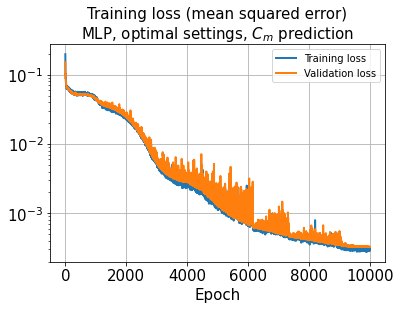

In [33]:
hist = history.history
plt.plot(hist['loss'], lw=2, label='Training loss')
plt.plot(hist['val_loss'], lw=2, label='Validation loss')
plt.title('Training loss (mean squared error)\nMLP, optimal settings, $C_m$ prediction', size=15)
plt.xlabel('Epoch', size=15)
plt.yscale('log')
#plt.ylim([5e-5, 1e-1])
plt.tick_params(axis='both', which='major', labelsize=15)
plt.grid()
plt.legend(loc='upper right')
saveName = "TrainingLoss_test"+str(test_rate) + ".jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

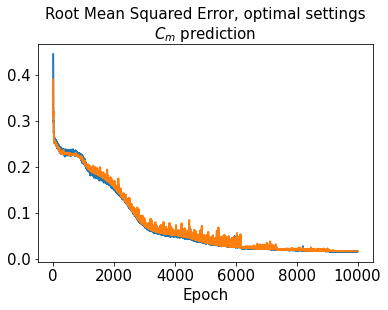

In [34]:
plt.plot(hist['rmse'], lw=2)
plt.plot(hist['val_rmse'], lw=2)
plt.title('Root Mean Squared Error, optimal settings\n$C_m$ prediction', size=15)
plt.xlabel('Epoch', size=15)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.show()

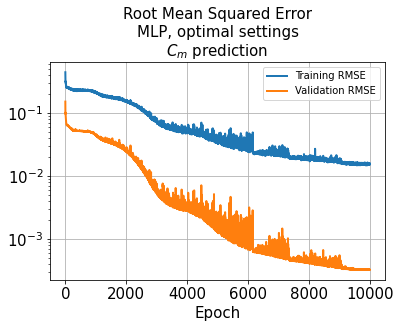

In [35]:
plt.plot(hist['rmse'], lw=2, label='Training RMSE')
plt.plot(hist['val_loss'], lw=2, label='Validation RMSE')
plt.title('Root Mean Squared Error\nMLP, optimal settings\n$C_m$ prediction', size=15)
plt.xlabel('Epoch', size=15)
plt.yscale('log')
plt.tick_params(axis='both', which='major', labelsize=15)
plt.grid()
plt.legend(loc='upper right')
saveName = "RMSE_test"+str(test_rate) + ".jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

In [36]:
train_results = model.evaluate(x_train, y_train)

110/110 [==============================] - 0s 4ms/step - loss: 3.0293e-04 - rmse: 0.0156


In [37]:
val_results = model.evaluate(x_val, y_val)

32/32 [==============================] - 0s 4ms/step - loss: 3.2670e-04 - rmse: 0.0163


In [38]:
test_results = model.evaluate(x_test, y_test)

16/16 [==============================] - 0s 4ms/step - loss: 3.1193e-04 - rmse: 0.0159


In [39]:
decoded_train_ = model.predict(x_train)
decoded_val_ = model.predict(x_val)
decoded_test_ = model.predict(x_test)

16/16 [==============================] - 0s 1ms/step


In [40]:
decoded_train_

array([[0.34835726],
       [0.1343365 ],
       [0.35141   ],
       ...,
       [0.7252936 ],
       [0.2797726 ],
       [0.34748524]], dtype=float32)

In [41]:
def define_index(cm, y):
    return np.unique(np.where(np.isin(cm, y)))

In [42]:
def error_absolute(y_pred, y_true):
    return np.abs(y_pred - y_true)

In [43]:
# Denormalize 
def denormalize(y):
    return y*(np.max(cm)-np.min(cm))+np.min(cm)

In [44]:
index_train = define_index(y, y_train)
index_val = define_index(y, y_val)
index_test = define_index(y, y_test)

In [45]:
y_train = denormalize(y_train)
y_val = denormalize(y_val)
y_test = denormalize(y_test)

In [46]:
decoded_train = denormalize(decoded_train_)
decoded_val = denormalize(decoded_val_)
decoded_test = denormalize(decoded_test_)

In [47]:
model_directory = "D:\\TrainedModels\\20221226"
if not os.path.exists(model_directory):
    os.makedirs(model_directory)
os.chdir(model_directory)
model_name = "20221226unsteadyValidation_MLP_val_"+str(val_rate)+"_test"+str(test_rate)+ "_" + str(n_layers) +"layers_"+str(n_units)+"units_randomState50CmPrediction.h5"
model.save(model_name, overwrite=True, include_optimizer=True, save_format='h5')

In [48]:
error_train_abs = error_absolute(decoded_train, y_train)
error_val_abs = error_absolute(decoded_val, y_val)
error_test_abs = error_absolute(decoded_test, y_test)

In [49]:
os.chdir(storage_dir)

In [50]:
def l2_error(y_pred, y_real):
    return np.sqrt(np.sum((y_pred - y_real)**2) / np.sum(y_real**2))

def mape(y_pred, y_real):
    return 100/len(y_real)*np.sum(np.abs((y_real-y_pred)/y_real))

def smape(y_pred, y_real):
    return 100*np.sum(np.abs(y_pred-y_real))/np.sum(y_real+y_pred)

In [51]:
l2_error_train = l2_error(decoded_train, y_train)
mape_train = smape(decoded_train, y_train)
print(l2_error_train)
print(mape_train)

0.04396718932510757
1.8724549416058778


In [52]:
l2_error_val = l2_error(decoded_val, y_val)
mape_val= smape(decoded_val, y_val)
print(l2_error_val)
print(mape_val)

0.04713212061718071
2.0226902760470296


In [53]:
l2_error_test = l2_error(decoded_test, y_test)
mape_test= smape(decoded_test, y_test)
print(l2_error_test)
print(mape_test)

0.049023354843968234
2.092778205515177


In [54]:
l2_error_train_list = []
for i in range(0, len(x_train)):
    l2_error_train_data = l2_error(decoded_train[i], y_train[i])
    l2_error_train_list.append(l2_error_train_data)

In [55]:
l2_error_val_list = []
for i in range(0, len(x_val)):
    l2_error_val_data = l2_error(decoded_val[i], y_val[i])
    l2_error_val_list.append(l2_error_val_data)

In [56]:
l2_error_test_list = []
for i in range(0, len(x_test)):
    l2_error_test_data = l2_error(decoded_test[i], y_test[i])
    l2_error_test_list.append(l2_error_test_data)

In [57]:
mape_train_list = []
for i in range(0, len(x_train)):
    mape_train_data = smape(decoded_train[i], y_train[i])
    mape_train_list.append(mape_train_data)

In [58]:
mape_val_list = []
for i in range(0, len(x_val)):
    mape_val_data = smape(decoded_val[i], y_val[i])
    mape_val_list.append(mape_val_data)

In [59]:
mape_test_list = []
for i in range(0, len(x_test)):
    mape_test_data = smape(decoded_test[i], y_test[i])
    mape_test_list.append(mape_test_data)

In [60]:
def distribution_plot(y_pred, y_real, dataset="train"):
    dictionary_name = {"train":"training", "val":"validation", "test":"test"}
    dictionary_data = {"train":l2_error_train_list, "val":l2_error_val_list, "test":l2_error_test_list}
    dictionary_error = {"train":l2_error_train, "val":l2_error_val, "test":l2_error_test}
    plot_title = '$L_2$ error norm distribution - MLP, unsteady, '+ dictionary_name.get(dataset) +'.\nValidation rate {0}, test rate {1}, {2} layers, {3} units ($C_m$)'.format(
        val_rate, test_rate, n_layers, n_units)
    plt.plot(np.linspace(1,y_real.shape[0],y_real.shape[0]),
             dictionary_error.get(dataset)*np.ones(y_real.shape[0],), 'k', lw=2.5)
    plt.scatter(np.linspace(1, y_real.shape[0], y_real.shape[0]), dictionary_data.get(dataset), c='b')
    plt.xlabel('Index', fontsize=15)
    plt.ylabel('$L_2$ error norm', fontsize=15)
    plt.yscale('log')
    plt.title(plot_title, fontsize=15)
    plt.grid()

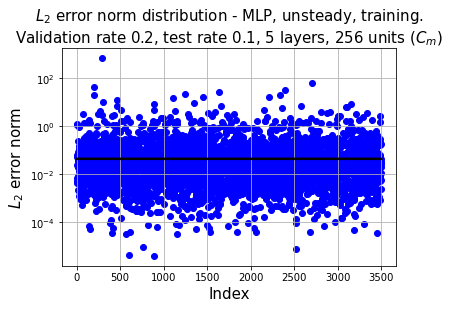

In [61]:
distribution_plot(decoded_train, y_train, dataset="train")
saveName = "trainingErrorDistribution.jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

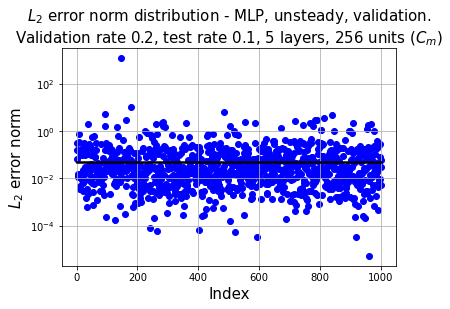

In [62]:
distribution_plot(decoded_val, y_val, dataset="val")
saveName = "validationErrorDistribution.jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

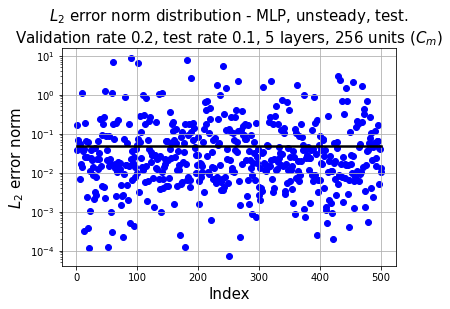

In [63]:
distribution_plot(decoded_test, y_test, dataset="test")
saveName = "testErrorDistribution.jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

In [64]:
predicted = model.predict(x)

157/157 [==============================] - 0s 2ms/step


In [65]:
predicted.shape

(5000, 1)

In [66]:
t_train = t[index_train]
t_val = t[index_val]
t_test = t[index_test]

In [67]:
iTrain=[]
iVal=[]
iTest=[]
for i, index in enumerate(index_train):
    iTrain.append(y[index])
for k , index in enumerate(index_val):
    iVal.append(y[index])
for j, index in enumerate(index_test):
    iTest.append(y[index])

In [68]:
iTrain = np.array(iTrain)
iVal = np.array(iVal)
iTest = np.array(iTest)

In [69]:
x += 10

In [70]:
def Cm_trainTestSplit_Plot(i, Cm, cm, tTrain, tTest, iTrain, iTest):
    
    title_0_Cm = 'Gurney flap not attached (NACA0018)\n$C_m$ prediction, $L_2$ error=%.4f' % l2_error_Cm    
    title_n_Cm = 'Gurney flap attached h=%.2f, '%(h[i]) + r'$\beta$=%d'%(beta[i])+'\n$C_m$ prediction, $L_2$ error=%.4f'%(l2_error_Cm)
    
    if i==0:
        title_Cm = title_0_Cm
        savename1 = "CmComparison_NACA0018.jpg"
    else:
        title_Cm = title_n_Cm
        savename1 = "CmComparison_h"+str(h[i])+"_beta"+str(beta[i])+".jpg"
    
    # CD graph plot
    plt.plot(x, denormalize(Cm), 'k-', label='Ground truth')
    plt.plot(x, denormalize(cm), 'k--', label='Predicted value')
    plt.scatter(tTrain, denormalize(iTrain), color='b', label='Training set')
    plt.scatter(tVal, denormalize(iVal), color='g', label='Validation set')
    plt.scatter(tTest, denormalize(iTest), color='r', label='Test set')
    plt.xlabel('Rev.')
    plt.ylabel('$C_m$')
    plt.title(title_Cm, fontsize=15)        
    plt.legend(loc='upper left')
    #plt.ylim([0, 0.0042])
    plt.grid()
    plt.savefig(savename1, dpi=300, bbox_inches='tight', pad_inches=0.3)
    plt.show()

NACA0018 airfoil without Gurney flap
L2 error of Cm: 0.0352


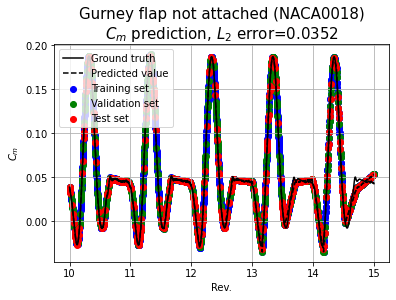

In [71]:
h = [0, 0.01, 0.01, 0.02, 0.02, 0.03, 0.03, 0.01, 0.02, 0.03, 0.01, 0.02, 0.03, 0.01, 0.02, 0.03]
beta = [0, 30, 45, 30, 45, 30, 45, 90, 90, 90, 60, 60, 60, 75, 75, 75]
for i in range(0, 1):
    # Index from each dataset
    iTrain = []
    iVal = []
    iTest = []
    
    # Index from input data (alpha, in this case)
    t_train = []
    t_val = []
    t_test = []
    
    predictedValue = predicted#[t_len*i:t_len*(i+1),:]
    y_corres = y[t_len*i:t_len*(i+1),:]#[t_len*i:t_len*(i+1),:]
    
    l2_error_Cm = np.sqrt(np.sum((predictedValue - y_corres)**2) / np.sum(y_corres**2))
    
    if i==0:
        print('NACA0018 airfoil without Gurney flap\nL2 error of Cm: {0:0.4f}'.format(l2_error_Cm))
    else:
        print('L2 error of Cm: {0:0.4f}'.format(l2_error_Cm))
    
    cm_ = predictedValue#denormalize(predictedValue)
    Cm = y_corres#denormalize(y_corres)
    
    for ii, index in enumerate(index_train[np.where((index_train<(i+1)*t_len) & ((index_train>=i*t_len)))]):
        iTrain.append(predicted[index])
    for jj, index in enumerate(index_val[np.where((index_val<(i+1)*t_len) & ((index_val>=i*t_len)))]):
        iVal.append(predicted[index])    
    for kk, index in enumerate(index_test[np.where((index_test<(i+1)*t_len) & (index_test>=i*t_len))]):
        iTest.append(predicted[index])
        
#     iTrain = denormalize(np.array(iTrain))
#     iTest = denormalize(np.array(iTest))
#     iVal = denormalize(np.array(iVal))
    iTrain = np.array(iTrain)
    iVal = np.array(iVal)
    iTest = np.array(iTest)
    
    for ii, index in enumerate(index_train[np.where((index_train<(i+1)*t_len) & ((index_train>=i*t_len)))]):
        t_train.append(t[index])
    for kk, index in enumerate(index_val[np.where((index_val<(i+1)*t_len) & ((index_val>=i*t_len)))]):
        t_val.append(t[index])
    for jj, index in enumerate(index_test[np.where((index_test<(i+1)*t_len) & ((index_test>=i*t_len)))]):
        t_test.append(t[index])
        
    tTrain = np.array(t_train)
    tVal = np.array(t_val)
    tTest = np.array(t_test)
    
    Cm_trainTestSplit_Plot(i, Cm, cm_, tTrain, tTest, iTrain, iTest)

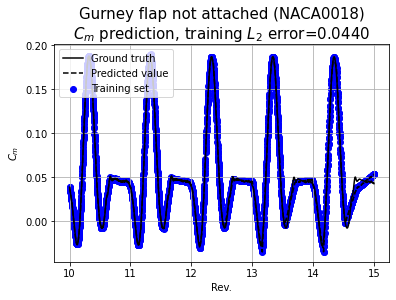

In [72]:
predictedValue = predicted#[t_len*i:t_len*(i+1),:]
y_corres = y[t_len*i:t_len*(i+1),:]#[t_len*i:t_len*(i+1),:]
cm_ = predictedValue#denormalize(predictedValue)
Cm = y_corres#denormalize(y_corres)

title_0_Cm = 'Gurney flap not attached (NACA0018)\n$C_m$ prediction, training $L_2$ error=%.4f' % l2_error_train
title_Cm = title_0_Cm
savename1 = "CmComparison_NACA0018.jpg"

# CD graph plot
plt.plot(x, cm, 'k-', label='Ground truth')
plt.plot(x, denormalize(cm_), 'k--', label='Predicted value')
plt.scatter(tTrain, denormalize(iTrain), color='b', label='Training set')
#plt.scatter(tVal, iVal, color='g', label='Validation set')
#plt.scatter(tTest, iTest, color='r', label='Test set')
plt.xlabel('Rev.')
plt.ylabel('$C_m$')
plt.title(title_Cm, fontsize=15)        
plt.legend(loc='upper left')
#plt.ylim([0, 0.0042])
plt.grid()
#plt.savefig(savename1, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

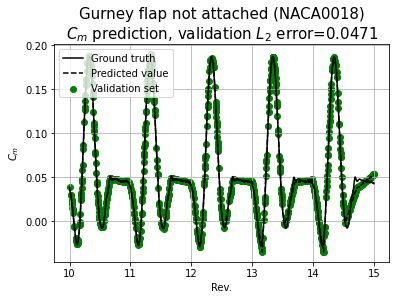

In [73]:
predictedValue = predicted#[t_len*i:t_len*(i+1),:]
y_corres = y[t_len*i:t_len*(i+1),:]#[t_len*i:t_len*(i+1),:]
cm_ = predictedValue#denormalize(predictedValue)
Cm = y_corres#denormalize(y_corres)

title_0_Cm = 'Gurney flap not attached (NACA0018)\n$C_m$ prediction, validation $L_2$ error=%.4f' % l2_error_val
title_Cm = title_0_Cm
savename1 = "CmComparison_NACA0018.jpg"

# CD graph plot
plt.plot(x, cm, 'k-', label='Ground truth')
plt.plot(x, denormalize(cm_), 'k--', label='Predicted value')
#plt.scatter(tTrain, iTrain, color='b', label='Training set')
plt.scatter(tVal, denormalize(iVal), color='g', label='Validation set')
#plt.scatter(tTest, iTest, color='r', label='Test set')
plt.xlabel('Rev.')
plt.ylabel('$C_m$')
plt.title(title_Cm, fontsize=15)        
plt.legend(loc='upper left')
#plt.ylim([0, 0.0042])
plt.grid()
#plt.savefig(savename1, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

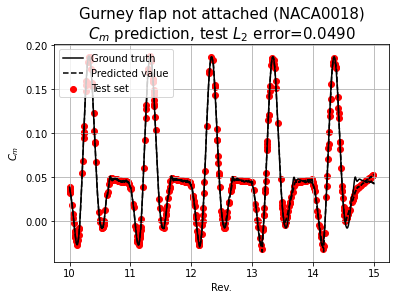

In [74]:
predictedValue = predicted#[t_len*i:t_len*(i+1),:]
y_corres = y[t_len*i:t_len*(i+1),:]#[t_len*i:t_len*(i+1),:]
cm_ = predictedValue#denormalize(predictedValue)
Cm = y_corres#denormalize(y_corres)

title_0_Cm = 'Gurney flap not attached (NACA0018)\n$C_m$ prediction, test $L_2$ error=%.4f' % l2_error_test
title_Cm = title_0_Cm
savename1 = "CmComparison_NACA0018.jpg"

# CD graph plot
plt.plot(x, cm, 'k-', label='Ground truth')
plt.plot(x, denormalize(cm_), 'k--', label='Predicted value')
#plt.scatter(tTrain, iTrain, color='b', label='Training set')
#plt.scatter(tVal, iVal, color='g', label='Validation set')
plt.scatter(tTest, denormalize(iTest), color='r', label='Test set')
plt.xlabel('Rev.')
plt.ylabel('$C_m$')
plt.title(title_Cm, fontsize=15)        
plt.legend(loc='upper left')
#plt.ylim([0, 0.0042])
plt.grid()
#plt.savefig(savename1, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()